In [1]:
#library(magick)
library(tidyverse)
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

tts <- 20
tts_small <- 16
theme_set(theme_classic(tts))

source("../color_df.R")

color_df <-
    color_df %>% 
    mutate(
        ssp_pop = pop,
        pop = str_remove_all(ssp_pop, "(LR_|Teo_|random1_|random2_)")
    ) %>% 
    dplyr::select(-ssp_pop) %>% 
    distinct()
color_df

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



pop,color
<chr>,<chr>
Los_Guajes,mediumaquamarine
Crucero_Lagunitas,gold
El_Rodeo,darkorange
Amatlan_de_Canas,cornflowerblue
San_Lorenzo,purple
Palmar_Chico,violetred
random,grey


In [2]:
s_file = "/group/jrigrp10/stittes/parv_local_v5_til11/data/rdmc/sweep_freq/v5--sweep--chr10--0--152435371_start80368977_end81344760_pops1-2-3-5.txt"

gmap <- "/group/jrigrp10/stittes/parv_local_v5_til11/data/map/ogut_v5.map.txt"

gen_map_all_chr <- vroom::vroom(gmap, delim = "\t") %>%
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>%
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    cm_bp <- tibble(rr = (df2$cm - df1$cm)/(df2$pos - df1$pos)/100)
    bind_cols(df2, cm_mb, cm_bp)
  }) %>%
  ungroup() %>% 
  mutate(chr = paste0("chr", chr))

get_rr <- function(genetic_df, sweep_chr, sweep_positions){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  median(approx(x = chr_df$pos, y = chr_df$rr, xout = sweep_positions)$y)
}

get_cm <- function(genetic_df, sweep_chr, sweep_start, sweep_end){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  cm_start <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_start)$y
  cm_end <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_end)$y
  cm_end - cm_start
}


MIN_FREQ <- 1/20
DEFAULT_SITES <- 1e4
MAX_SITES <- 1e5
MIN_SITES <- 1e3
#snps per cM to get ~ constant density along different sized sweeps 
SNP_K  <- 250000 



#get sweep start and end positions from file name
start <- str_split(s_file, "start", simplify = TRUE) %>% 
    `[`(2) %>% 
    str_split("_", simplify = TRUE) %>% 
    `[`(1) %>% 
    as.numeric(c)

end <- str_split(s_file, "end", simplify = TRUE) %>% 
    `[`(2) %>% 
    str_split("_", simplify = TRUE) %>% 
    `[`(1) %>% 
    as.numeric(c)

sweep_chrom <- str_split(s_file, "sweep--", simplify = TRUE) %>% 
    `[`(2) %>% 
    str_split("--", simplify = TRUE) %>% 
    `[`(1)

#get sweep size in cM. get how many sites to randomly sample along sweep
sweep_cM <- get_cm(gen_map_all_chr, sweep_chrom, start, end)
n_snps <- round(SNP_K*sweep_cM)
if(is.na(n_snps)) n_snps <- DEFAULT_SITES



n_sites <- case_when(
    is.na(n_snps) ~ NA_real_,
    n_snps >= MIN_SITES && n_snps <= MAX_SITES ~ n_snps,
    n_snps < MIN_SITES ~ MIN_SITES,
    n_snps > MAX_SITES ~ MAX_SITES,
)

sweep_cM
n_snps
n_sites

Rows: 6,490
Columns: 3
Delimiter: "\t"
dbl [3]: chr, pos, cm

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] 0.2304701

[1] 57618

[1] 57618

In [3]:

integer_breaks <- function(n = 5, ...) {
  fxn <- function(x) {
    breaks <- floor(pretty(x, n, ...))
    names(breaks) <- attr(breaks, "labels")
    breaks
  }
  return(fxn)
}

plot_rdmc <- function(file, cle_low = -10, pos = NULL, title = "", subtitle = "", base_size = 15){
    
    
    FREQ_POPS = c(
        "LR.A.Ca.",
        "LR.C.La.",
        "LR.L.Gu.",
        "LR.P.Ch.",
        "LR.S.Lo.",
        "Teo.A.Ca.",
        "Teo.C.La.",
        "Teo.E.Ro.",
        "Teo.L.Gu.",
        "Teo.P.Ch.",
        "Teo.S.Lo."
    )

    id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

    sweep_file <- vroom::vroom(file, delim = "\t")
    
    stopifnot(nrow(sweep_file) > 0)
    all_mods <- 
        sweep_file  %>%  
        filter(!is.na(cle), !is.na(neut_cle)) %>%  
        group_by(model) %>% 
        mutate(mcle = max(cle, na.rm = T) - neut_cle)
  
    best_mcle <- all_mods %>%
      group_by(model) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ungroup()  %>%
      arrange(desc(mcle))

    (best_mod <- best_mcle %>% slice(1) %>% pull(model))

    

    if (best_mod == "standing"){
        

    if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set1") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set1") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 


        #visualize likelihood surface wrt age
        a  <- all_mods %>%
          group_by(times, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(times), mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("log10 Age") +
          scale_color_brewer(palette = "Set1") +  
          theme_classic(base_size) +
          theme(legend.position = "n") +
          scale_x_log10() 


        #visualize likelihood surface wrt age
        b <- all_mods %>%
          group_by(gs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(gs, mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("Initial allele frequency") +
          scale_color_brewer(palette = "Set1") +      
          theme_classic(base_size) +
          scale_x_continuous(breaks= scales::breaks_pretty(2)) +
          theme(legend.position = "n")  
        

        plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + a + b + plot_layout(nrow = 4)

    } else if(best_mod == "migration"){
        
     if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set2") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set2") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set2") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 

        
         a  <- all_mods %>%
          group_by(migs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(migs), mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("log10 Migration rate") +
          scale_color_brewer(palette = "Set2") +
          theme_classic(base_size) +
          theme(legend.position = "n")

        b  <- all_mods %>%
          group_by(sources, model) %>%
          filter(model == best_mod) %>%  
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          filter(mcle > cle_low) %>%
          left_join(., id_df, by = "sources") %>% 
          ggplot() +
          geom_segment(aes(x = pop_id, xend = pop_id, y =0, yend = mcle, colour = model), lwd = 1.2) +
          ylab(expression(Delta[cle])) +
          xlab("Source") +
          scale_color_brewer(palette = "Set2") +
          theme_classic(base_size) +
          scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
          theme(legend.position = "n") 

        plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + a + b + plot_layout(nrow = 4)

    } else {
        
        
        if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set1") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set1") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 
        
        
    plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + plot_layout(nrow = 2)
        
    }
    
        return(plot_full)

}

All of this is broken cause the intervals have changed.

options(repr.plot.width = 25, repr.plot.height = 10, repr.plot.res = 200)

tb1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start272261071_end272472669_pops1-2-3-4-5.txt", 
    cle_low = -20, 
    title = "A", 
    subtitle = "tb1\n(branching architecture)\nMigration"
)

bt2 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", 
    cle_low = -20,
    title = "B", 
    subtitle = "bt2\n(startch synthesis)\nMigration"
)


ZmSh1_1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start230510870_end230574345_pops3-4-5.txt",  
    cle_low = -20,
    title = "C",
    subtitle = "ZmSh1-1\n(seed shattering)\nMigration"
)

su1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start43263146_end43615149_pops2-3-4.txt",
    cle_low = -20,
    title = "D",
    subtitle = "su1\n(starch biosynthesis)\nStanding"
)

sweet <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start130340943_end130464598_pops1-2-4-5.txt",
    cle_low = -20,
    title = "E",
    subtitle = "sweet4c\n(sugar transport, seed size)\nStanding"
)



(tb1 | bt2 | ZmSh1_1) |  su1 |  sweet + theme(plot.margin = unit(c(0.1,1,0.1,1), "cm")) 
ggsave("../figures/supplement_domestication_sweeps.pdf", height = 10, width = 25)


plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", 
    cle_low = -Inf,
    title = "B", 
    subtitle = "bt2\n(startch synthesis)\nMigration"
)


all_mods <- vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")

range(vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")$cle, na.rm = T)

all_mods %>%
    filter(is.na(cle))

In [4]:
make_rdmc_file <- function(file_name){
    
    if(file.exists(file_name)){
        read_csv(file_name)
    } else {    
        suppressWarnings(
        suppressMessages(
            
        top_models_df <- fs::dir_ls(path = "../data/rdmc/fitted/") %>% 
            map_df(~{
                    sweep_file <- vroom::vroom(.x, delim = "\t")
                    if(nrow(sweep_file) > 0){
                        sweep_file %>% 
                        #filter(!is.na(cle), !is.na(neut_cle), !neut_cle %in% c(-Inf, Inf), !cle %in% c(-Inf, Inf)) %>%  
                        group_by(model) %>%
                        filter(cle == max(cle, na.rm=T)) %>%
                        mutate(mcle = cle - neut_cle) %>%
                        ungroup() %>%
                        mutate(mcle_delta = mcle - max(mcle, na.rm=T)) %>%
                        arrange(desc(mcle)) %>%  
                        slice(1:2) %>%
                        mutate(mcle_nextbest_diff = -diff(mcle)) %>% 
                        slice(1) %>%
                        mutate(file_name = .x)
                    } else{
                        tibble()
                    }

            }) %>% 
            mutate(populations = sel_pop_ids) %>% 
            mutate(populations = str_remove_all(populations, "data/raisd/"),
                   populations = str_remove_all(populations, ".corrected_block_outliers_merged.txt"),
                   populations = str_replace_all(populations, "random1", "RANDOM1"),
                   populations = str_replace_all(populations, "random2", "RANDOM2"),
                   type = case_when(
                       grepl("LR", populations) & grepl("Teo", populations) ~ "both",
                       grepl("LR", populations) & !grepl("Teo", populations) ~ "Maize",
                       !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
                       TRUE ~ "nan"
                   ),
                pop_count = str_count(populations, ";")+1,
                Landraces_count = str_count(populations, "LR"),
                Teosinte_count =  str_count(populations, "Teo"),
                model2 = ifelse(mcle < 0, "neutral", model)
                ) 
        ))
        
            write_csv(x = top_models_df, file = file_name)
            top_models_df
    }
}


In [5]:
top_models_df <- make_rdmc_file("rdmc_topmodels.csv")
#top_models_df <- top_models_df %>% filter(mcle > 10)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  locus = col_character(),
  sel_pops = col_character(),
  model = col_character(),
  sel_pop_ids = col_character(),
  file_name = col_character(),
  populations = col_character(),
  type = col_character(),
  model2 = col_character()
)
ℹ Use `spec()` for the full column specifications.




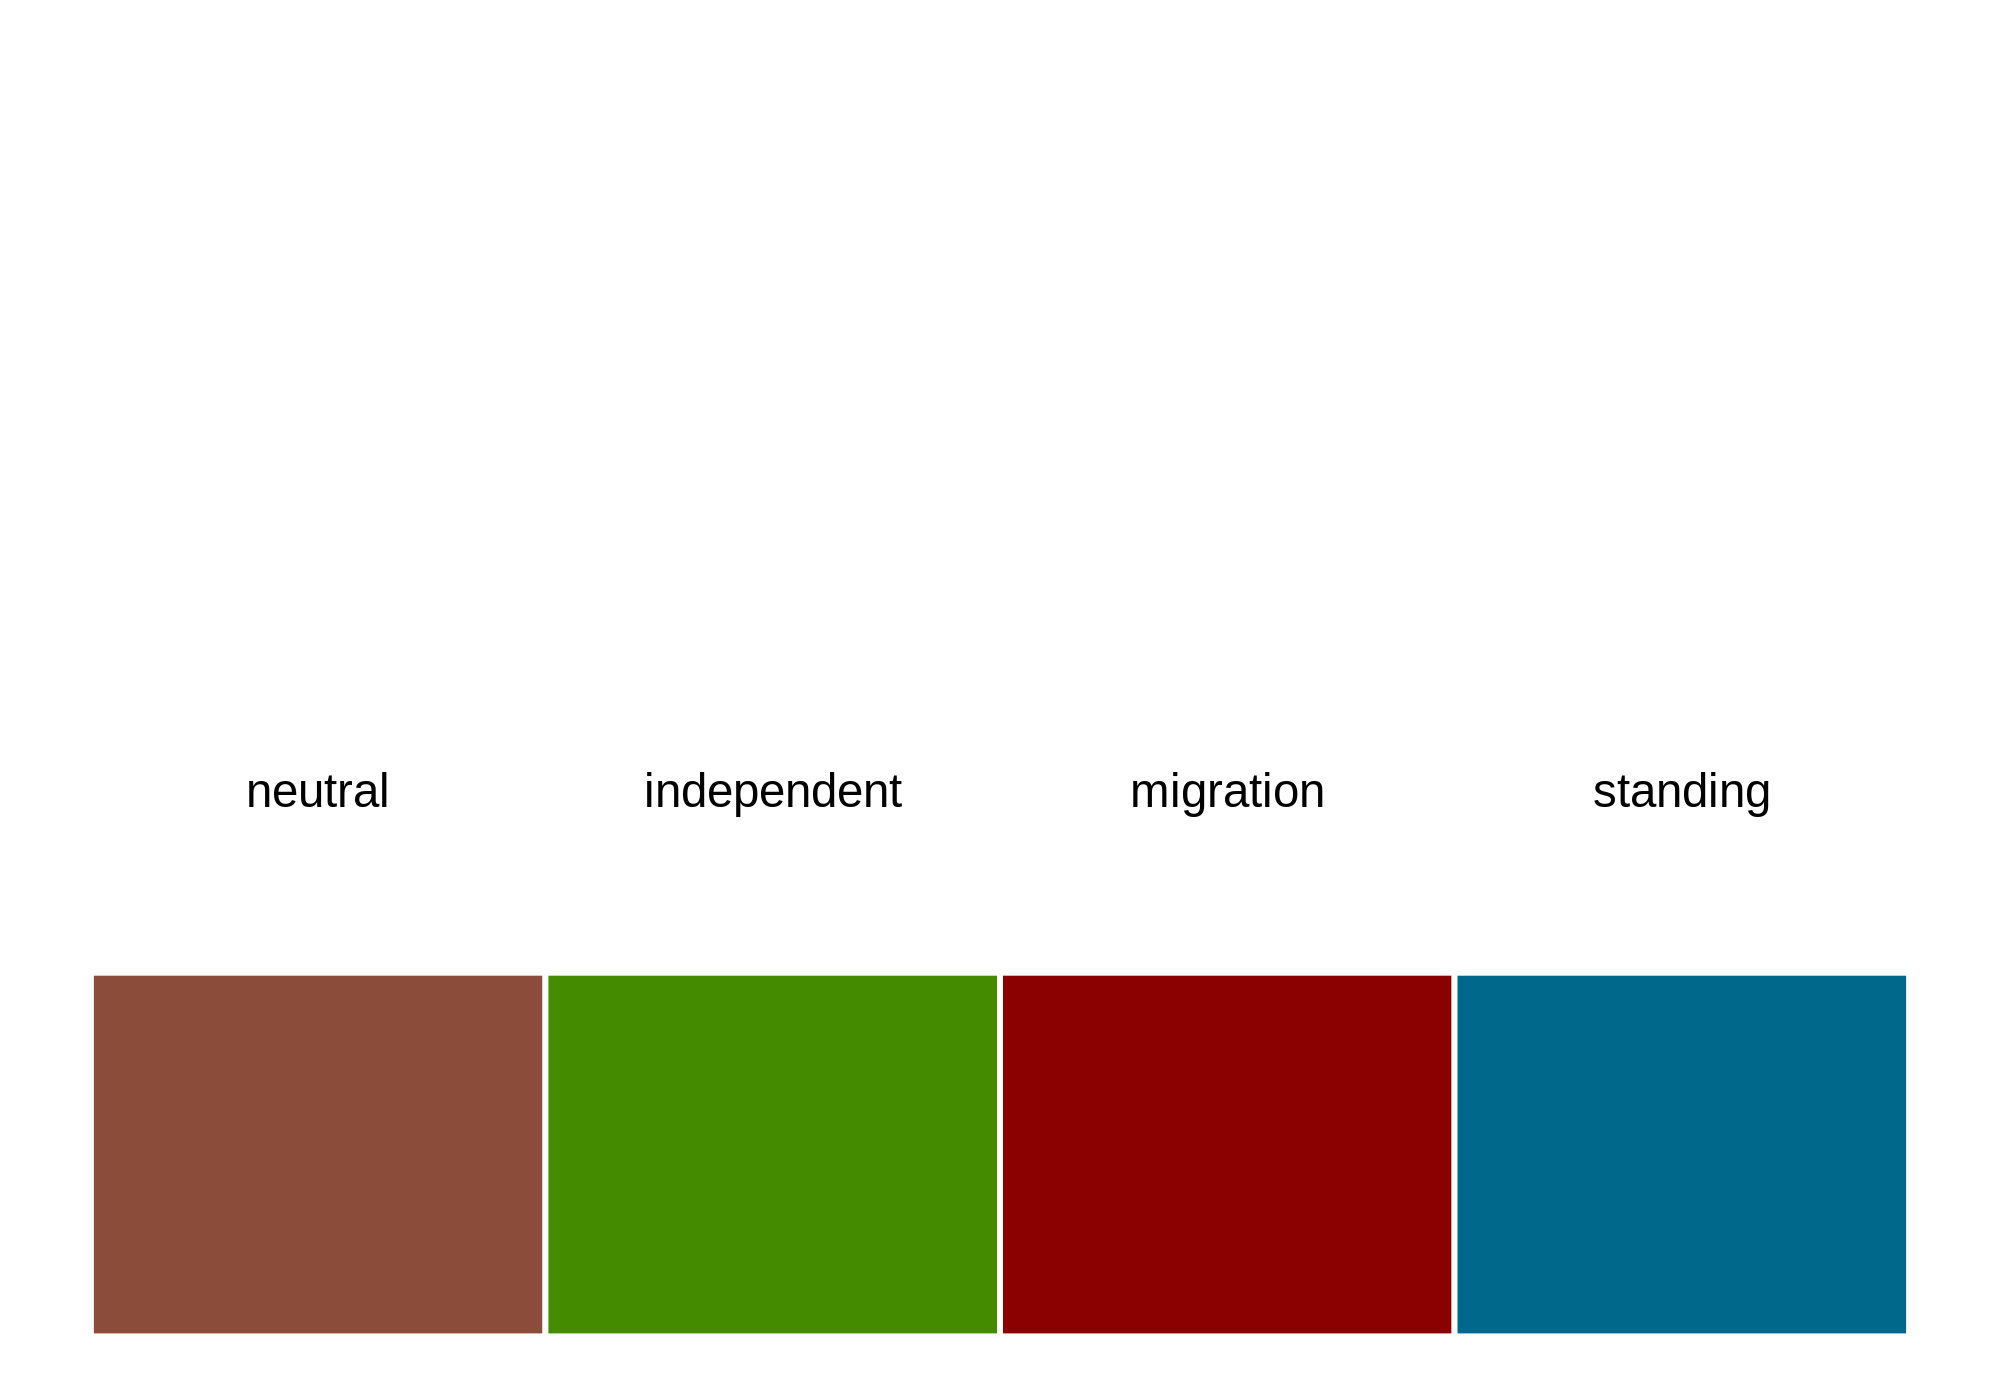

In [6]:
mode_leg <- function(size = 6, nud = 0.5){
tibble(mode = c("neutral", "independent", "migration", "standing"),
      color = c("salmon4", "chartreuse4", "darkred", "deepskyblue4"),
      position_x = 1:4,
      position_y = rep(0, 4),
      ) %>% 
ggplot(aes(position_x, position_y, fill = color)) +
    geom_tile(colour = "white", lwd = 1) +
    geom_text(aes(position_x, position_y + nud, label = mode), inherit.aes = F, size = size) +
    xlim(0.5, 4.5) +
    ylim(-0.5, 2+nud) +
    scale_fill_identity() +
    theme_void()
}

mode_leg(nud = 1)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


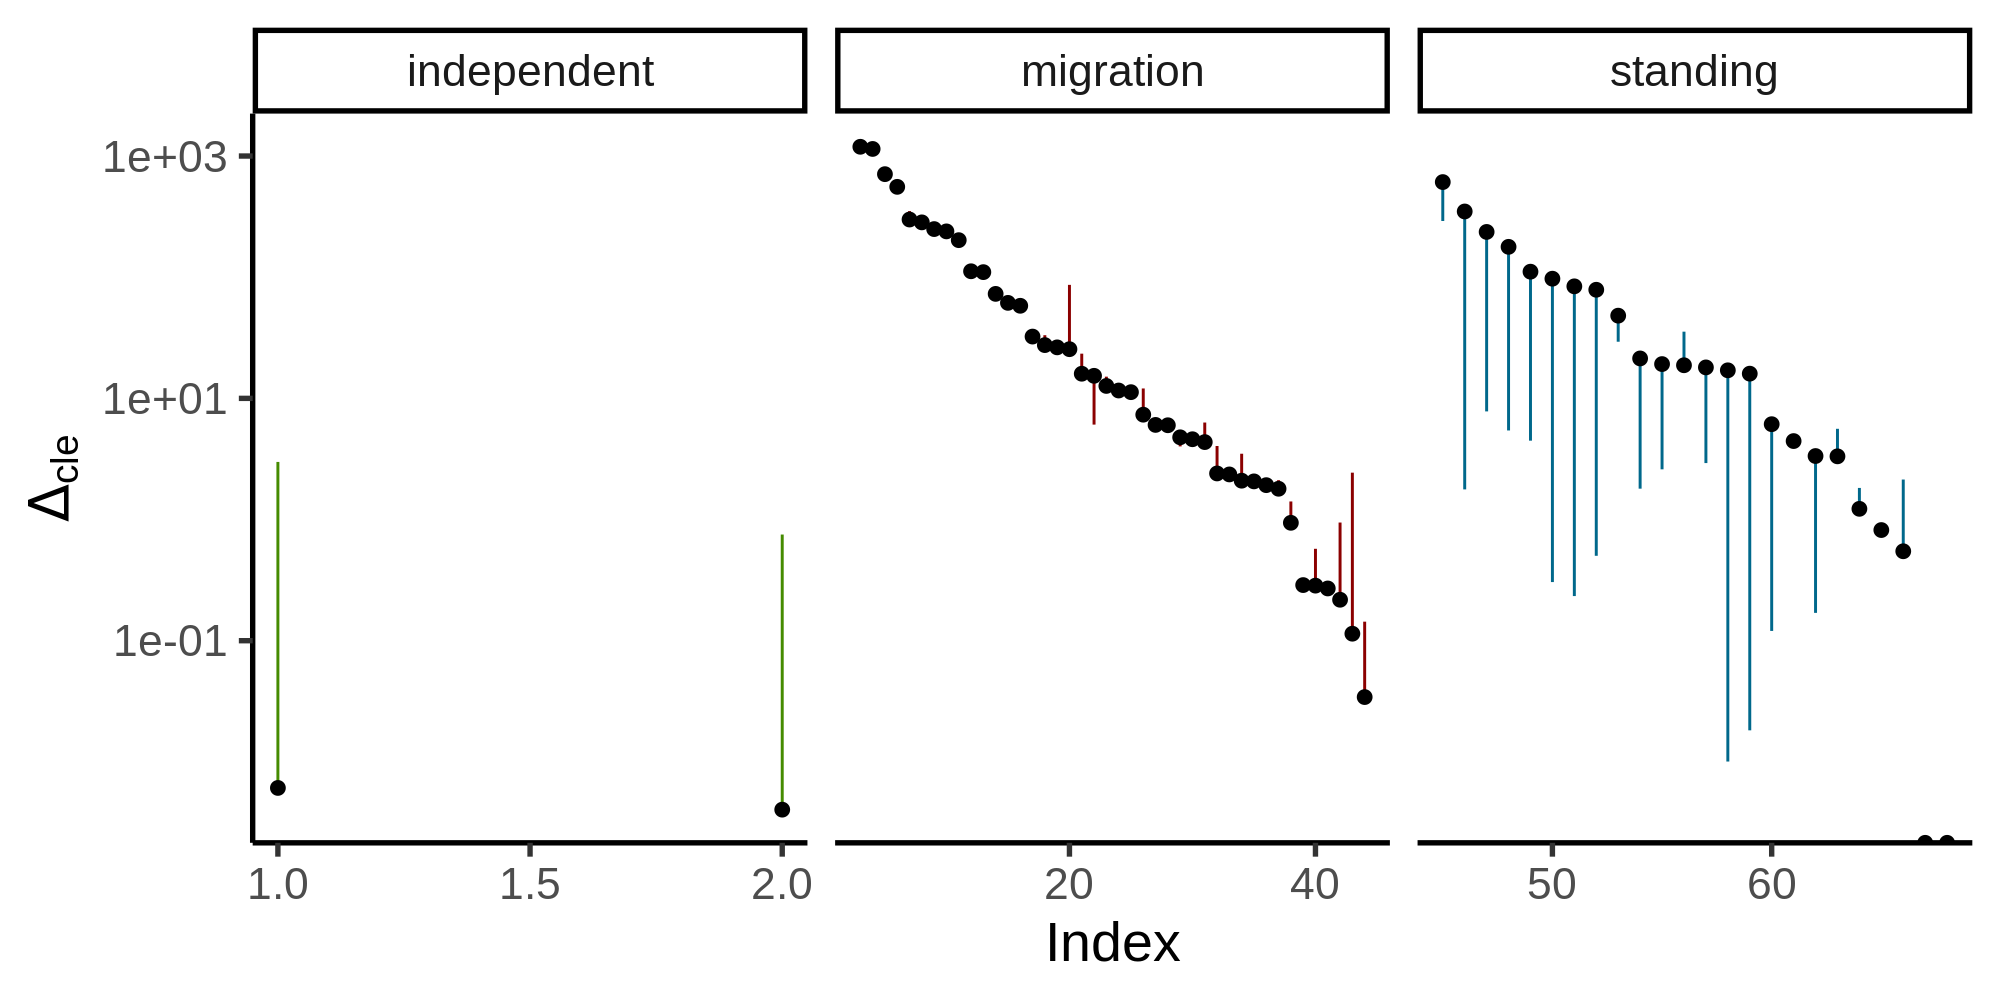

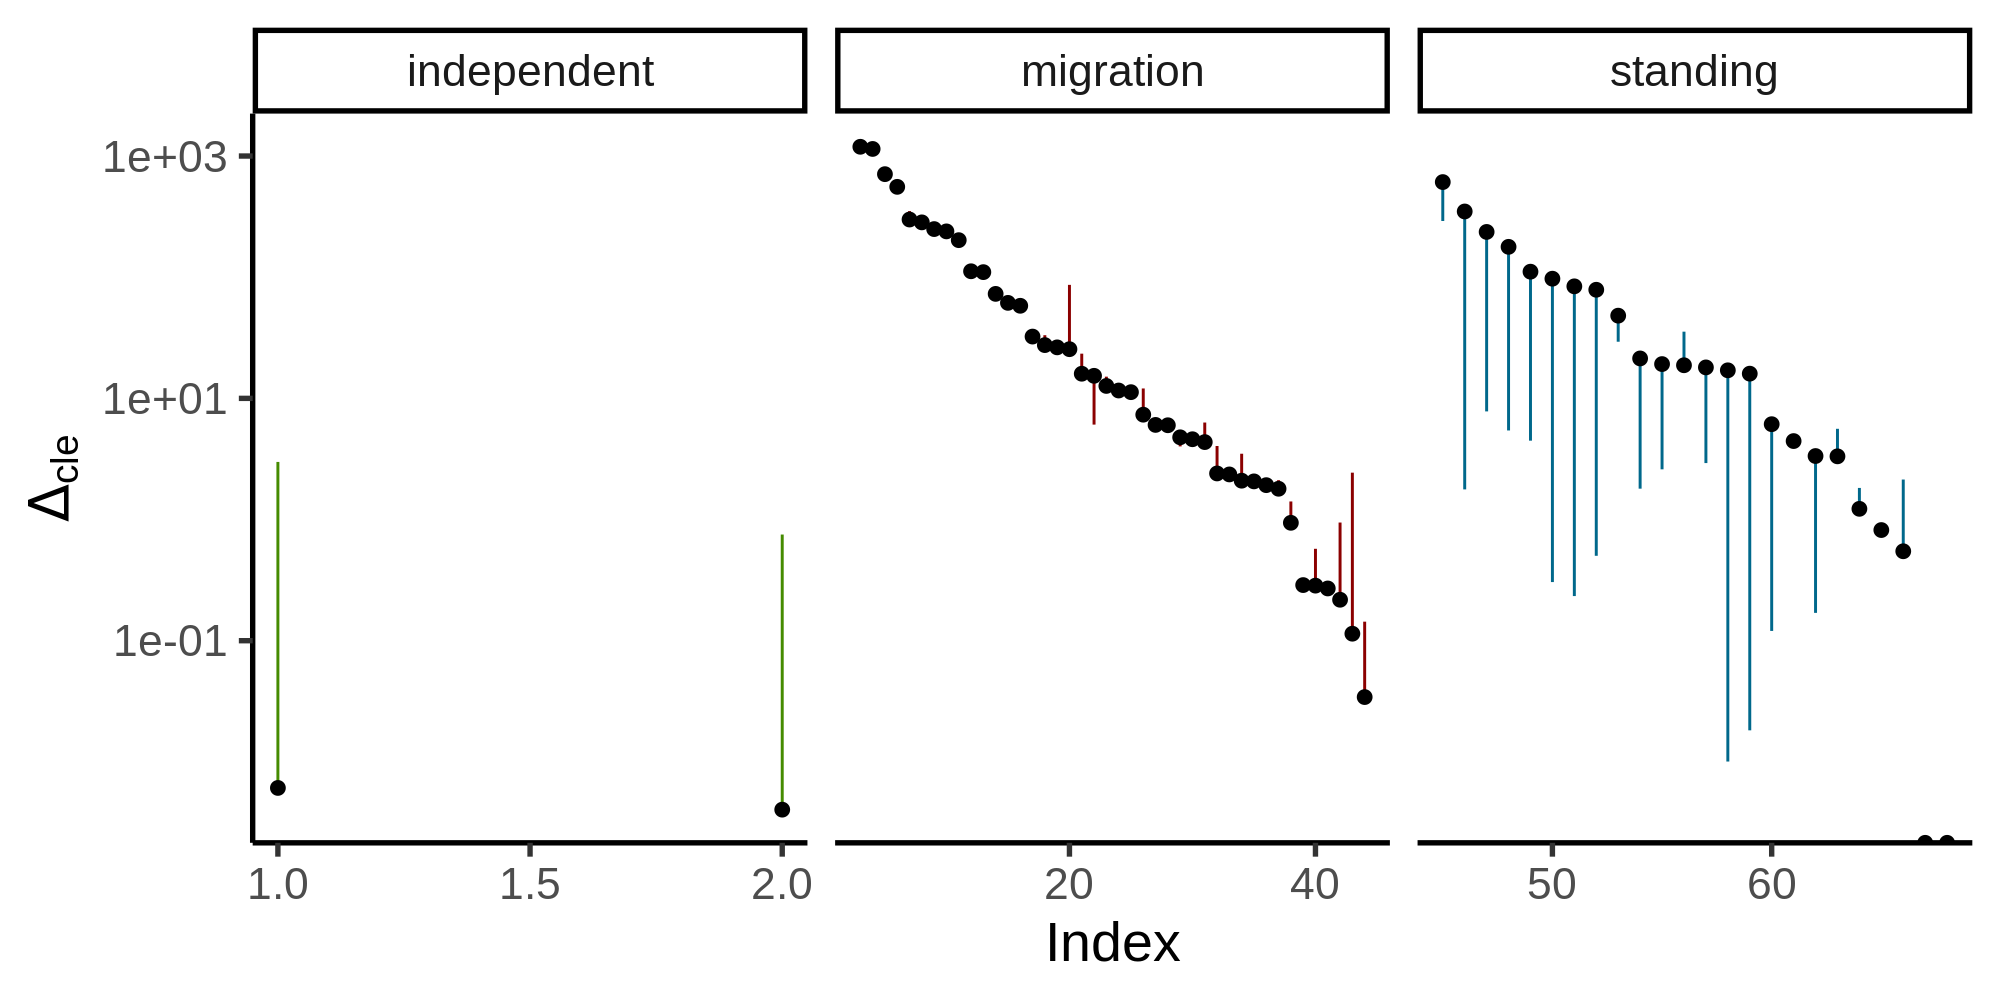

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


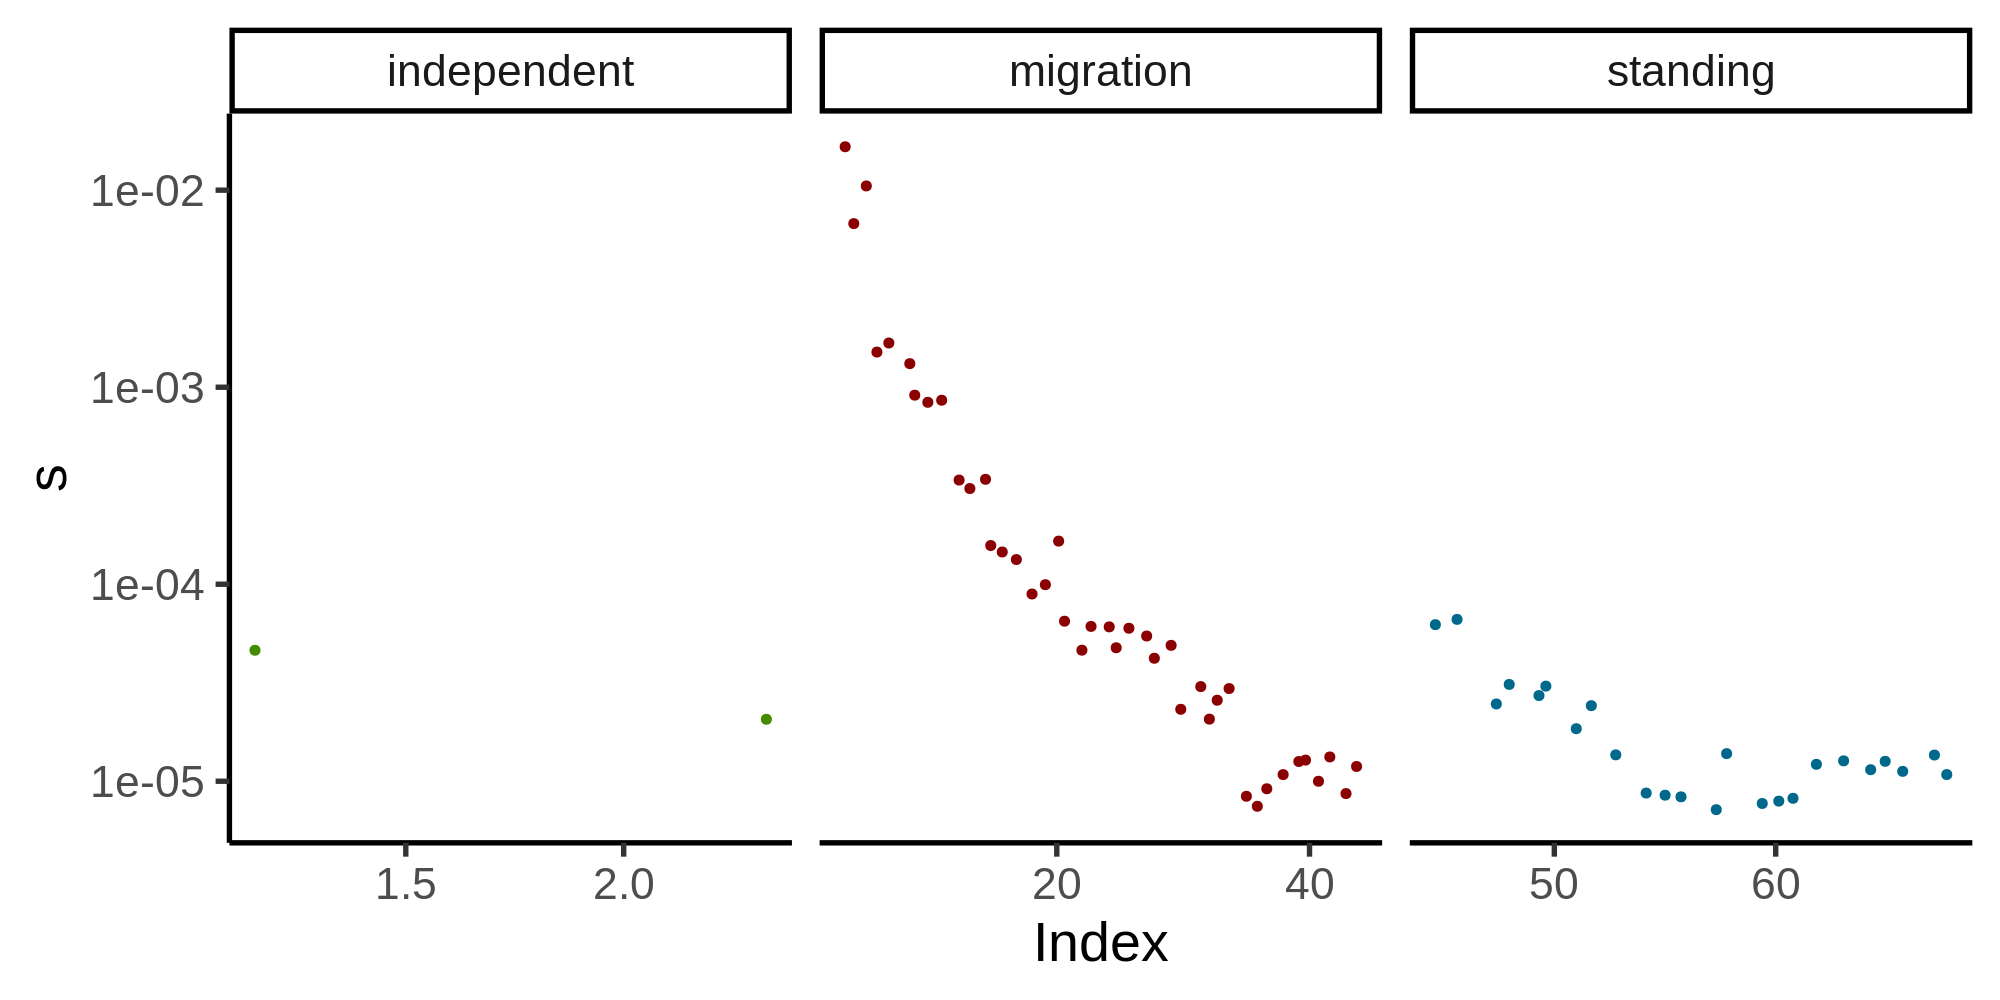

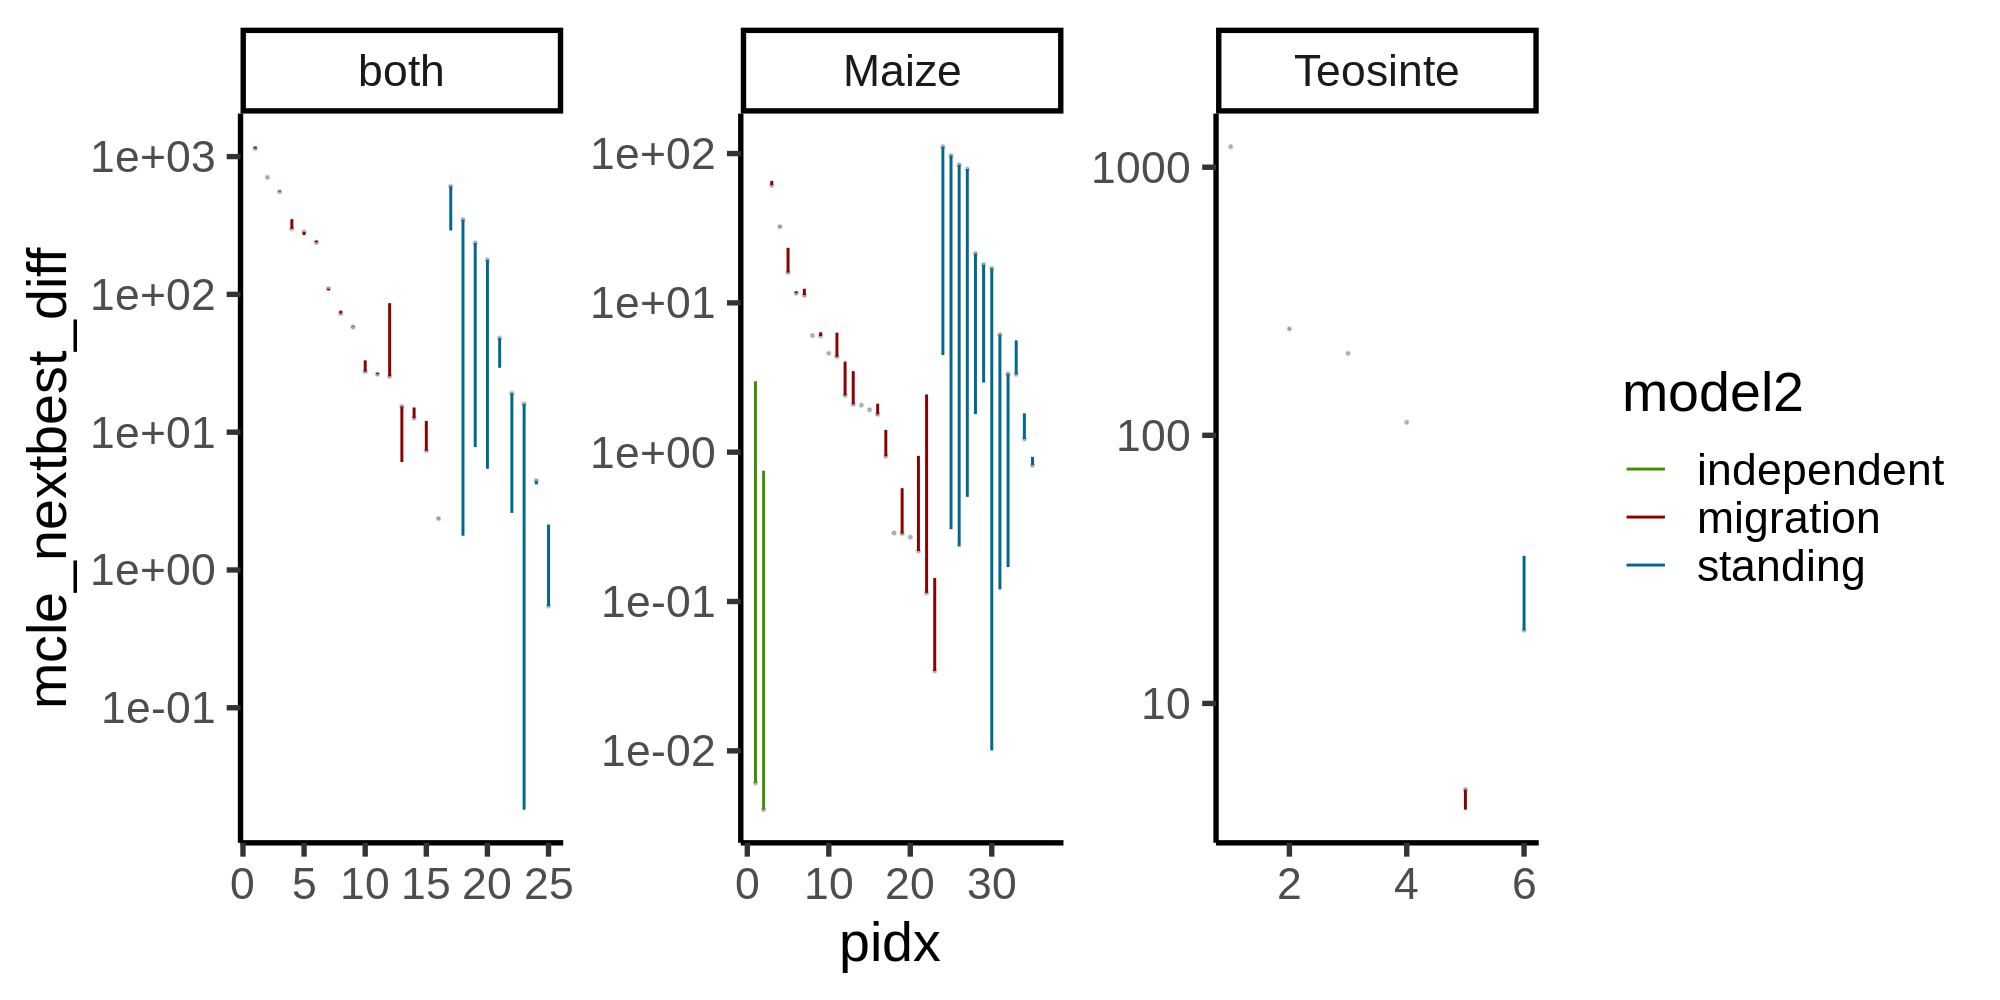

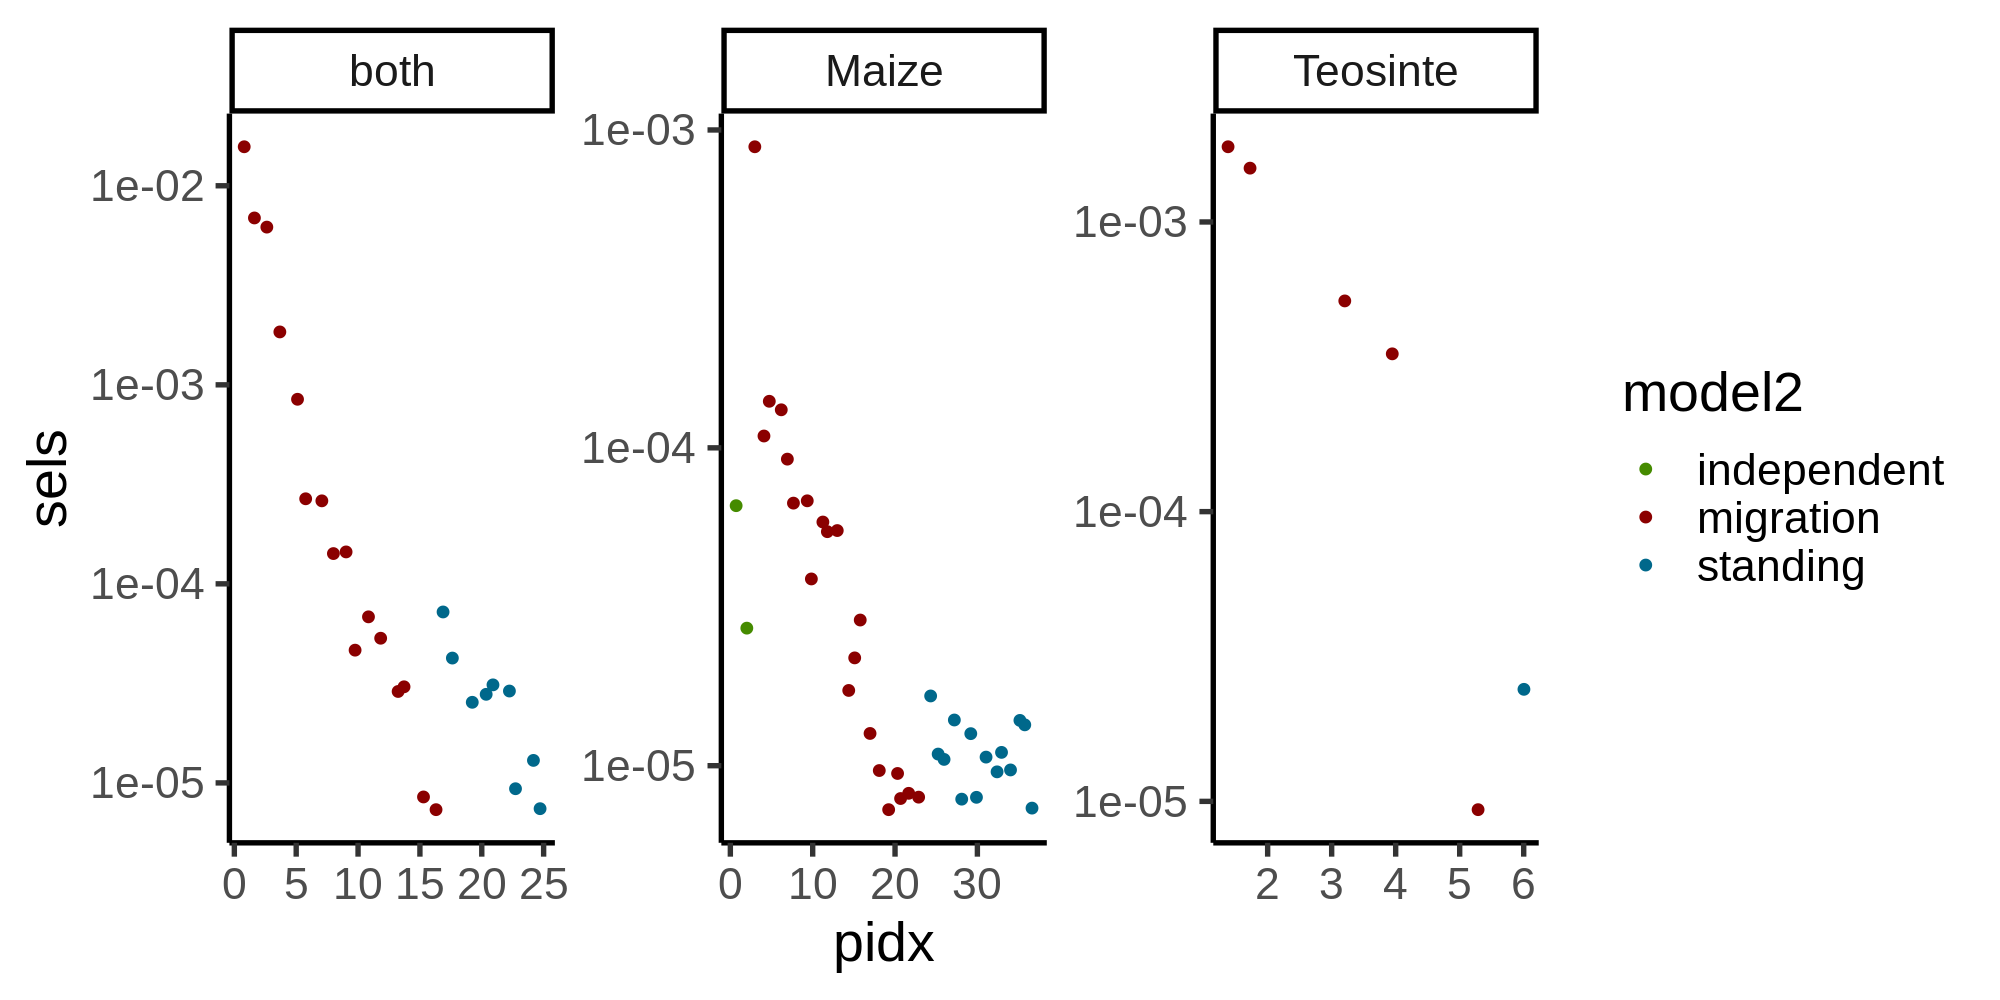

In [7]:

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
#mode_cols <- c("independent" = "chartreuse4", "migration" = "dodgerblue", "standing" = "purple")
sel_cols <- c("neutral" = "salmon4", "independent" = "chartreuse4", "migration" = "darkred", "standing" = "deepskyblue4")


mode_mcle <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    mutate(pidx = 1:n()) %>% 
    ggplot() +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    geom_point(aes(pidx, mcle_nextbest_diff), size = 2, alpha = 1) +
    scale_y_log10() +
    facet_wrap(~model, scale = "free_x", nrow = 1) +
    scale_color_manual(values = sel_cols) +
    scale_x_continuous(breaks = scales::breaks_pretty(3)) +
    theme(legend.position = "n") +
    xlab("Index") +
    ylab(expression(Delta[cle]))
mode_mcle


mode_sels <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    arrange(model2, desc(sels)) %>%
    mutate(pidx = 1:n()) %>%  
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter(size = 1.2)+
    scale_y_log10() +
    facet_wrap(~model, scale = "free_x", nrow = 1) +
    scale_color_manual(values = sel_cols) +
    scale_x_continuous(breaks = scales::breaks_pretty(3)) +
    xlab("Index") +
    ylab("s") +
    labs(color='Mode') +
    theme(legend.position = "n")


mode_mcle
mode_sels

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    group_by(type) %>% 
    mutate(pidx = 1:n())  %>% 
    ggplot()+
    geom_point(aes(pidx, mcle_nextbest_diff), size = 0.25, alpha = 0.2) +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    arrange(model2, desc(sels)) %>%
    group_by(type) %>% 
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)


In [8]:
top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    mutate(pidx = 1:n()) 

selected_sites,sels,cle,locus,gs,times,migs,sources,sel_pops,model,⋯,mcle_nextbest_diff,file_name,populations,type,pop_count,Landraces_count,Teosinte_count,model2,bn_diff,pidx
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
129041089,5.336699e-05,588823.28,data/rdmc/sweep_freq/v5--sweep--chr7--0--185808916_start127910701_end129152953_pops3-4.txt,NA,NA,NA,NA,3-4,independent,⋯,6.097349e-03,../data/rdmc/fitted/v5--sweep_chr7--0--185808916_start127910701_end129152953_pops3-4.txt,v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico,Maize,2,2,0,independent,2.981537927,1
124053482,2.310130e-05,419564.24,data/rdmc/sweep_freq/v5--sweep--chr8--0--182411202_start123261467_end124595260_pops3-4.txt,NA,NA,NA,NA,3-4,independent,⋯,4.035219e-03,../data/rdmc/fitted/v5--sweep_chr8--0--182411202_start123261467_end124595260_pops3-4.txt,v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico,Maize,2,2,0,independent,0.748027475,2
151999867,1.519911e-03,1424028.17,data/rdmc/sweep_freq/v5--sweep--chr5--0--226353449_start151279946_end153388433_pops8-11.txt,NA,NA,0.001000000,8,8-11,migration,⋯,1.191770e+03,../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start151279946_end153388433_pops8-11.txt,v5--Teo--El_Rodeo; v5--Teo--San_Lorenzo,Teosinte,2,0,2,migration,0.228162897,3
120814687,1.519911e-03,1717932.26,data/rdmc/sweep_freq/v5--sweep--chr5--0--226353449_start115496539_end123583700_pops1-2-3-4-5-11.txt,NA,NA,0.100000000,2,1-2-3-4-5-11,migration,⋯,1.143658e+03,../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start115496539_end123583700_pops1-2-3-4-5-11.txt,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--San_Lorenzo,both,6,5,1,migration,34.964437759,4
31534723,8.111308e-03,634799.88,data/rdmc/sweep_freq/v5--sweep--chr4--0--250330460_start31687527_end33215589_pops4-8.txt,NA,NA,0.006309573,8,4-8,migration,⋯,7.082849e+02,../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start31687527_end33215589_pops4-8.txt,v5--LR--RANDOM1_Palmar_Chico; v5--Teo--El_Rodeo,both,2,1,1,migration,0.329448164,5
55035788,6.579332e-04,1422801.25,data/rdmc/sweep_freq/v5--sweep--chr9--0--163004744_start54686688_end67982374_pops1-2-3-4-5-8.txt,NA,NA,0.100000000,2,1-2-3-4-5-8,migration,⋯,5.565450e+02,../data/rdmc/fitted/v5--sweep_chr9--0--163004744_start54686688_end67982374_pops1-2-3-4-5-8.txt,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--El_Rodeo,both,6,5,1,migration,4.785488031,6
156394968,8.111308e-03,268408.11,data/rdmc/sweep_freq/v5--sweep--chr9--0--163004744_start156274637_end156832957_pops2-8.txt,NA,NA,0.001000000,8,2-8,migration,⋯,2.990873e+02,../data/rdmc/fitted/v5--sweep_chr9--0--163004744_start156274637_end156832957_pops2-8.txt,v5--LR--Crucero_Lagunitas; v5--Teo--El_Rodeo,both,2,1,1,migration,52.301265937,7
82298318,1.232847e-04,266408.55,data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start82008700_end83353284_pops4-11.txt,NA,NA,0.100000000,11,4-11,migration,⋯,2.833643e+02,../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start82008700_end83353284_pops4-11.txt,v5--LR--RANDOM1_Palmar_Chico; v5--Teo--San_Lorenzo,both,2,1,1,migration,13.890915561,8
100941526,2.848036e-04,257301.87,data/rdmc/sweep_freq/v5--sweep--chr2--0--243675191_start99052452_end101670188_pops7-8.txt,NA,NA,0.001000000,7,7-8,migration,⋯,2.494438e+02,../data/rdmc/fitted/v5--sweep_chr2--0--243675191_start99052452_end101670188_pops7-8.txt,v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo,Teosinte,2,0,2,migration,0.511725639,9


,model2,n()
,<chr>,<int>
1,independent,2
2,migration,42
3,neutral,34
4,standing,24


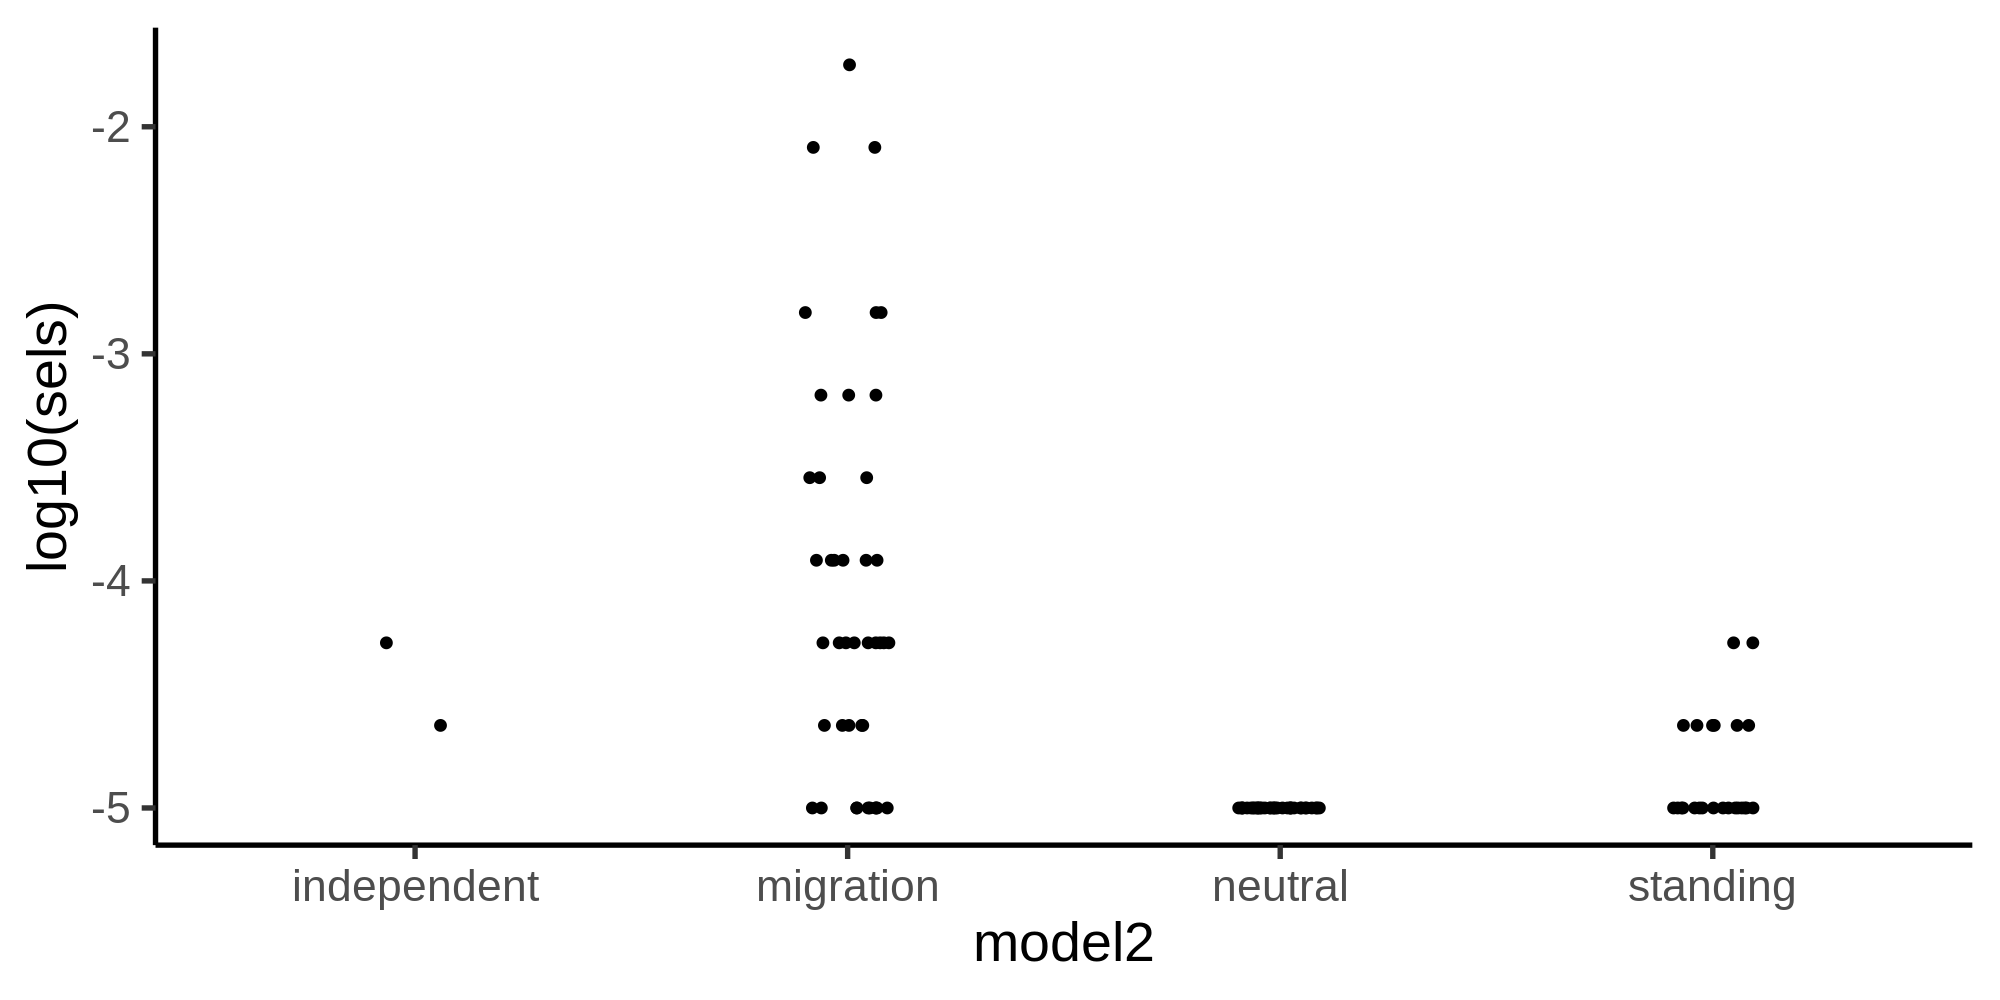

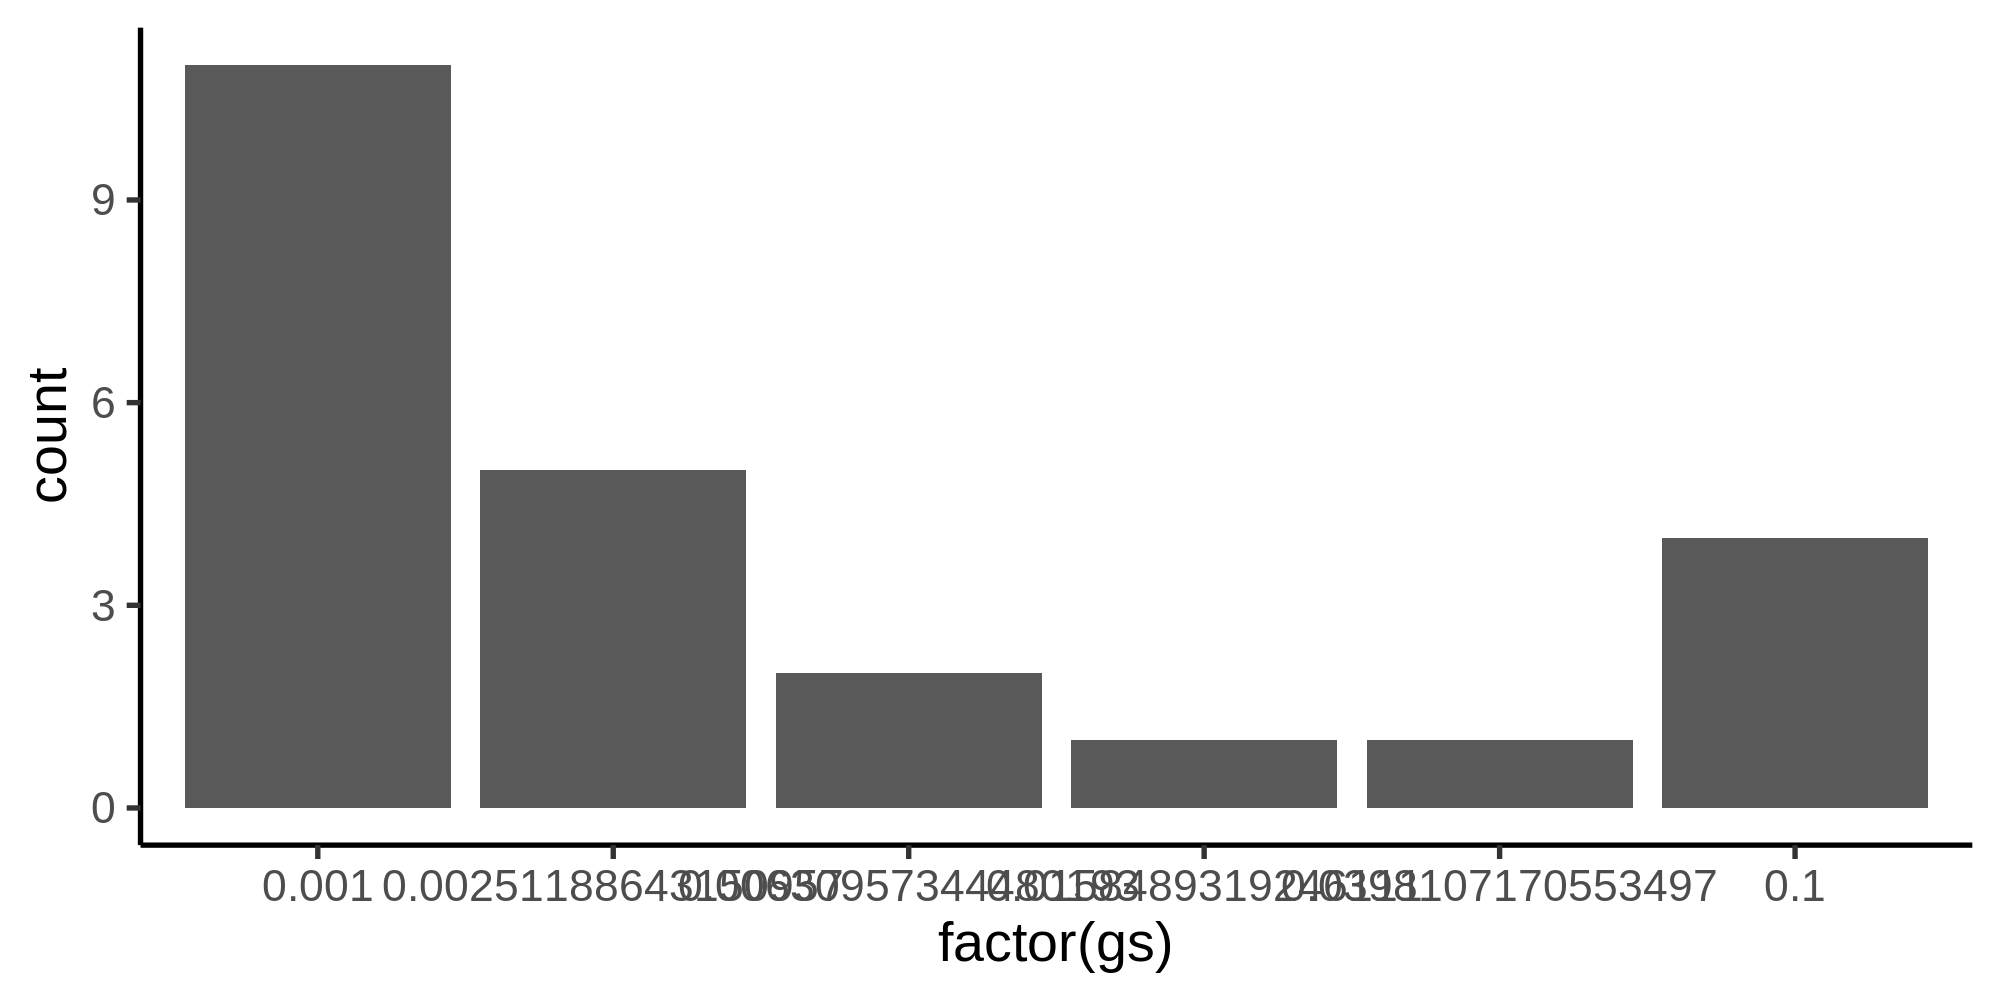

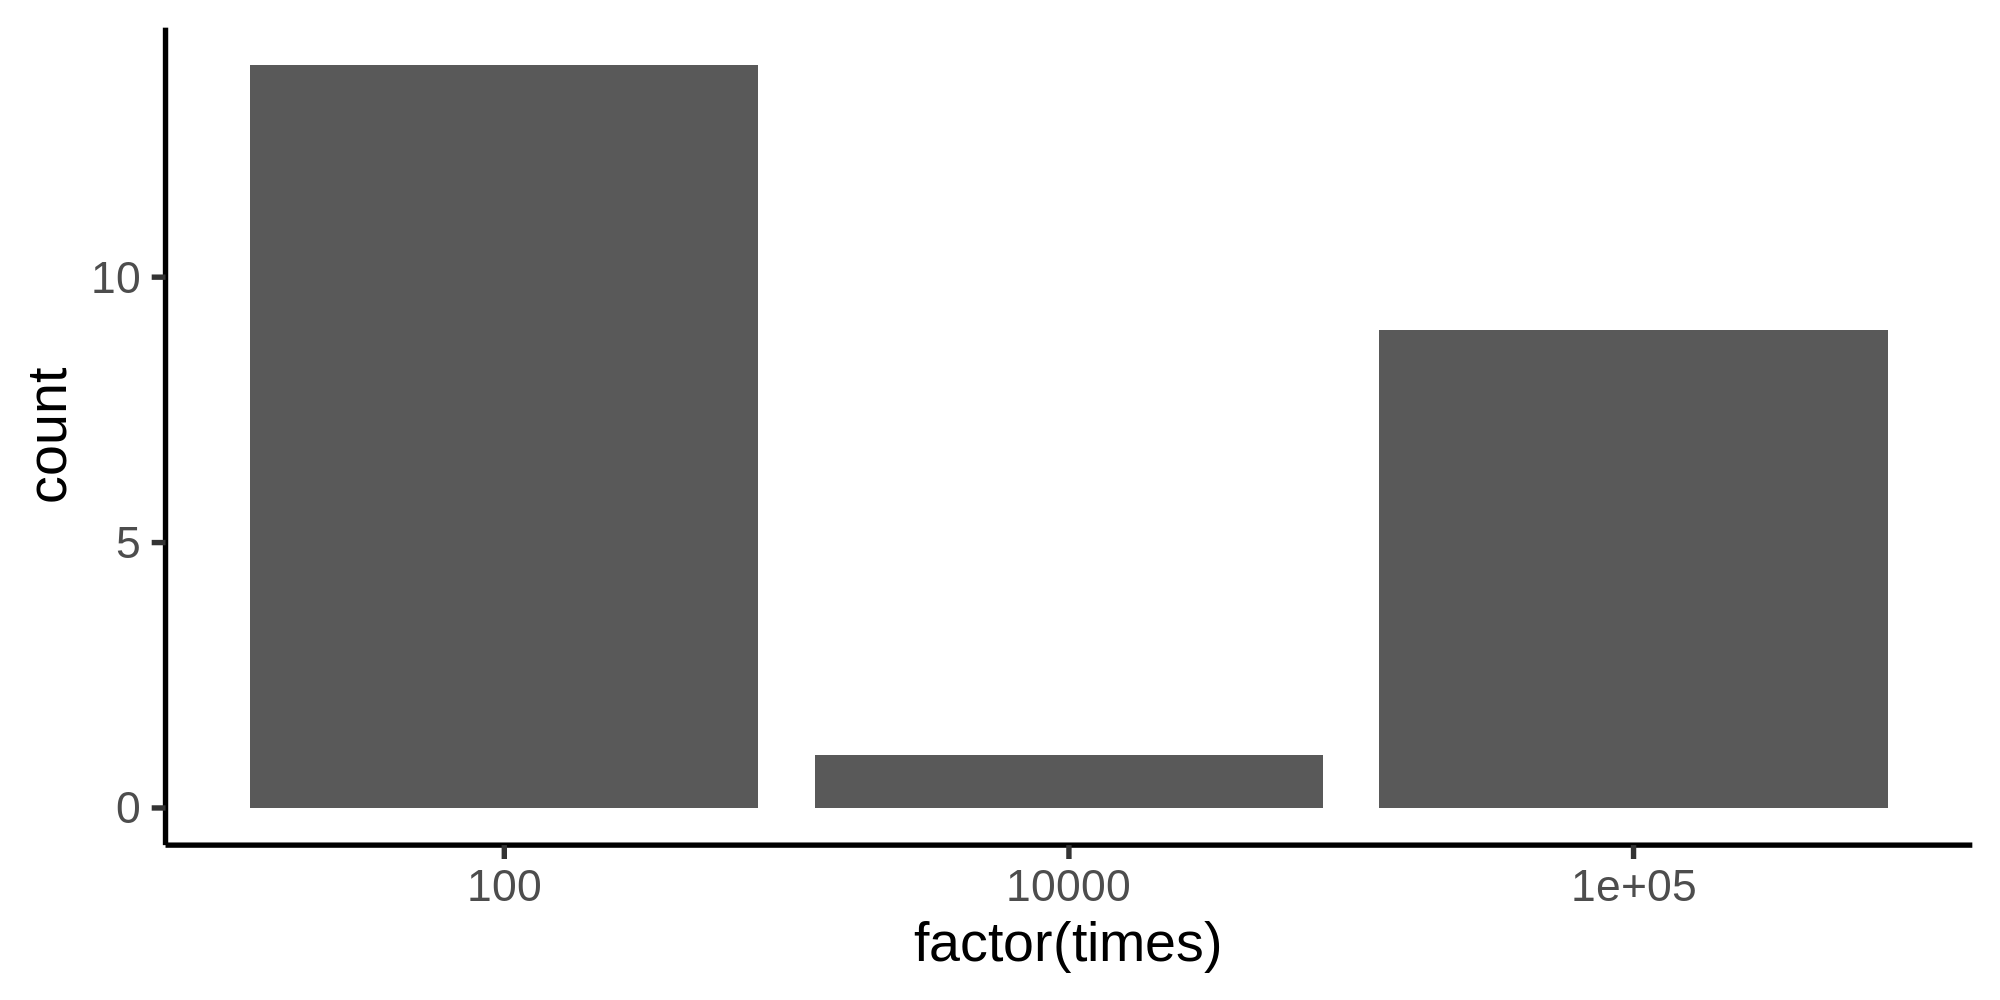

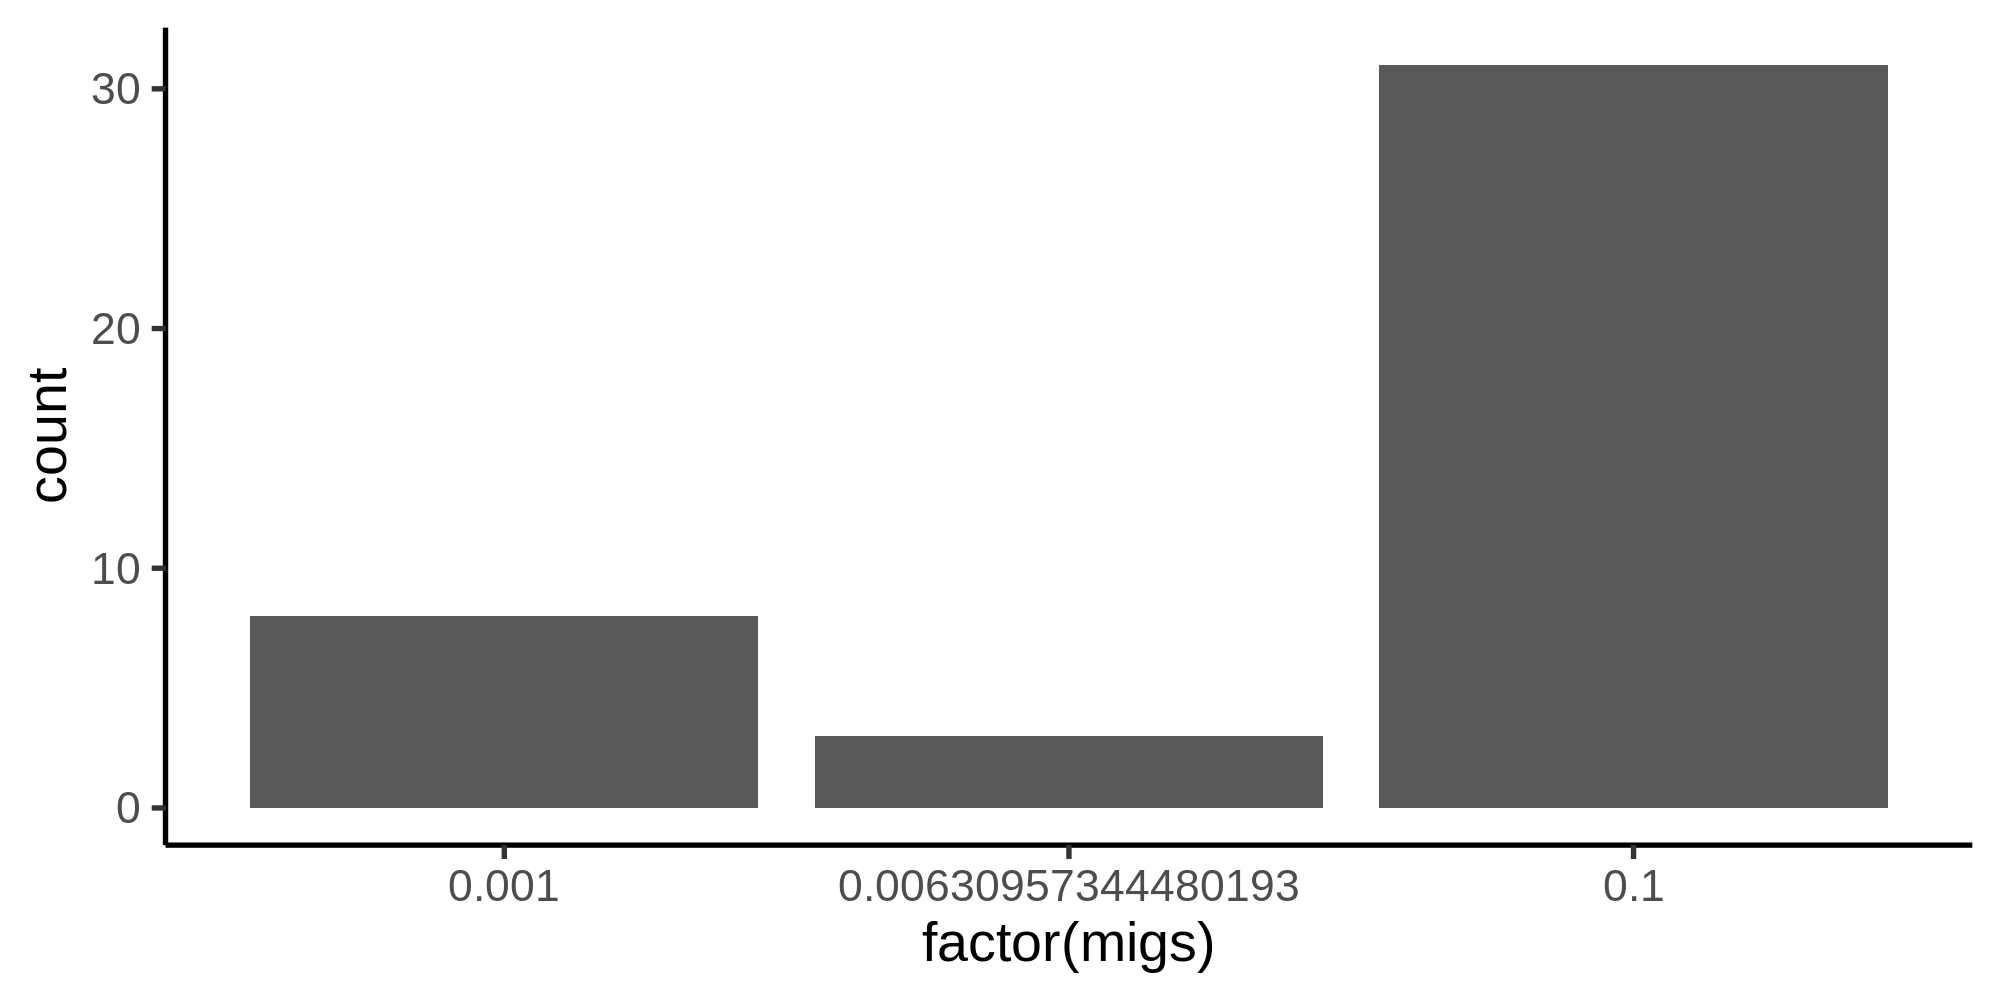

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”


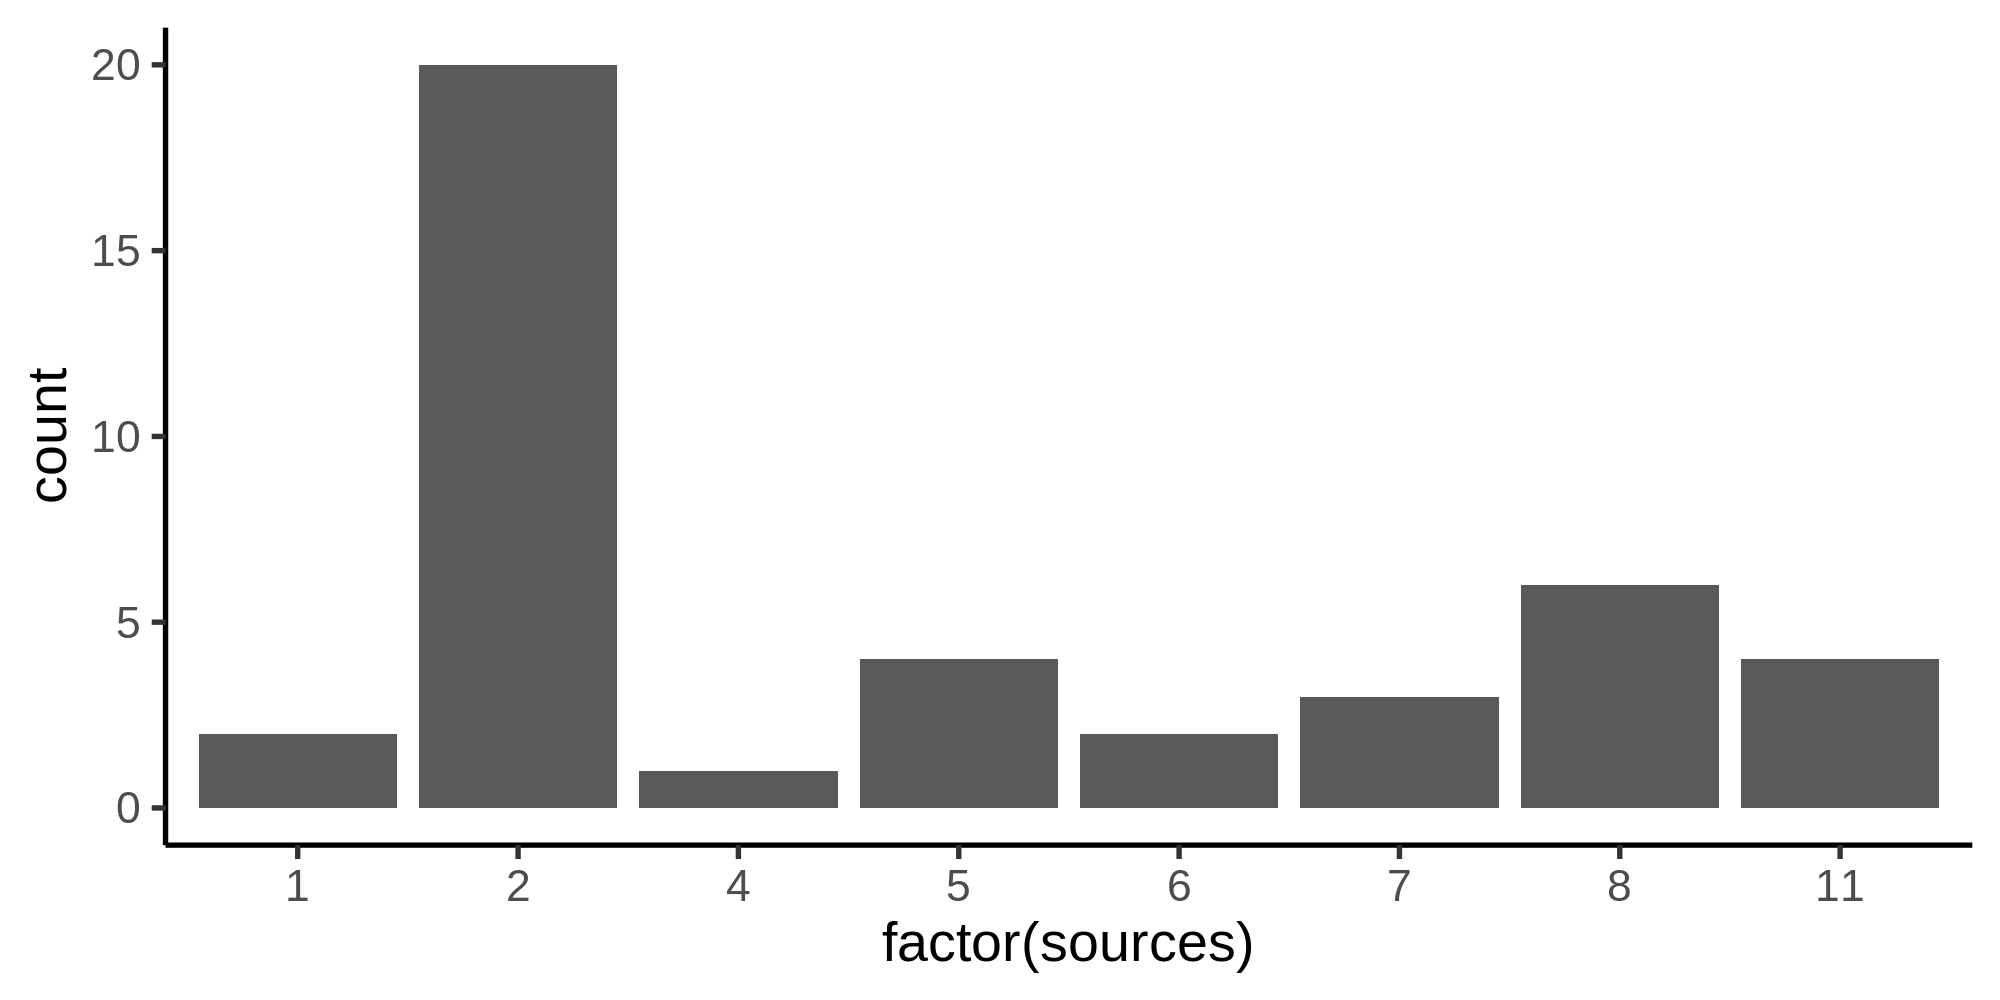

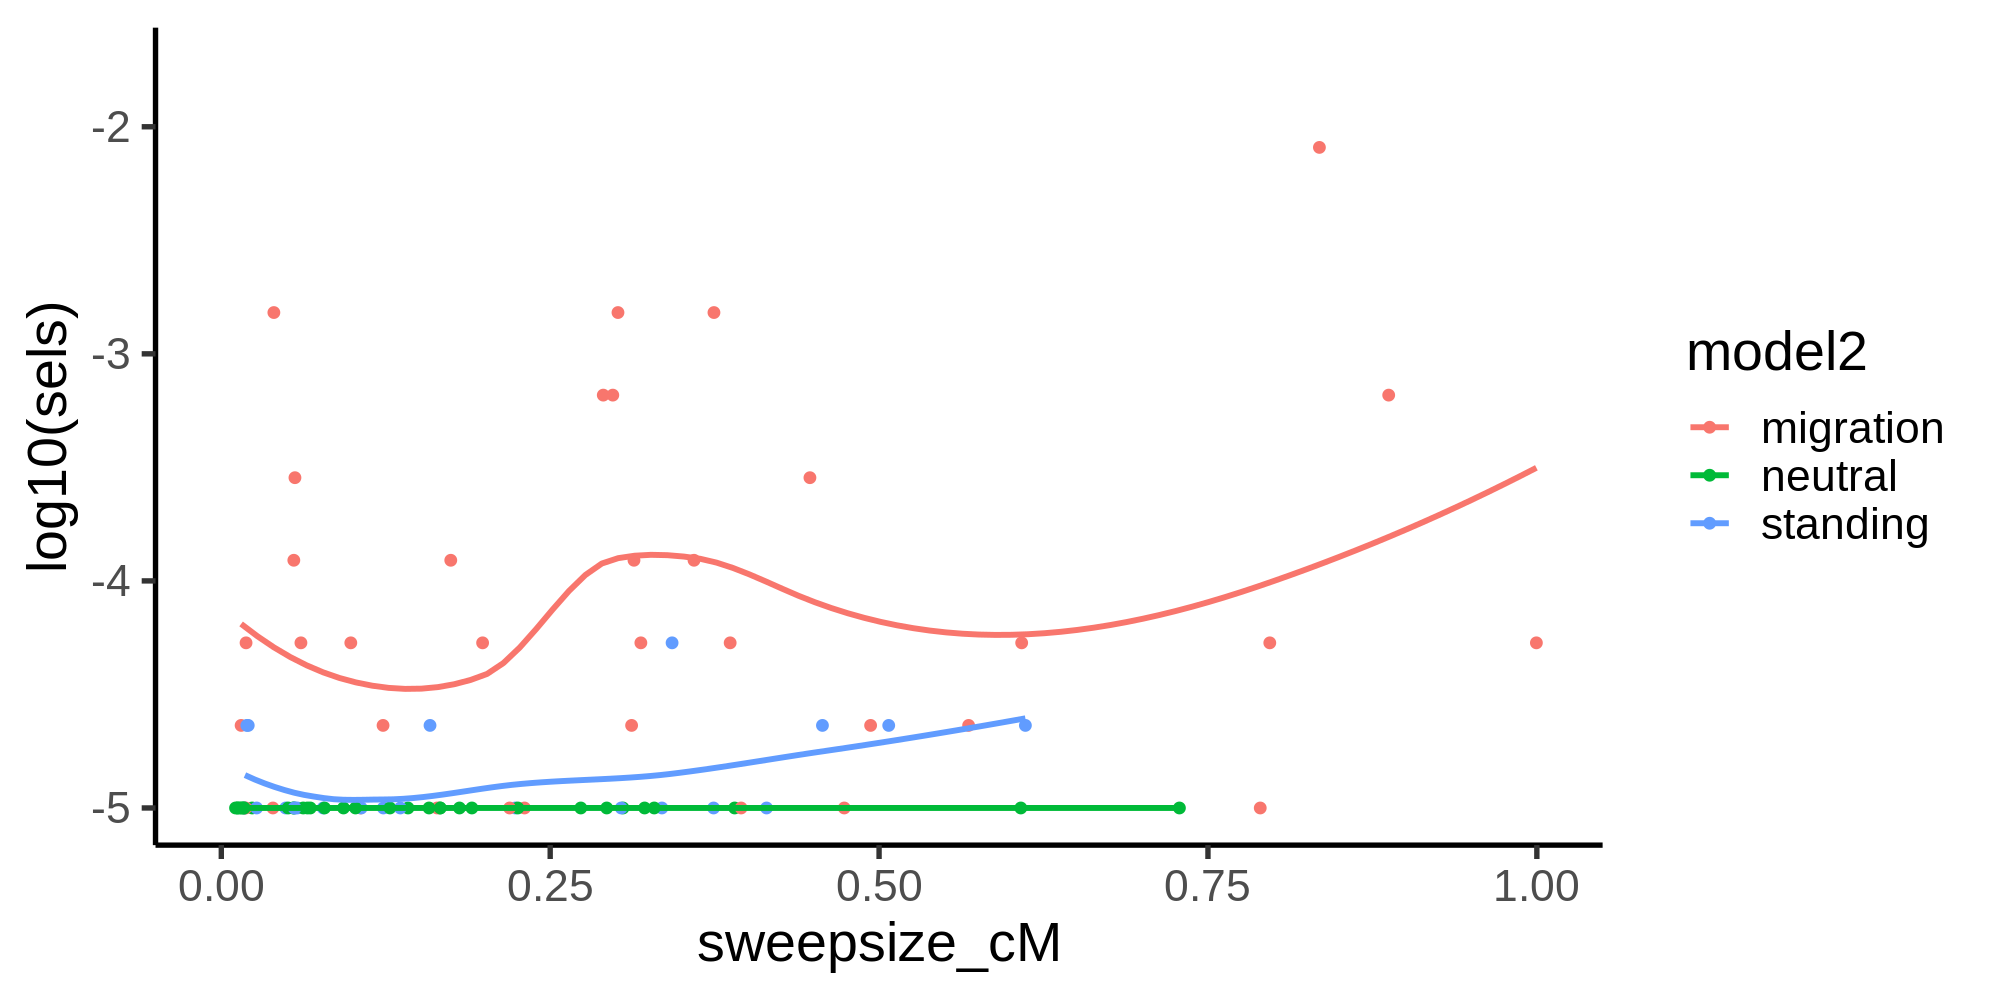

In [9]:


top_models_df %>%
    group_by(model2) %>% 
    summarise(n())

top_models_df %>% 
    ggplot(aes(model2, log10(sels))) +
    geom_jitter(width = 0.1, height = 0)

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(gs))) +
    geom_bar(stat = "count")

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(times))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(migs))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(sources))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 != "independent") %>% 
    ggplot(aes(sweepsize_cM, log10(sels), colour = model2)) +
    geom_point() +
    geom_smooth(se = F) +
    xlim(0, 1)


`geom_smooth()` using formula 'y ~ x'



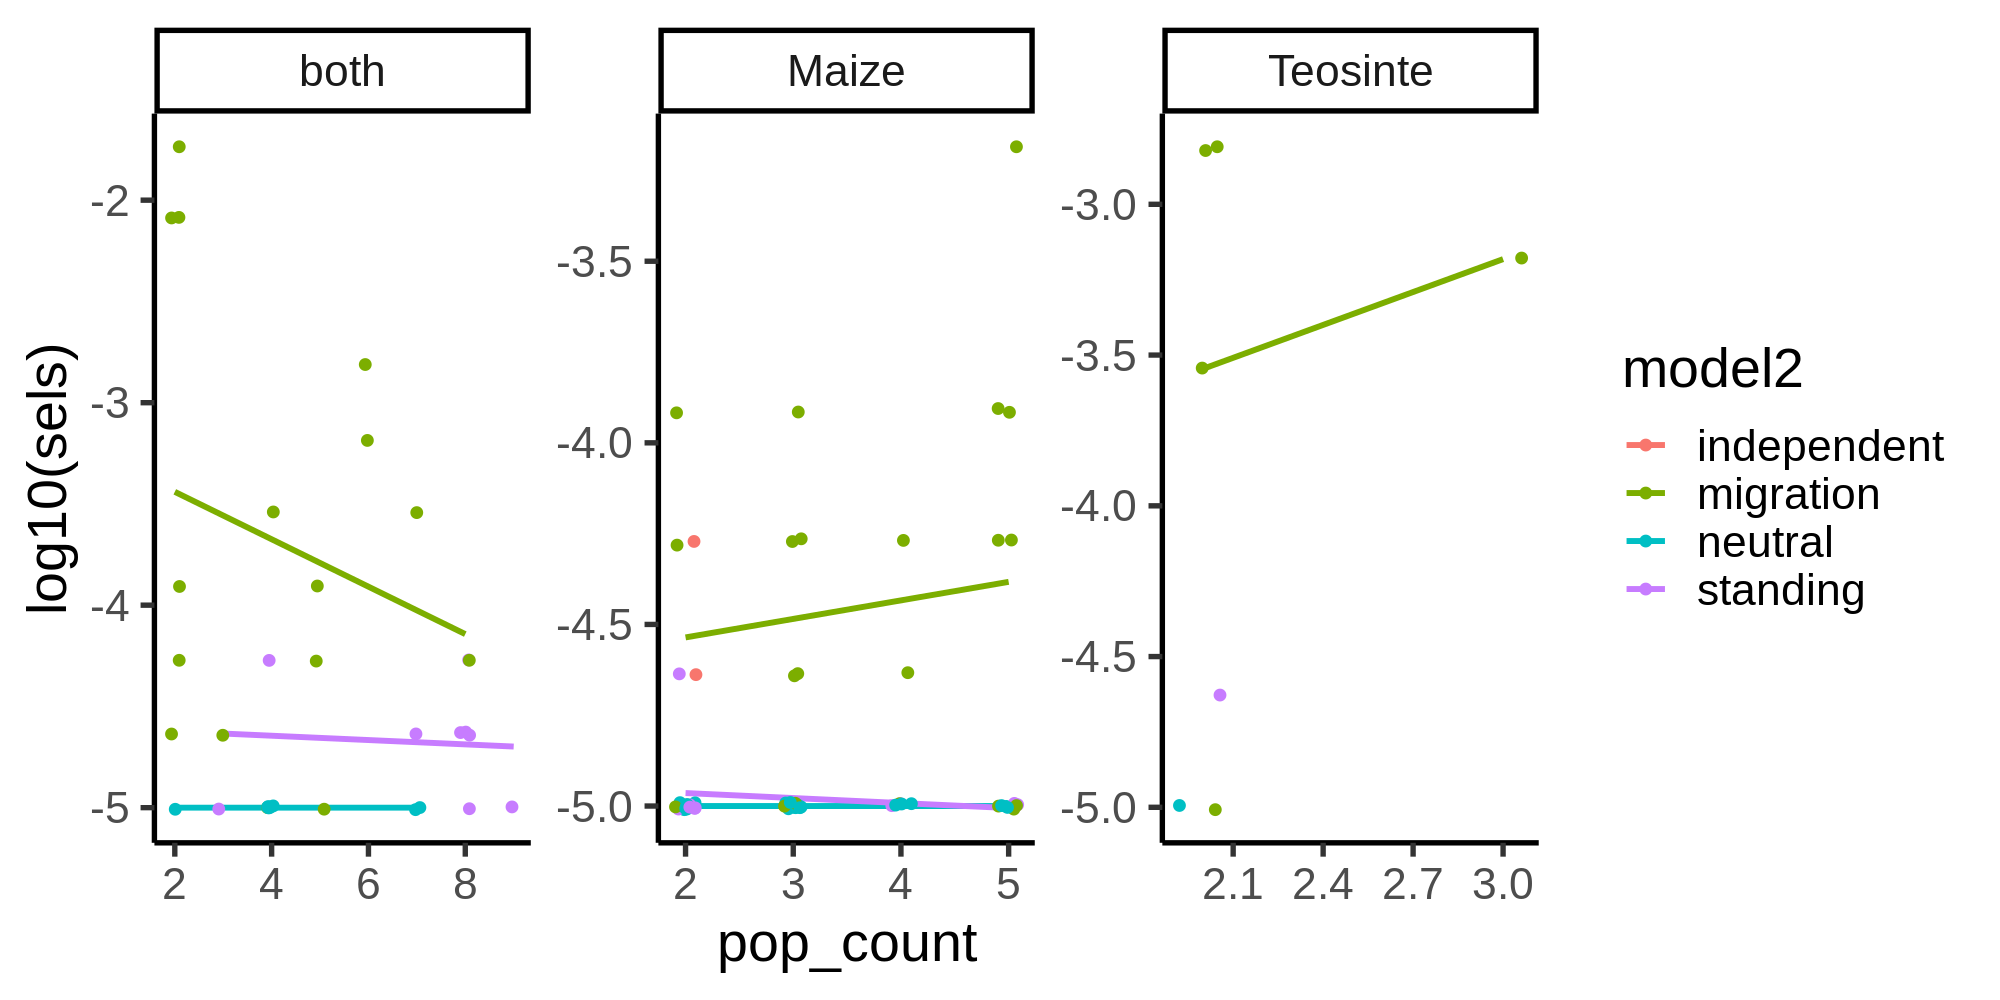

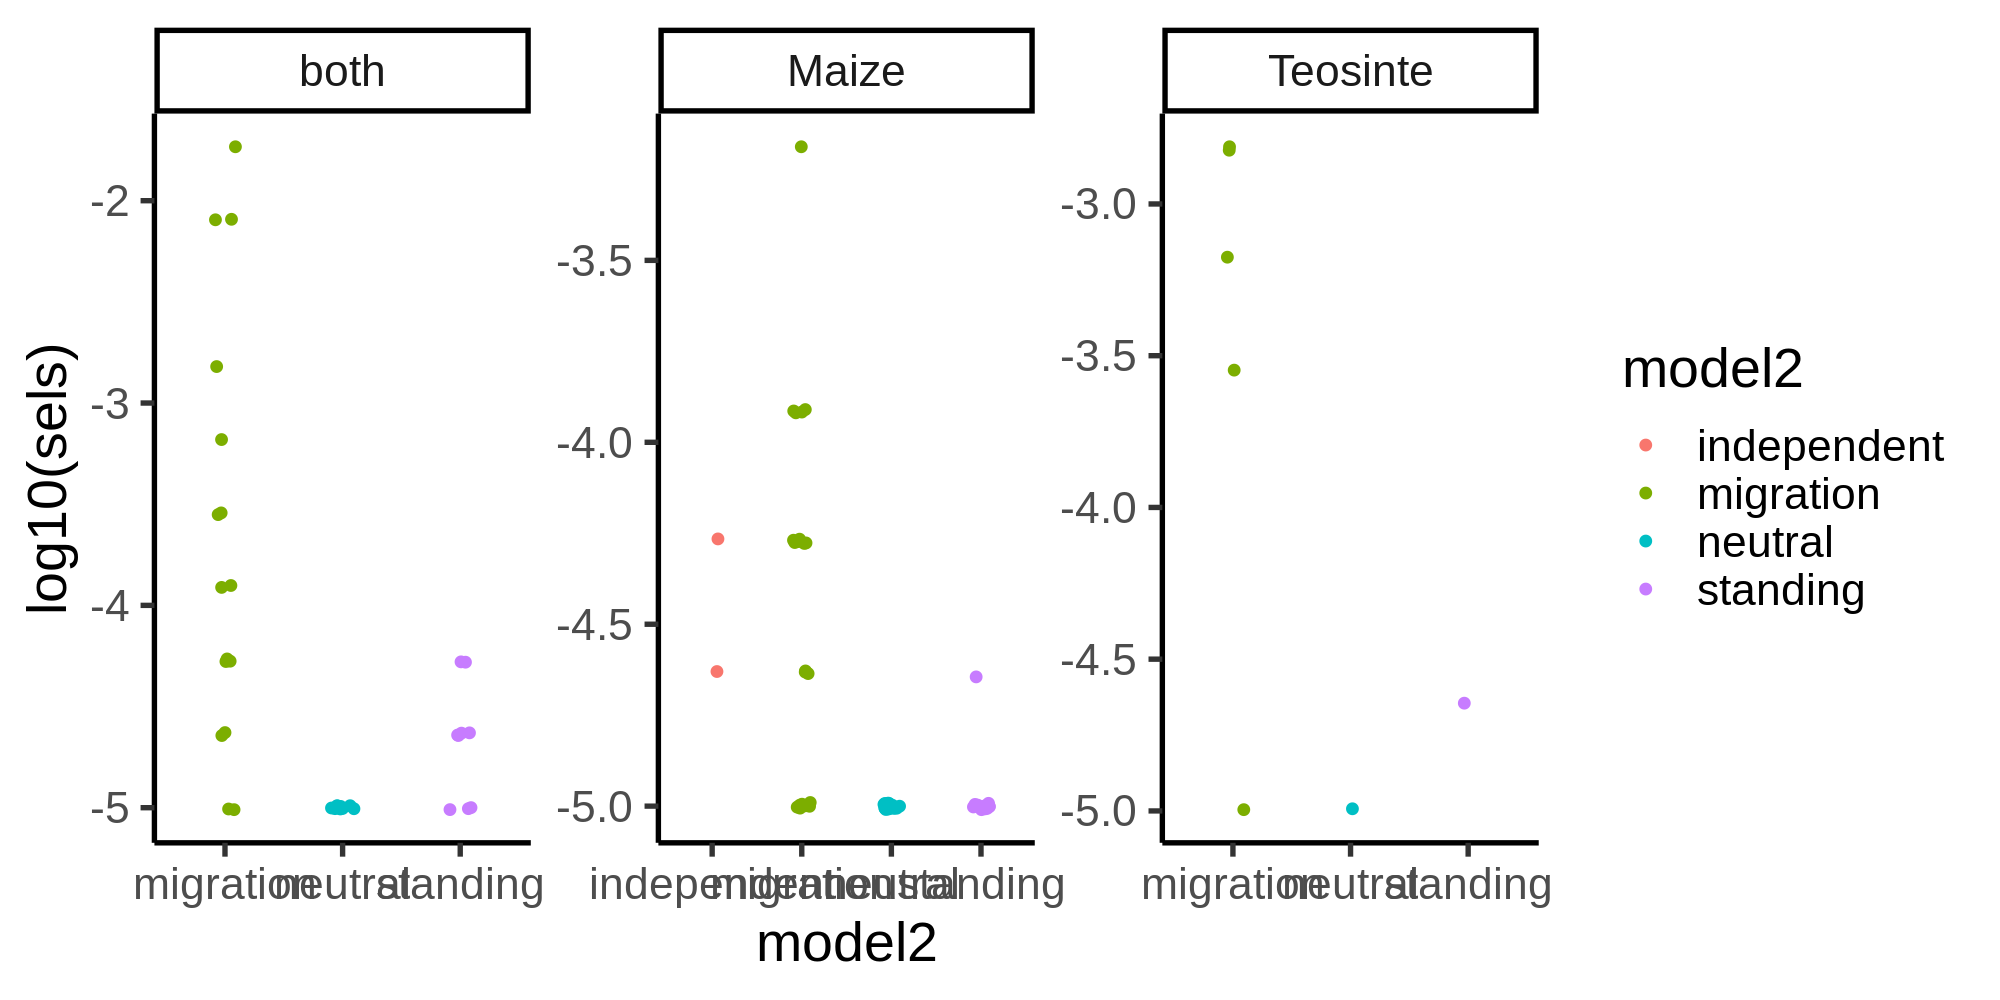

In [10]:
top_models_df %>%
    ggplot(aes(pop_count, log10(sels), colour = model2)) +
    geom_smooth(method = "lm", se = F) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")


top_models_df %>%
    ggplot(aes(model2, log10(sels), colour = model2)) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")

Warning message in cor.test.default(top_models_df$sweepsize_cM, top_models_df$n_snps, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  top_models_df$sweepsize_cM and top_models_df$n_snps
S = 53119, p-value = 2.828e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6996426 


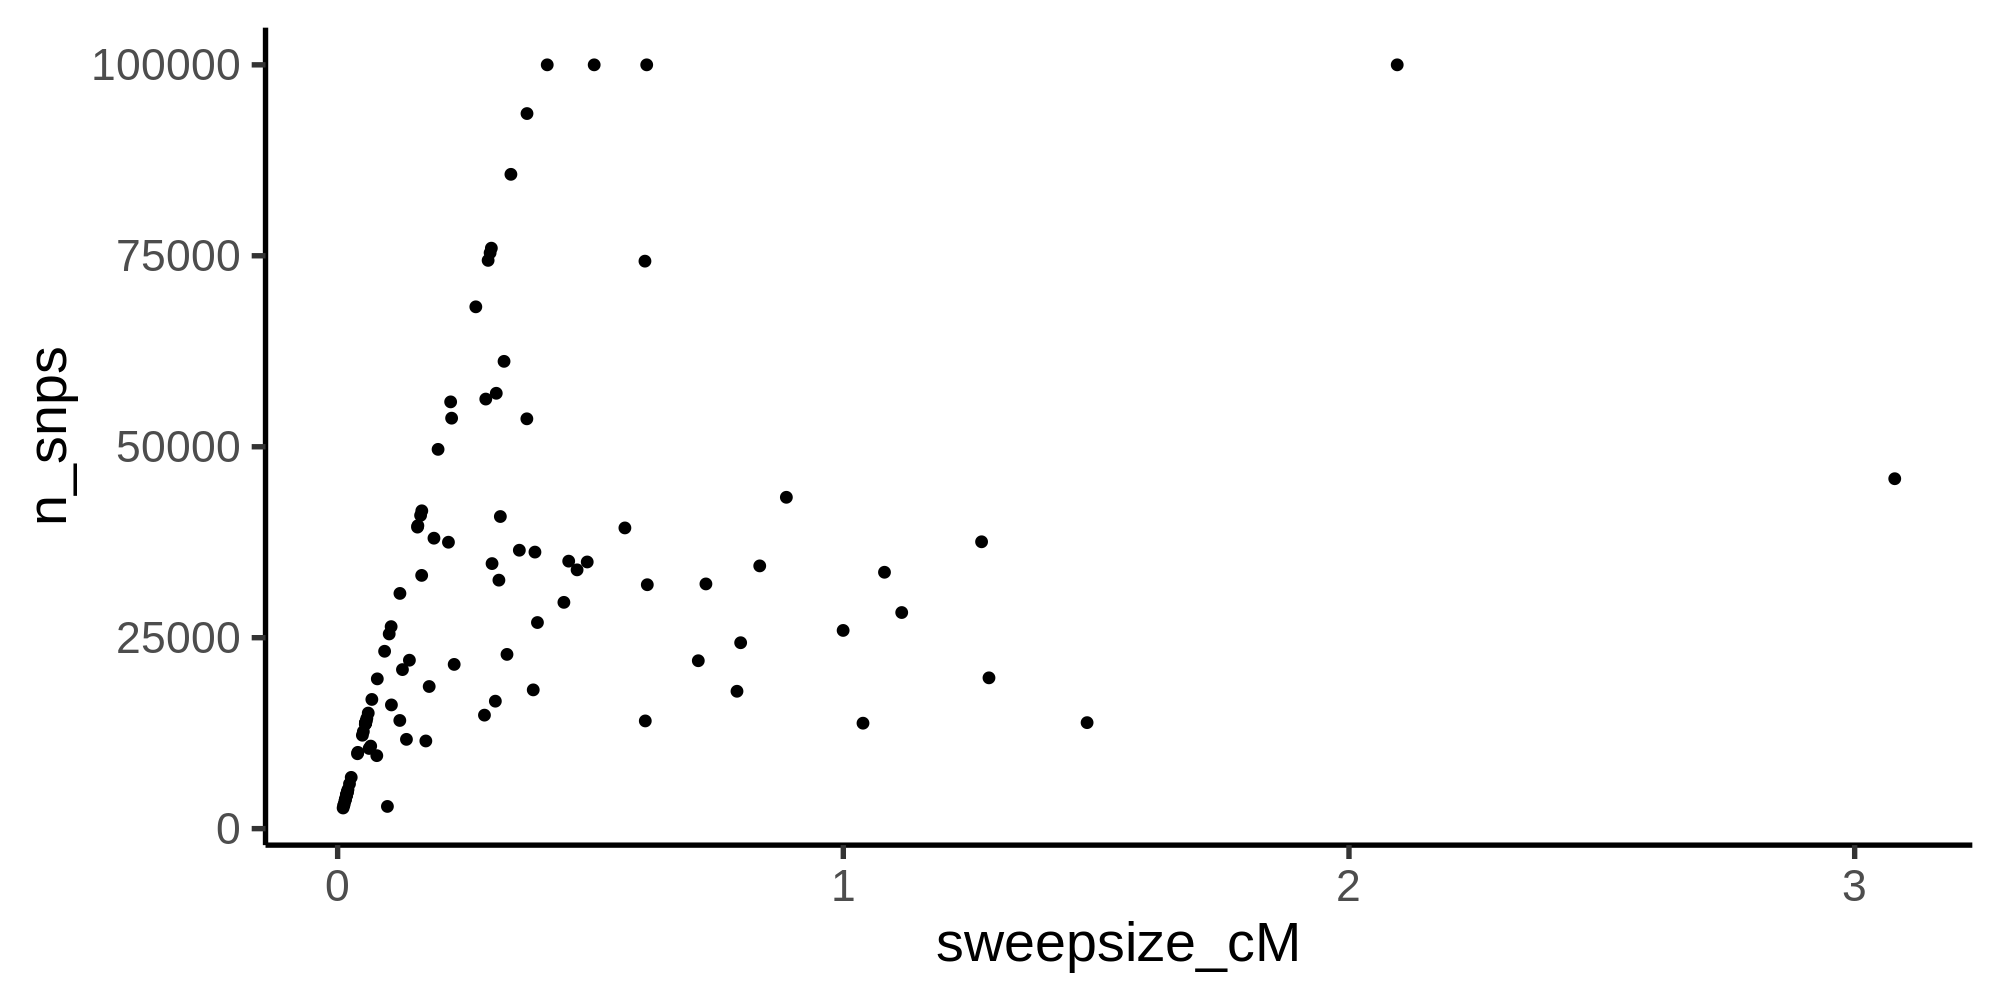

In [11]:
top_models_df %>% 
    ggplot(aes(sweepsize_cM, n_snps)) +
    geom_point()
    #geom_hline(yintercept = c(1e3, 1e4))

cor.test(top_models_df$sweepsize_cM, top_models_df$n_snps, method = "spear")

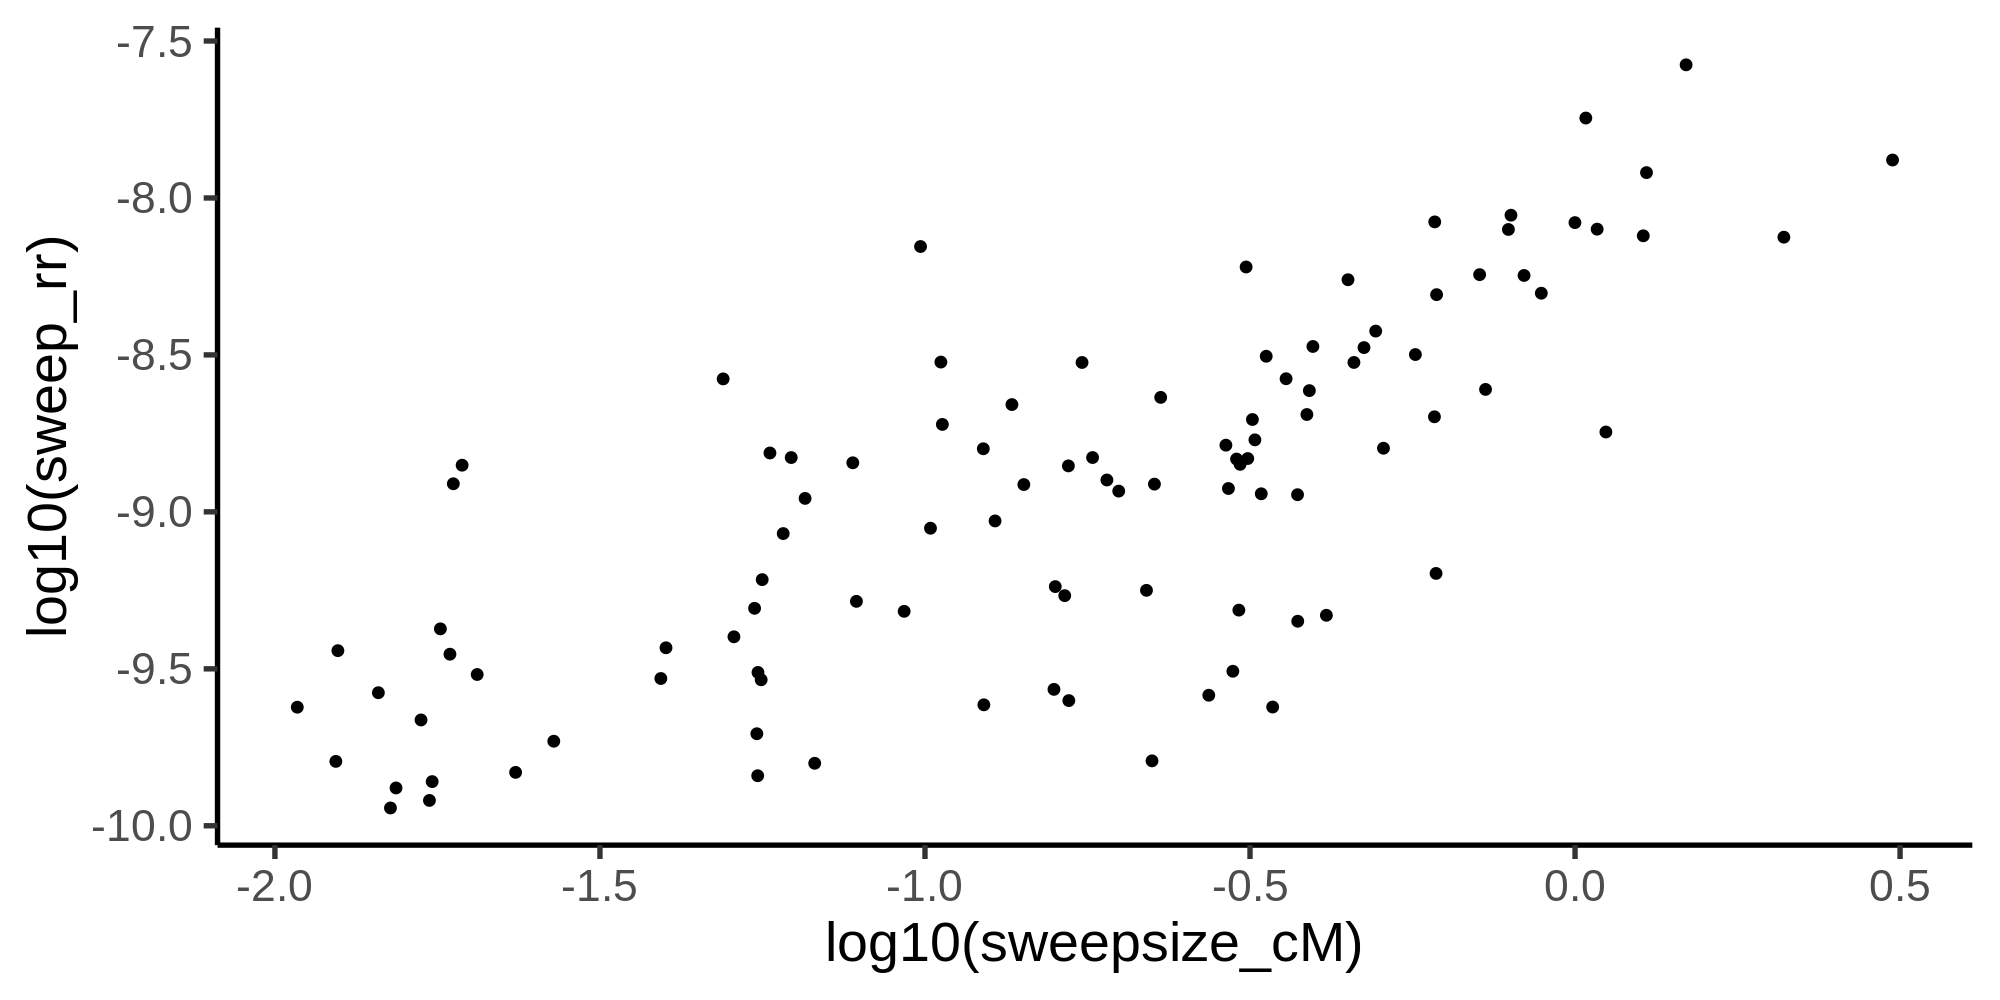

In [12]:
top_models_df %>% 
    ggplot(aes(log10(sweepsize_cM), log10(sweep_rr))) +
    geom_point()

[1] 2

[1] "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start115496539_end123583700_pops1-2-3-4-5-11.txt"
[2] "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start151279946_end153388433_pops8-11.txt"

[[1]]

[[2]]


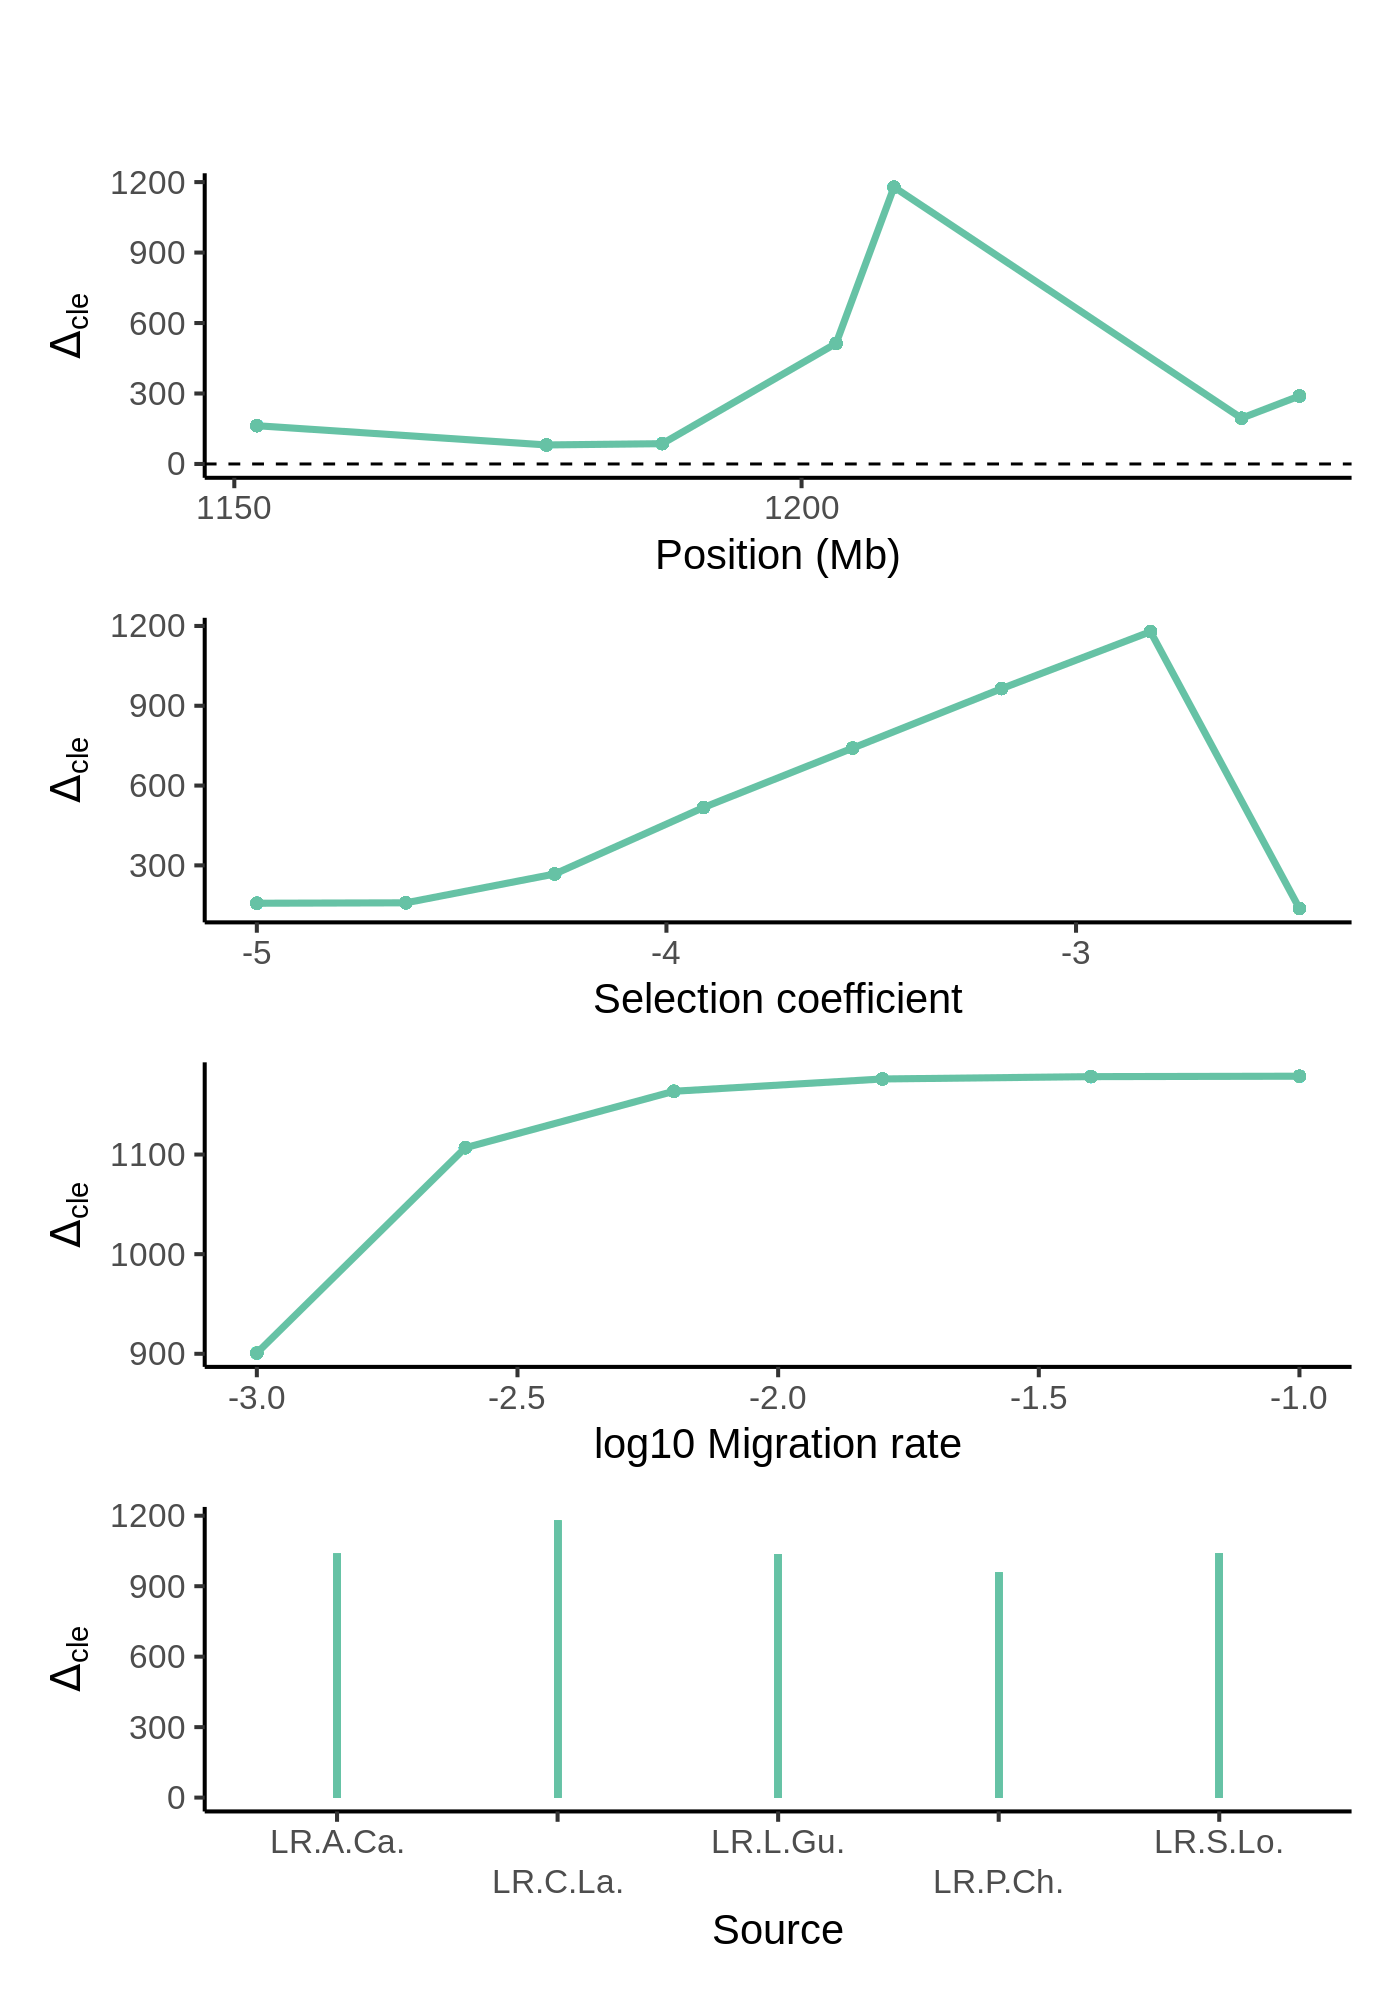

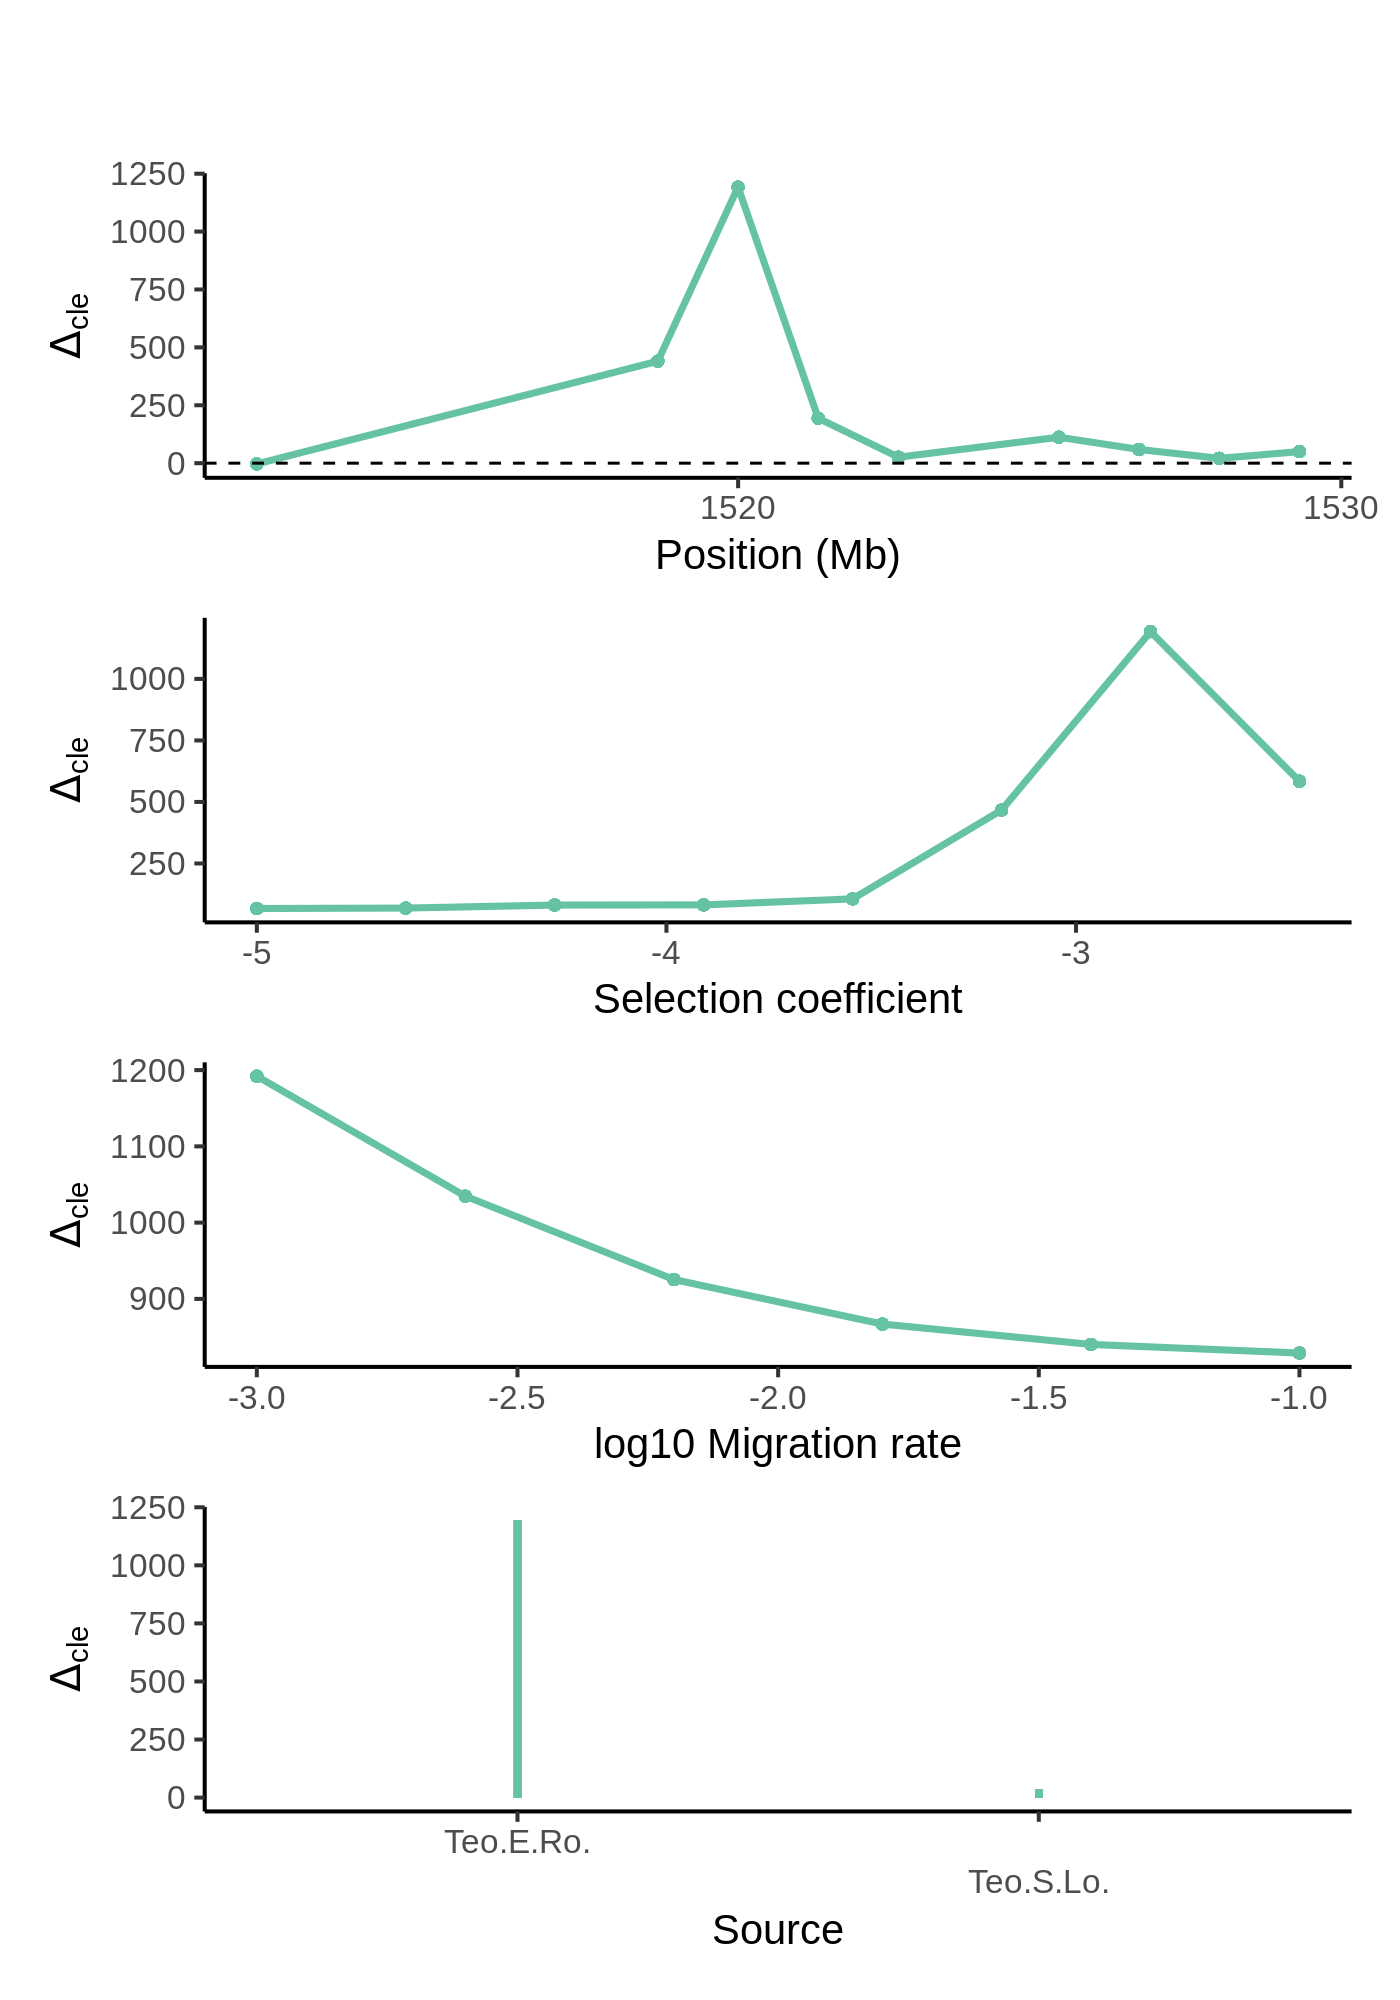

In [13]:
options(repr.plot.width = 7, repr.plot.height = 10 , repr.plot.res = 200)

lr_files <- top_models_df %>% filter(model2 != "neutral", sel_pops == "1-2-3-4-5", mcle > 10) %>% pull(file_name)

q_high <- quantile(top_models_df$mcle, 0.99)
top_files <- top_models_df %>% filter(model2 != "neutral", mcle > q_high) %>% pull(file_name)
length(top_files)
top_files
suppressMessages(map(top_files, ~ plot_rdmc(.x, cle_low = -5)))

`summarise()` has grouped output by 'pop_count', 'times'. You can override using the `.groups` argument.



selected_sites,sels,cle,locus,gs,times,migs,sources,sel_pops,model,⋯,mcle,mcle_delta,mcle_nextbest_diff,file_name,populations,type,pop_count,Landraces_count,Teosinte_count,model2
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
122794938,1.00000e-05,1055484.32,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start124589603_end142536910_pops1-2-3-4-5-6-9-10.txt,0.01584893,1e+02,NA,NA,1-2-3-4-5-6-9-10,standing,⋯,1.773178e+00,0,348.533571,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start124589603_end142536910_pops1-2-3-4-5-6-9-10.txt,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Amatlan_de_Canas; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico,both,8,5,3,standing
147480362,2.31013e-05,70582.38,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start146566362_end148100444_pops3-6.txt,NA,NA,0.001,6,3-6,migration,⋯,6.072291e+00,0,15.351444,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start146566362_end148100444_pops3-6.txt,v5--LR--Los_Guajes; v5--Teo--Amatlan_de_Canas,both,2,1,1,migration
155470437,1.00000e-05,654073.16,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start155142338_end157291991_pops1-4-5.txt,0.00100000,1e+02,NA,NA,1-4-5,standing,⋯,-1.396984e-09,0,3.769803,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start155142338_end157291991_pops1-4-5.txt,v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo,Maize,3,3,0,neutral
160483346,1.00000e-05,614005.95,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start160451568_end161685203_pops3-4-5.txt,0.00100000,1e+02,NA,NA,3-4-5,standing,⋯,-4.792202e-05,0,44.609422,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start160451568_end161685203_pops3-4-5.txt,v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo,Maize,3,3,0,neutral
171047357,1.00000e-05,436162.73,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start170885113_end171953932_pops3-4.txt,0.00100000,1e+05,NA,NA,3-4,standing,⋯,1.698229e-01,0,3.343118,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start170885113_end171953932_pops3-4.txt,v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico,Maize,2,2,0,standing
101312825,2.31013e-05,307380.50,data/rdmc/sweep_freq/v5--sweep--chr10--0--152435371_start101291980_end102090436_pops1-2-3-4.txt,NA,NA,0.100,2,1-2-3-4,migration,⋯,3.490472e+00,0,2.092342,../data/rdmc/fitted/v5--sweep_chr10--0--152435371_start101291980_end102090436_pops1-2-3-4.txt,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico,Maize,4,4,0,migration


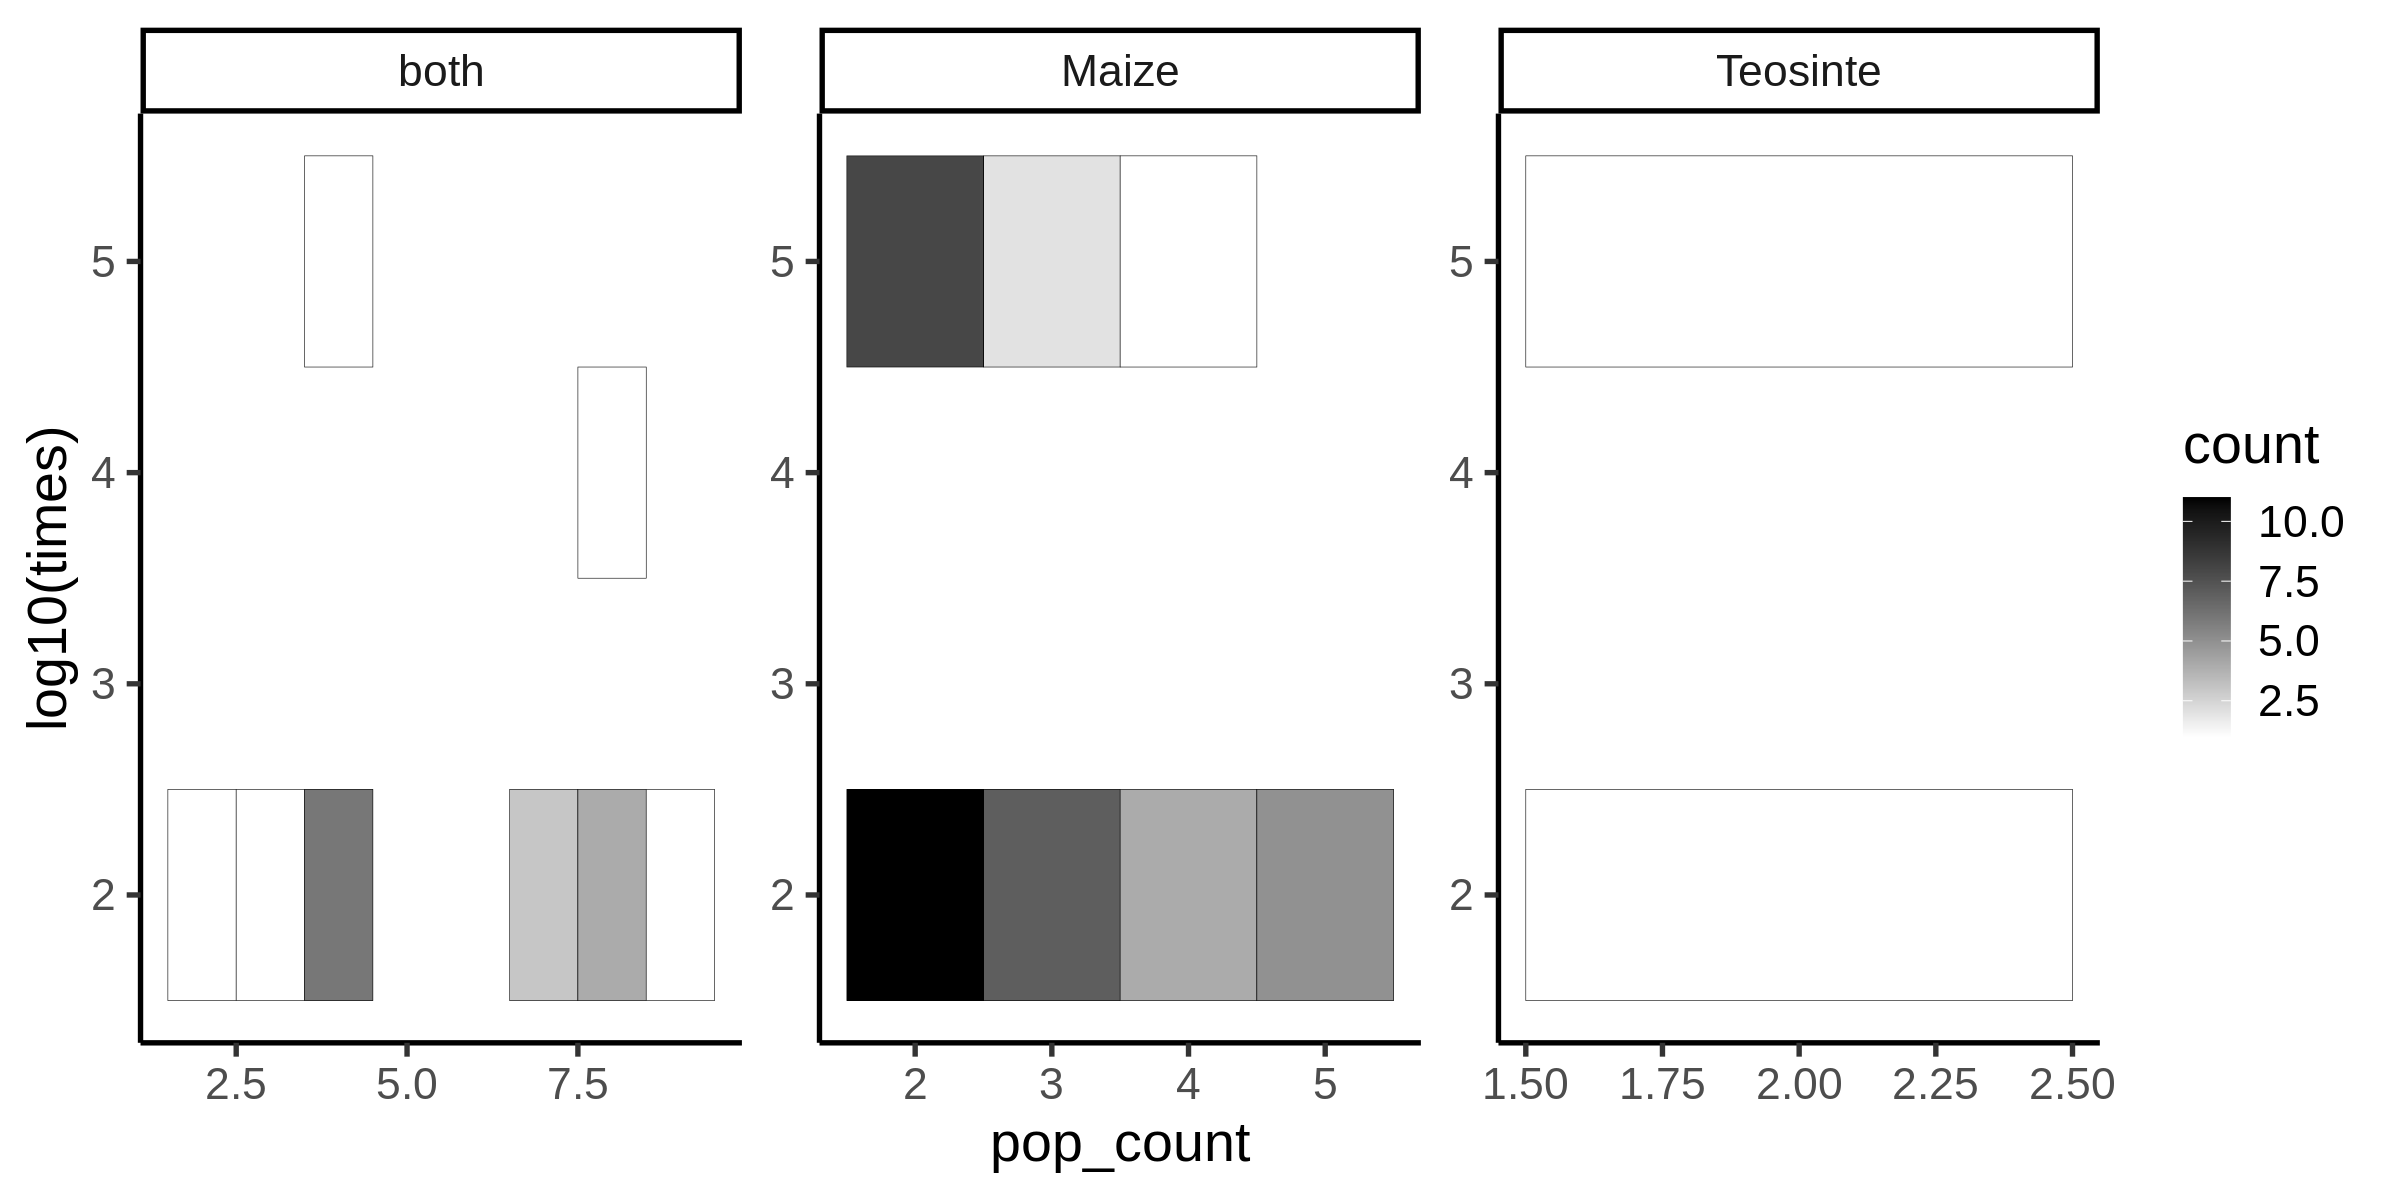

In [14]:
options(repr.plot.width = 12, repr.plot.height = 6 , repr.plot.res = 200)

top_models_df %>% 
    select(pop_count, times, type) %>% 
    drop_na() %>% 
    group_by(pop_count, times, type) %>% 
    summarise(count = n()) %>% 
    ggplot(aes(pop_count, log10(times), fill = count)) +
    geom_tile(color = "black") +
    facet_wrap(~type, scales = "free") +
    scale_fill_gradient(low = "white", high = "black")

head(top_models_df)

# FIGURE 5

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



type,model2,n()
<chr>,<chr>,<int>
both,migration,16
both,neutral,9
both,standing,9
Maize,independent,2
Maize,migration,21
Maize,neutral,24
Maize,standing,14
Teosinte,migration,5
Teosinte,neutral,1


,model2,n()
,<chr>,<int>
1,independent,2
2,migration,42
3,neutral,34
4,standing,24


[1] 102

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



[1] "HERE!"


selected_sites,sels,cle,locus,gs,times,migs,sources,sel_pops,model,⋯,mcle,mcle_delta,mcle_nextbest_diff,file_name,populations,type,pop_count,Landraces_count,Teosinte_count,model2
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
122794938,1.00000e-05,1055484.32,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start124589603_end142536910_pops1-2-3-4-5-6-9-10.txt,0.01584893,1e+02,NA,NA,1-2-3-4-5-6-9-10,standing,⋯,1.773178e+00,0,348.533571,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start124589603_end142536910_pops1-2-3-4-5-6-9-10.txt,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Amatlan_de_Canas; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico,both,8,5,3,standing
147480362,2.31013e-05,70582.38,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start146566362_end148100444_pops3-6.txt,NA,NA,0.001,6,3-6,migration,⋯,6.072291e+00,0,15.351444,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start146566362_end148100444_pops3-6.txt,v5--LR--Los_Guajes; v5--Teo--Amatlan_de_Canas,both,2,1,1,migration
155470437,1.00000e-05,654073.16,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start155142338_end157291991_pops1-4-5.txt,0.00100000,1e+02,NA,NA,1-4-5,standing,⋯,-1.396984e-09,0,3.769803,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start155142338_end157291991_pops1-4-5.txt,v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo,Maize,3,3,0,neutral
160483346,1.00000e-05,614005.95,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start160451568_end161685203_pops3-4-5.txt,0.00100000,1e+02,NA,NA,3-4-5,standing,⋯,-4.792202e-05,0,44.609422,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start160451568_end161685203_pops3-4-5.txt,v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo,Maize,3,3,0,neutral
171047357,1.00000e-05,436162.73,data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start170885113_end171953932_pops3-4.txt,0.00100000,1e+05,NA,NA,3-4,standing,⋯,1.698229e-01,0,3.343118,../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start170885113_end171953932_pops3-4.txt,v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico,Maize,2,2,0,standing
101312825,2.31013e-05,307380.50,data/rdmc/sweep_freq/v5--sweep--chr10--0--152435371_start101291980_end102090436_pops1-2-3-4.txt,NA,NA,0.100,2,1-2-3-4,migration,⋯,3.490472e+00,0,2.092342,../data/rdmc/fitted/v5--sweep_chr10--0--152435371_start101291980_end102090436_pops1-2-3-4.txt,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico,Maize,4,4,0,migration


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


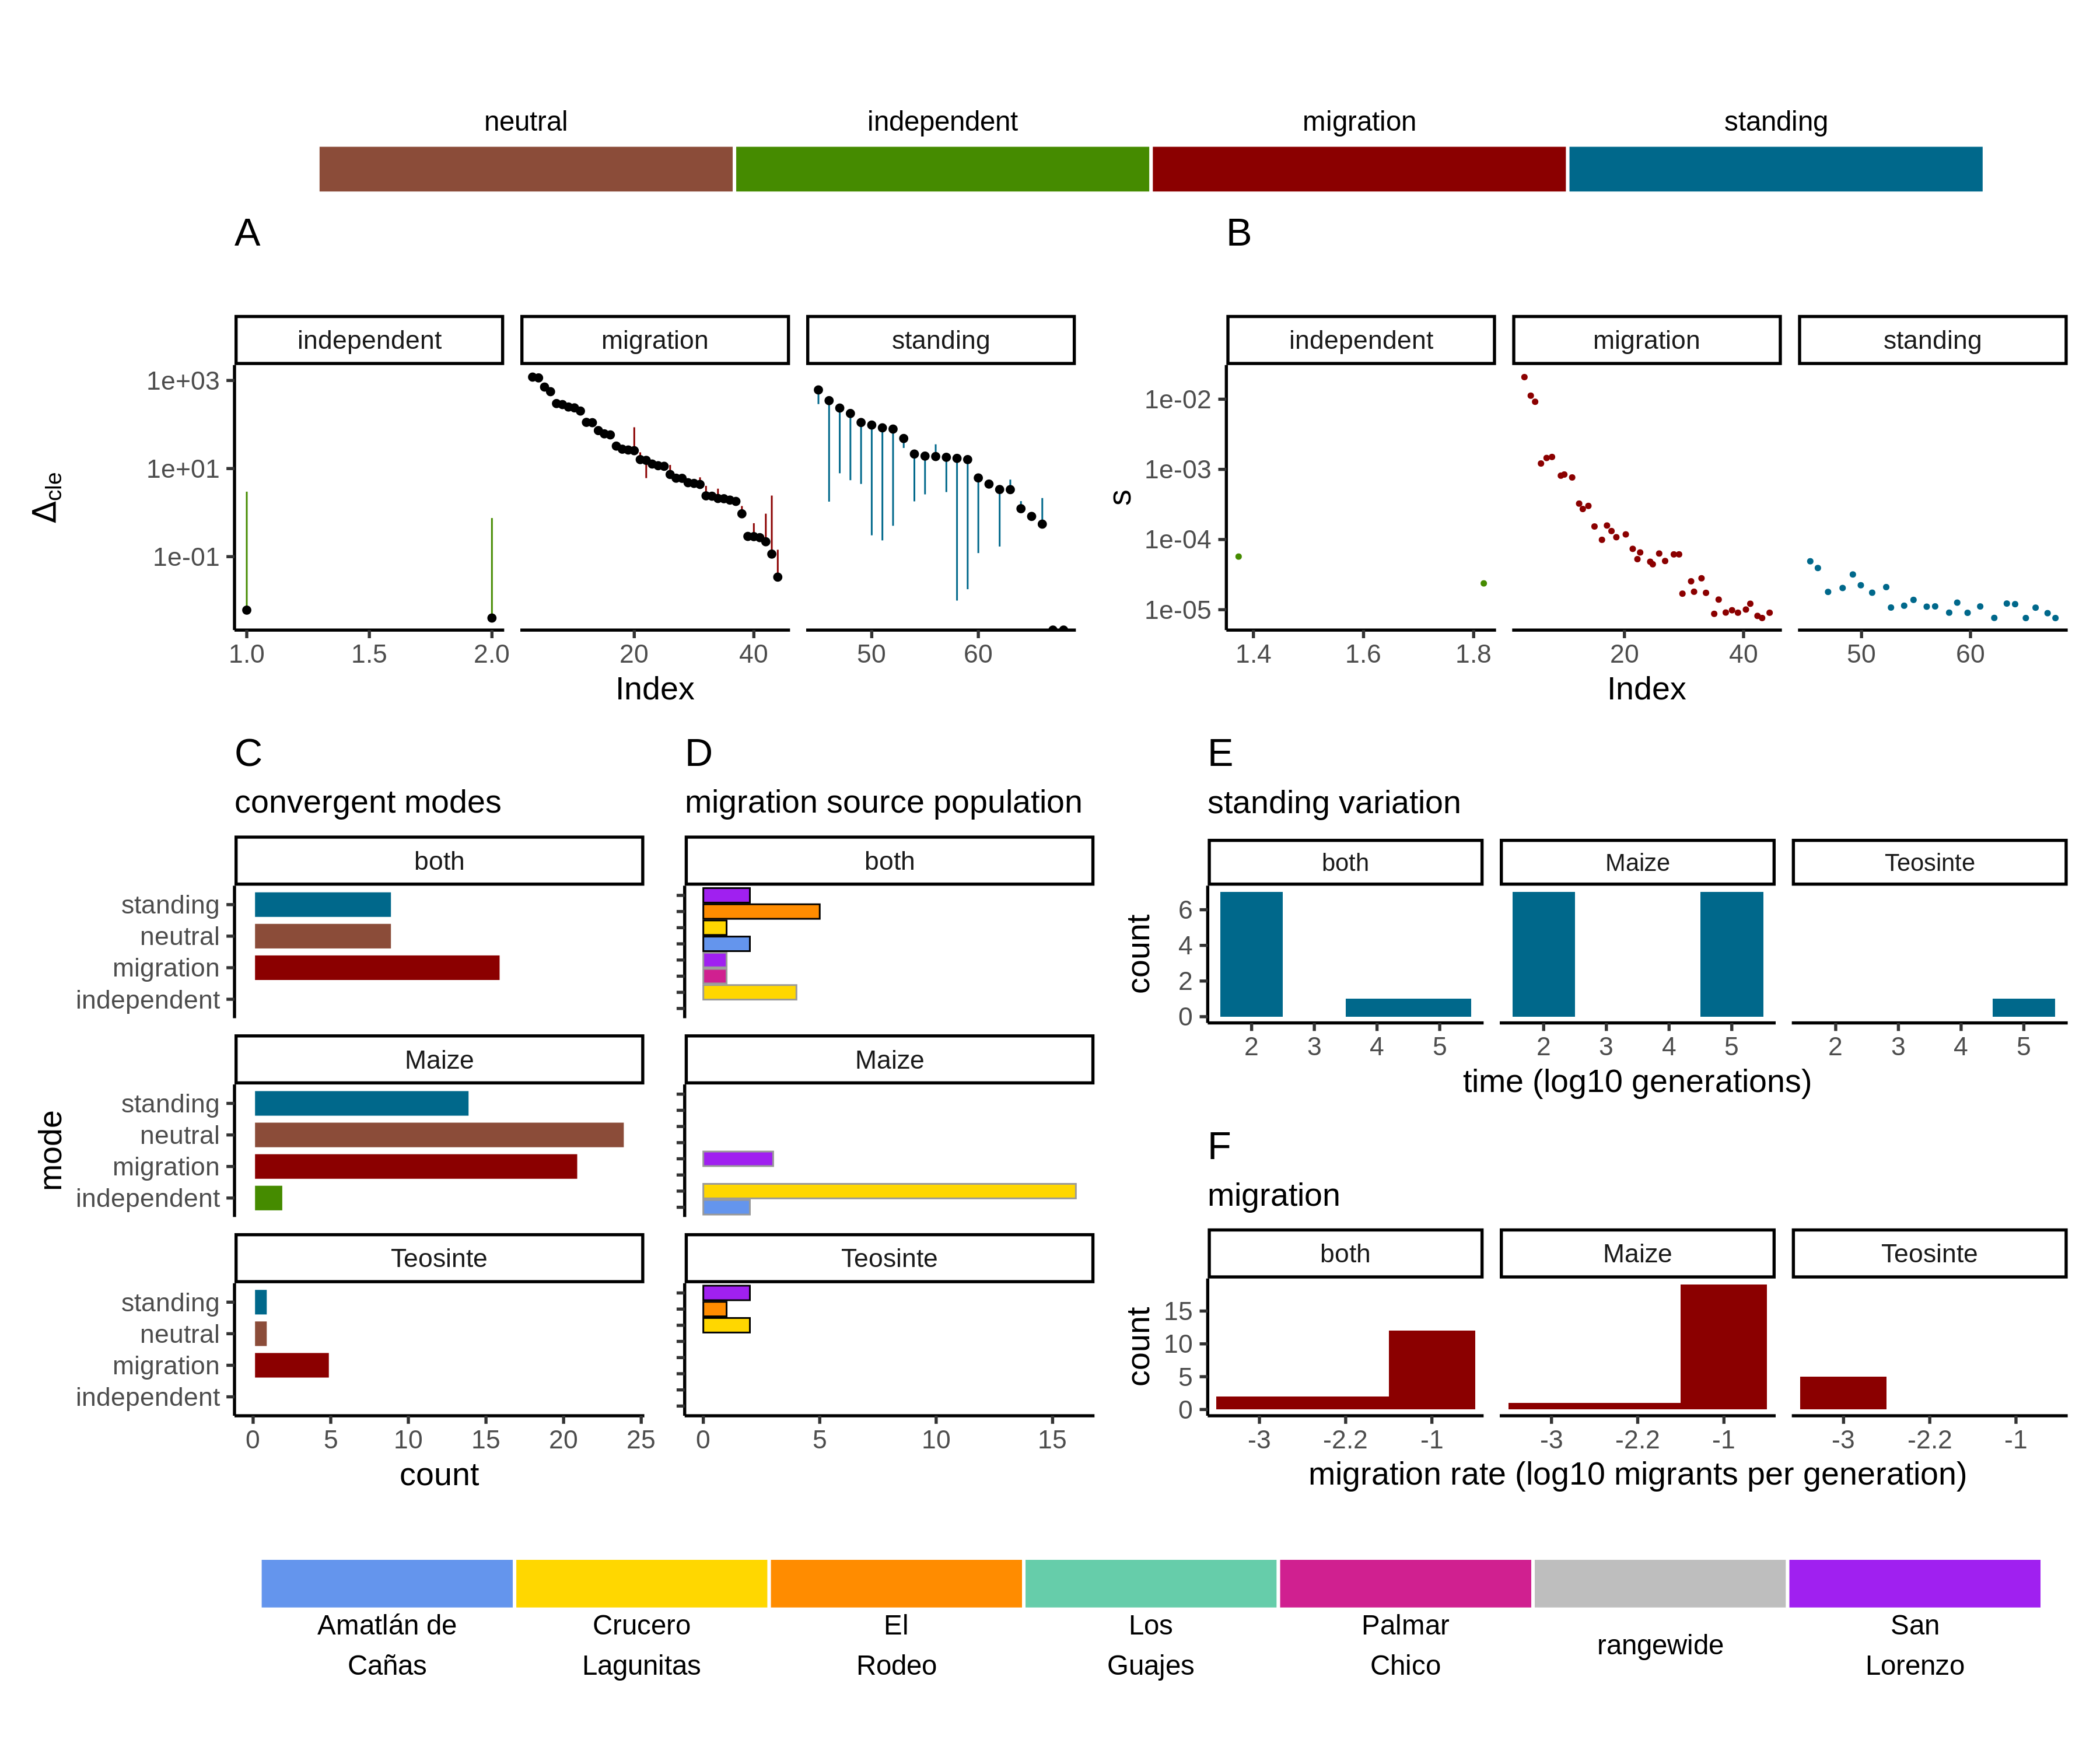

In [15]:

#color_format_df <- color_df %>% 
#    mutate(pop = str_replace_all(pop, "LR_", "Landrace ")) %>% 
#    mutate(pop = str_replace_all(pop, "Teo_", "Teosinte ")) %>% 
#    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
#    mutate(pop = str_remove_all(pop, "random([12])"))


color_format_df <- color_df %>% 
    mutate(pop = str_replace_all(pop, "LR_", "")) %>% 
    mutate(pop = str_replace_all(pop, "Teo_", "")) %>% 
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = str_remove_all(pop, "random([12])"))


FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(n())

top_models_df %>% 
    group_by(model2) %>% 
    summarise(n())

nrow(top_models_df)

mode_plot <- top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(counts = n()) %>% 
    ggplot(aes(model2, counts, fill = model2)) + 
    geom_bar(stat = "identity", lwd = 1.1, colour = "white") +
    facet_wrap(~type, scale = "fixed", ncol = 1) +
    coord_flip() +
    ylab("count") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small)) +
    xlab("mode")


print("HERE!")
head(top_models_df)

src_df  <-  
top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(ssp_id = ifelse(grepl("Landrace", pop_id), "Landrace", "Teosinte")) %>% 
    mutate(pop_id2 = pop_id) %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop")) %>% 
    filter(!is.na(type))

source_plot <- 
src_df  %>%
    ggplot(aes(pop_id2, fill = color, colour = ssp_id)) +
    geom_bar(stat = "count", position = position_dodge(preserve = "single"), lwd = 0.5) +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "fixed", ncol = 1, drop = FALSE) +
    scale_x_discrete(drop=FALSE) +
    coord_flip() +
    scale_fill_identity() +
    scale_color_manual(values = c("Teosinte" = "black", "Landrace" = "grey60")) +
    theme( 
        strip.text.x = element_text(size = tts_small),
        legend.position = "n",
        axis.title = element_blank(),
        axis.text.y = element_blank()
    )


time_plot <- top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(log10(times), fill = model2)) +
    geom_bar(stat = "count", width = 1) +
    ylab("count") +
    xlab("time (log10 generations)") +
    facet_wrap(~type, scale = "fixed") +
    scale_fill_manual(values = sel_cols) +
    theme(strip.text.x = element_text(size = tts_small-1)) +
    theme(legend.position = "n")


mig_plot <- top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(log10(migs)), fill = model)) +
    geom_bar(stat = "count", width = 1) +
    ylab("count") +
    xlab("migration rate (log10 migrants per generation)") +
    facet_wrap(~type, scale = "fixed") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small))


options(repr.plot.width = 18, repr.plot.height = 15, repr.plot.res = 200)

mode_leg(size = 6, nud = 1) /
(((mode_mcle + ggtitle(label = "A", subtitle = "")) +
 (mode_sels + ggtitle(label = "B", subtitle = "")))) / 
((mode_plot + ggtitle("C", subtitle = "convergent modes") + source_plot + ggtitle("D", subtitle = "migration source population")) | 
( (time_plot + ggtitle("E", subtitle = "standing variation")) / (mig_plot + ggtitle("F", subtitle = "migration")))) /
 make_legplot(text_size = 6) +
plot_layout(nrow = 4, heights = c(7,10,20,7))
ggsave("../figures/Figure5.pdf", width = 18, height = 15)


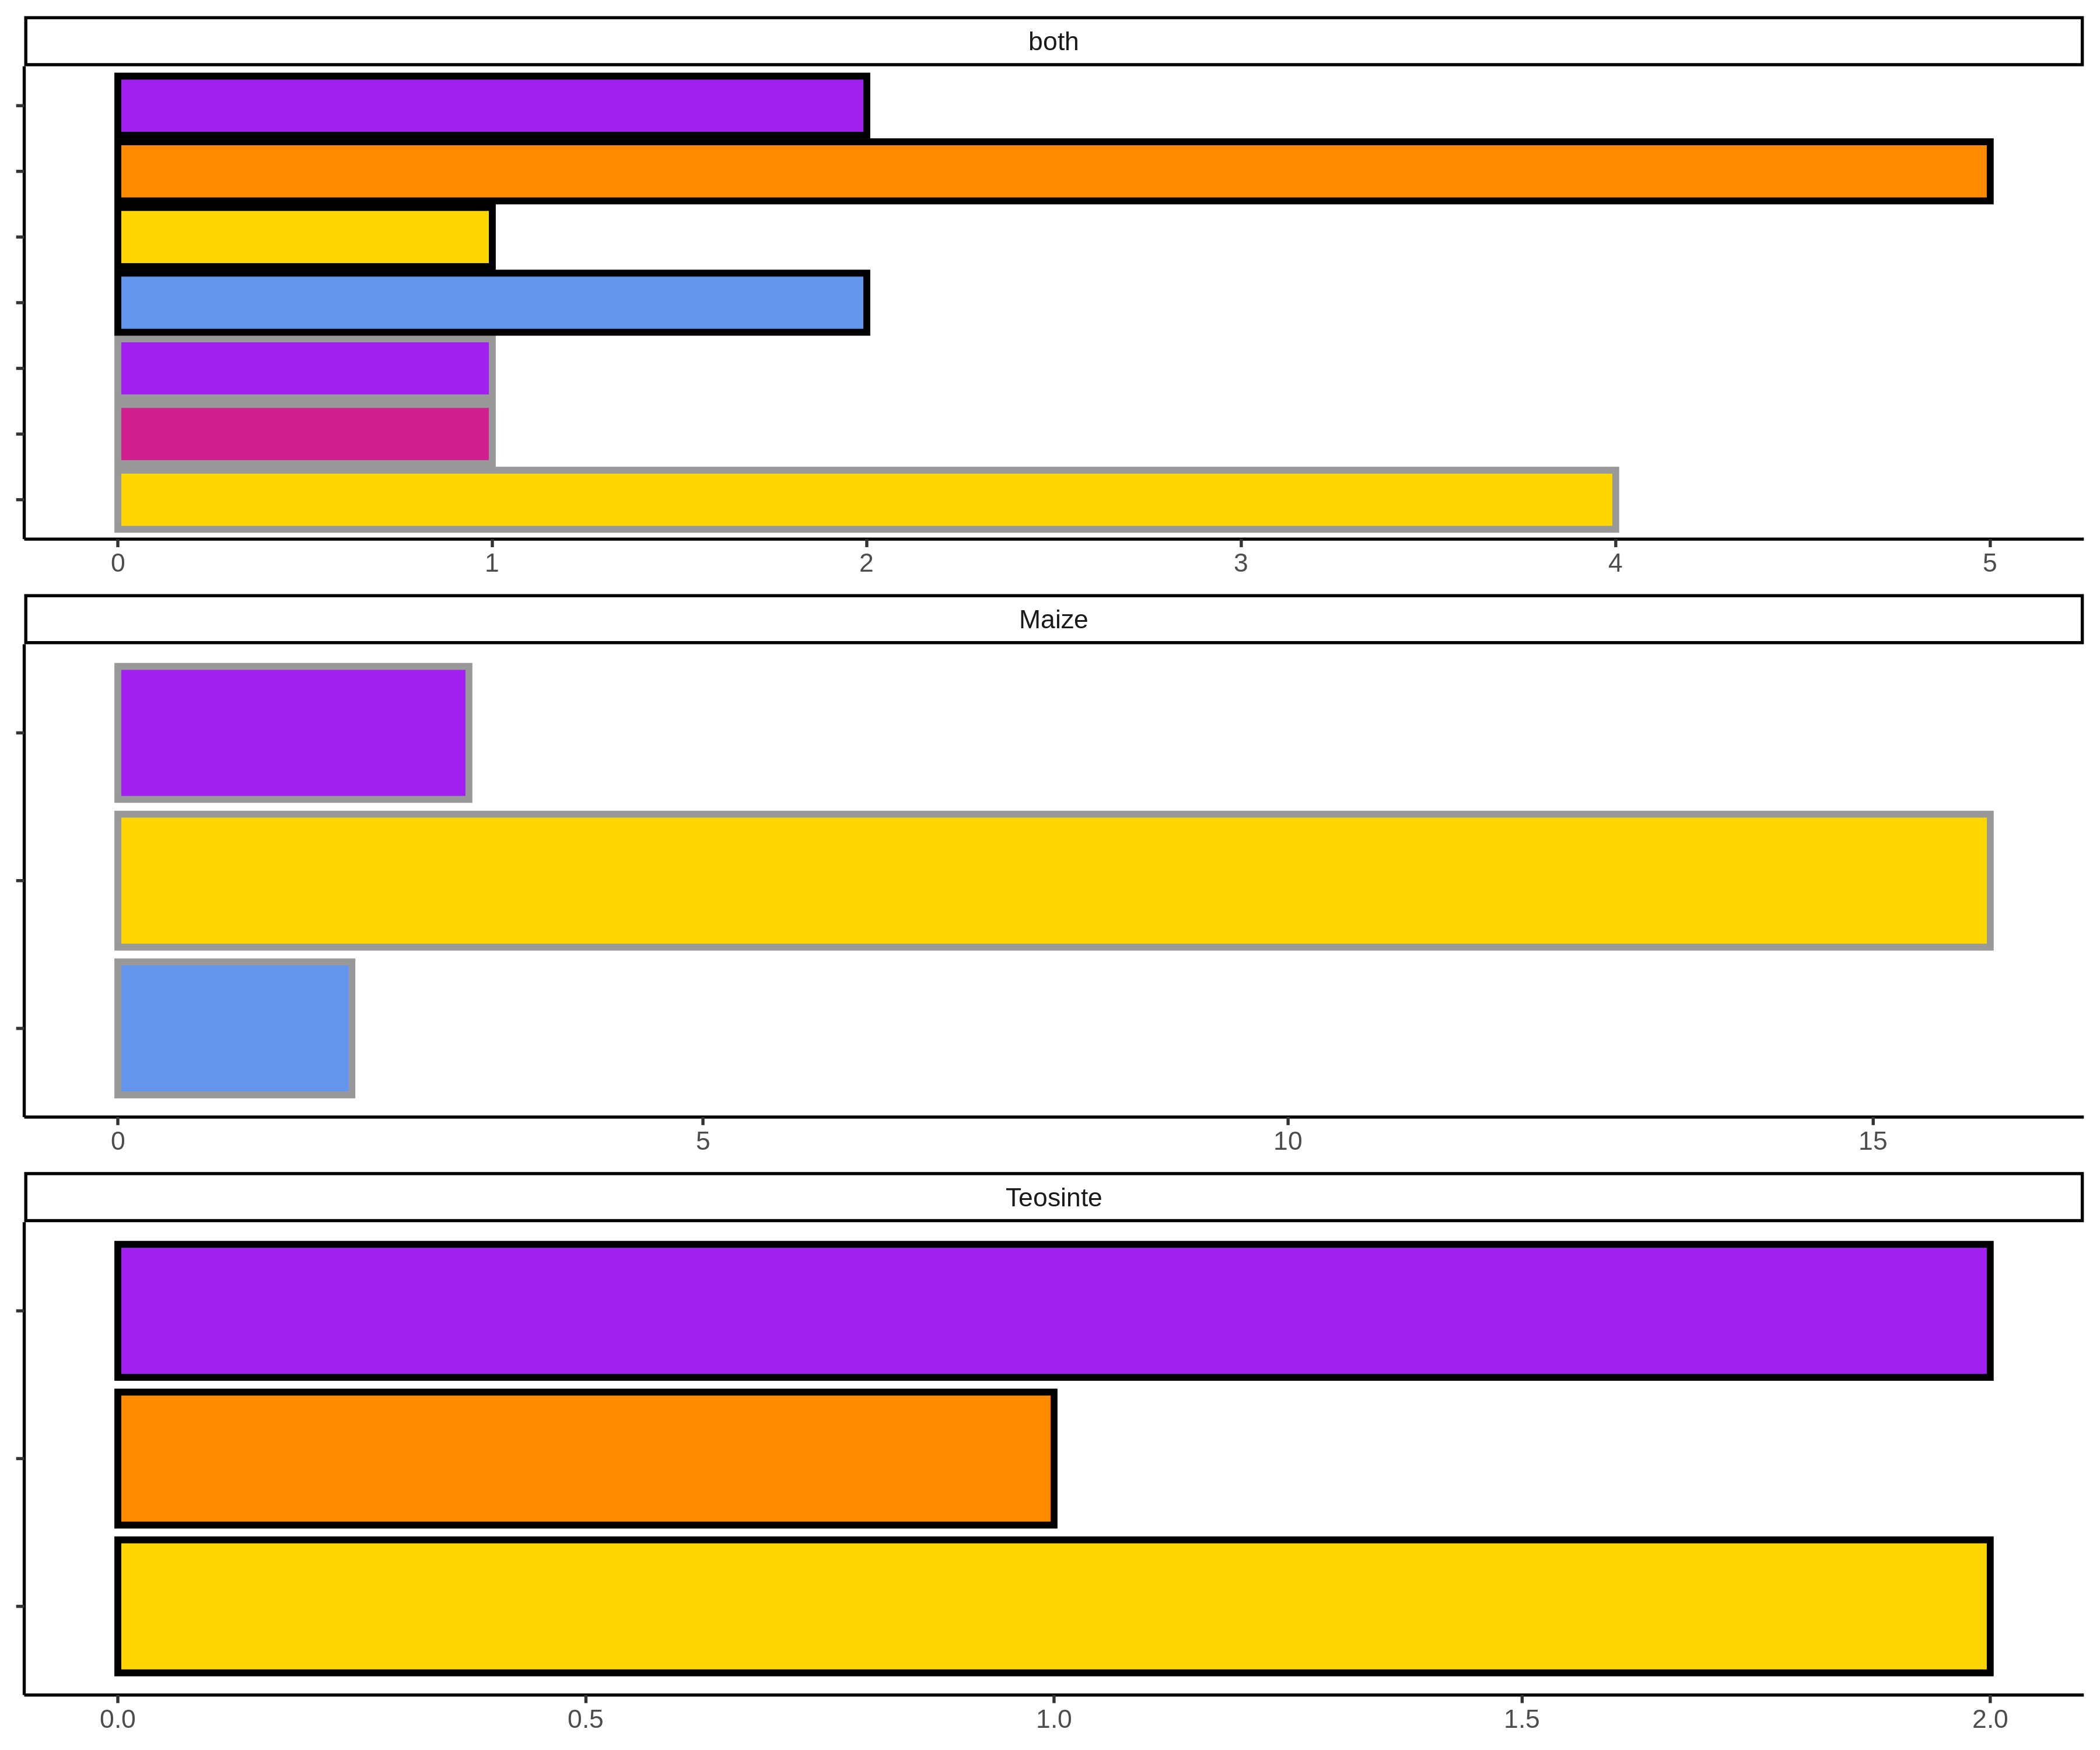

In [16]:
src_df  <-  
top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(ssp_id = ifelse(grepl("Landrace", pop_id), "Landrace", "Teosinte")) %>% 
    mutate(pop_id2 = pop_id) %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop")) %>% 
    filter(!is.na(type))

src_df  %>%
    ggplot(aes(pop_id2, fill = color, colour = ssp_id)) +
    geom_bar(stat = "count", position = position_dodge(preserve = "single"), lwd = 2) +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "free", ncol = 1, drop = FALSE) +
    scale_x_discrete(drop=FALSE) +
    coord_flip() +
    scale_fill_identity() +
    scale_color_manual(values = c("Teosinte" = "black", "Landrace" = "grey60")) +
    theme( 
        strip.text.x = element_text(size = tts_small),
        legend.position = "n",
        axis.title = element_blank(),
        axis.text.y = element_blank()
    )


count,pop,with_alt
<int>,<chr>,<chr>
6,Teo,without
25,Teo,with
37,LR,without
25,LR,with


,model2,sum(Landraces_count),sum(Teosinte_count),n()
,<chr>,<dbl>,<dbl>,<int>
1,migration,43,22,16
2,neutral,27,13,9
3,standing,36,27,9


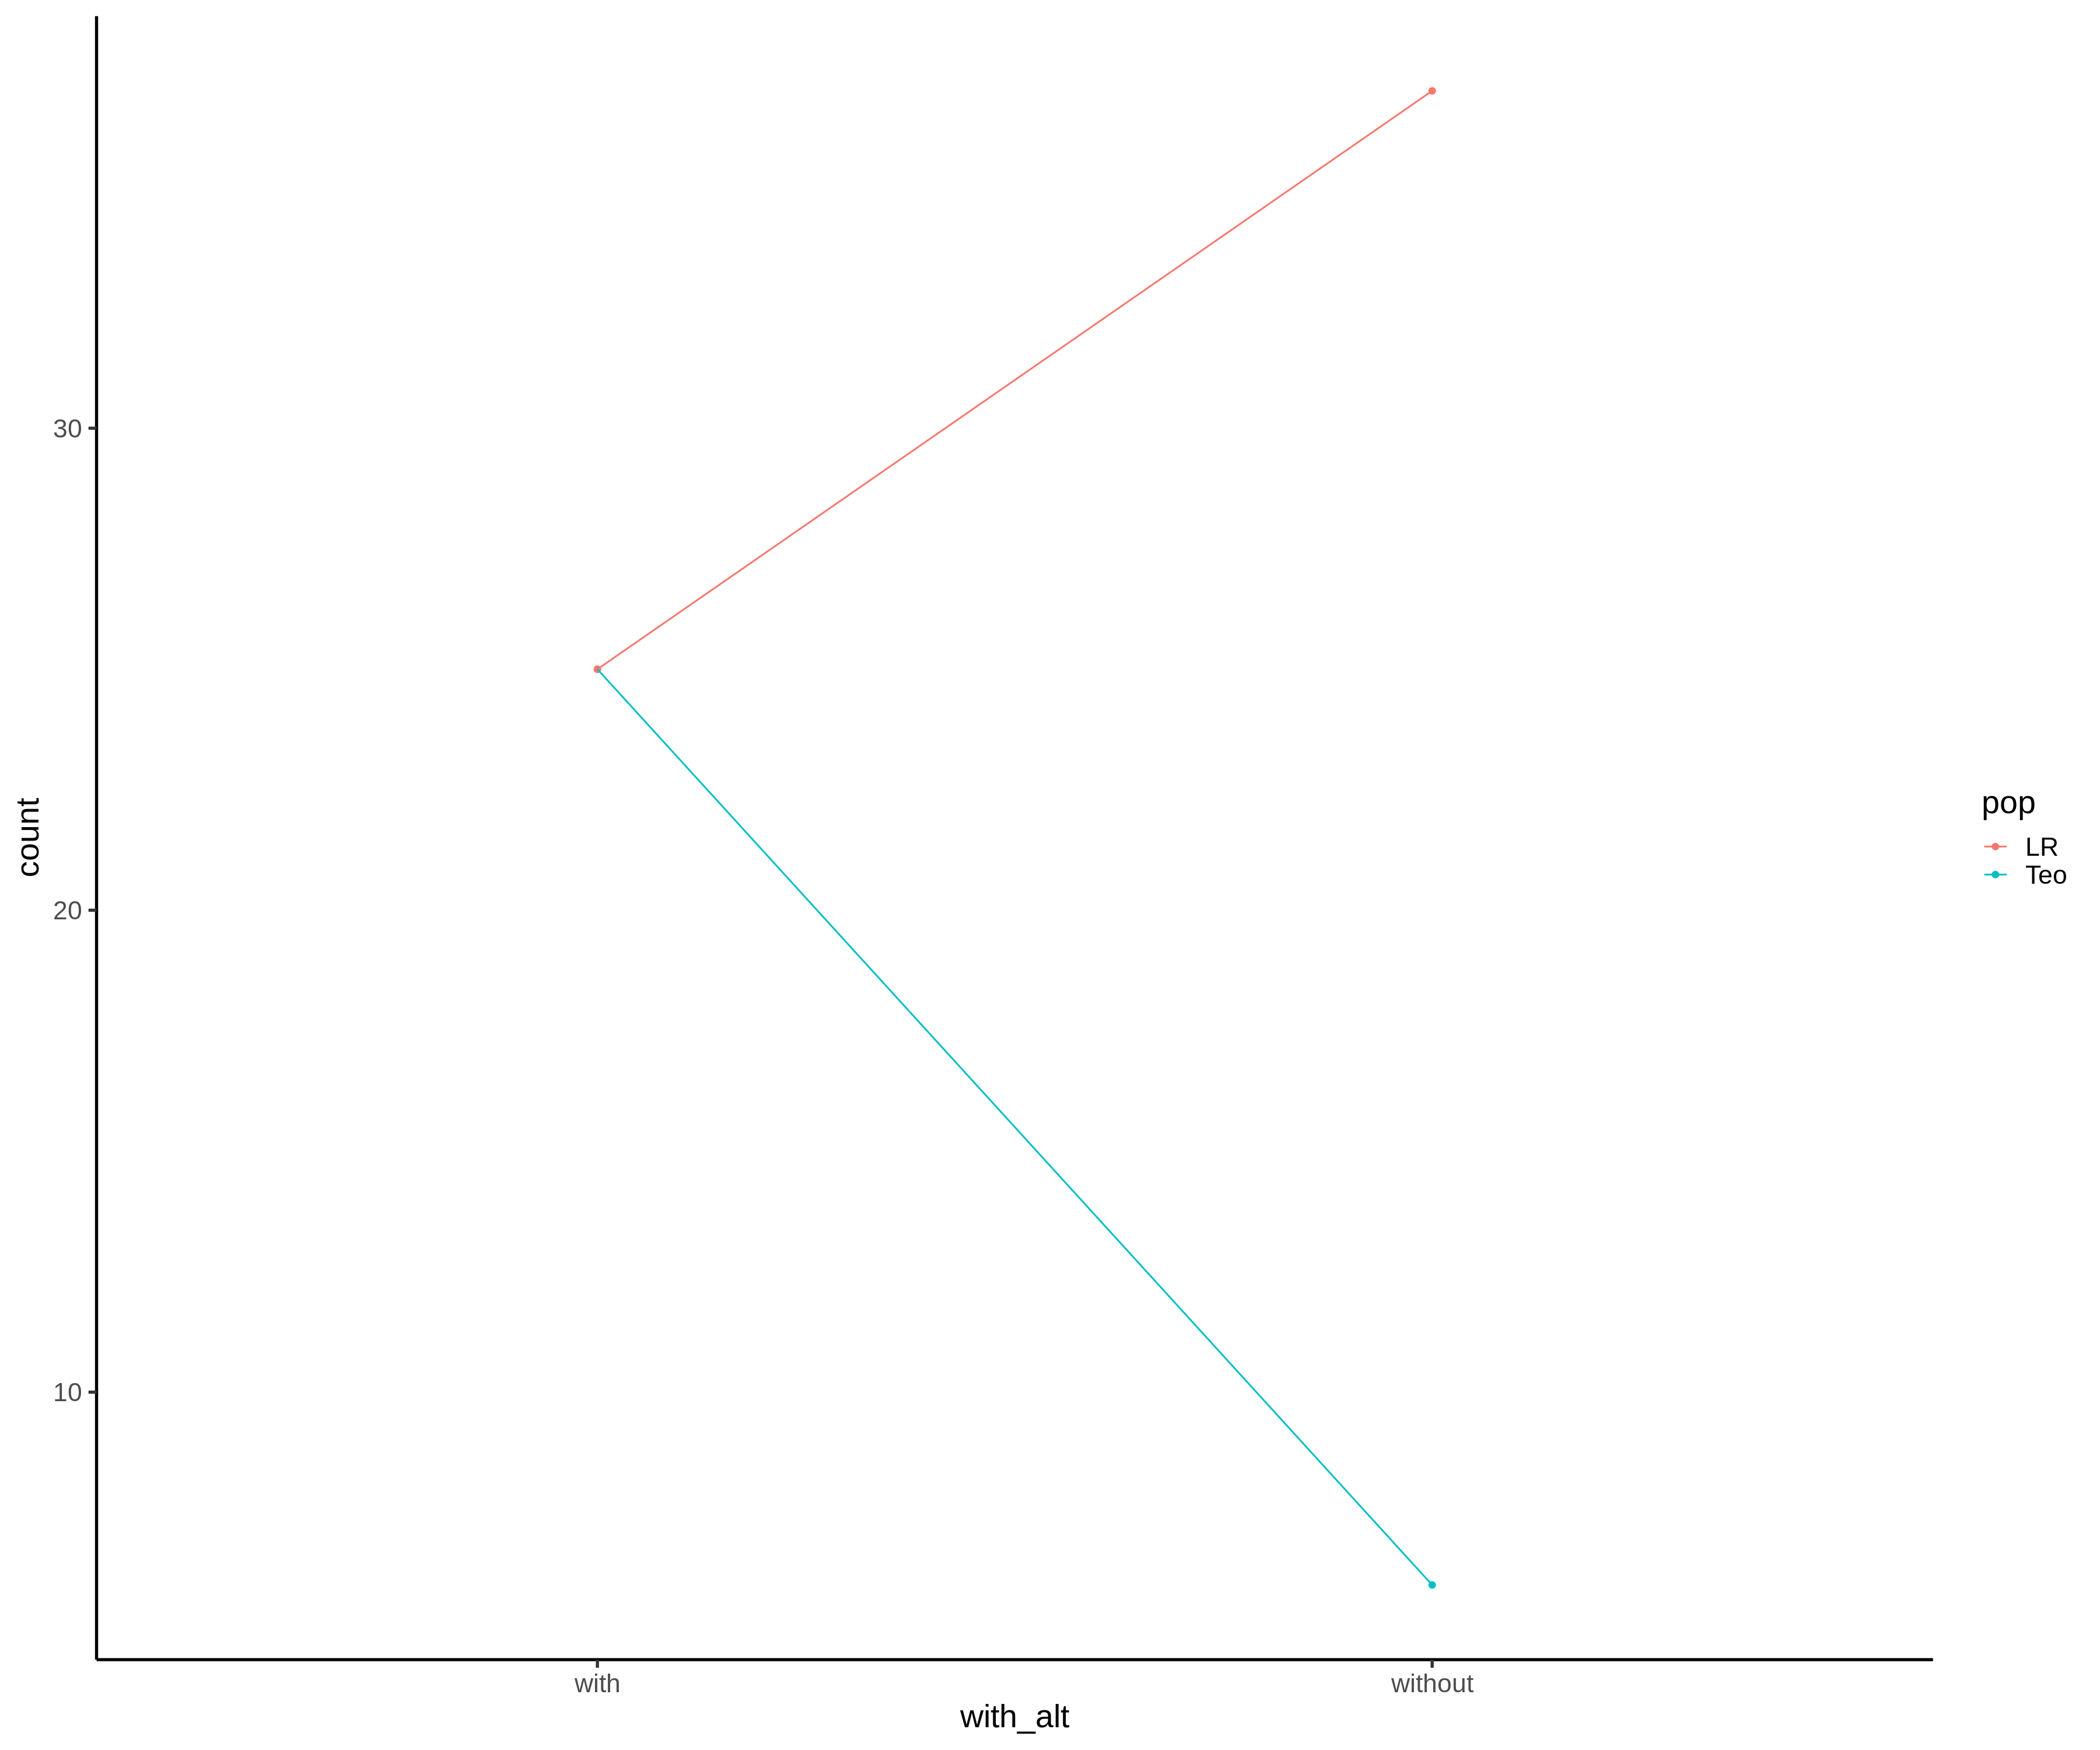

In [17]:
nonneut <- top_models_df %>% filter(model2 != "neutral")

MN <- 1
TEO_noLR <- nonneut %>% filter(Landraces_count == 0, Teosinte_count >= MN)  %>% nrow()
TEO_LR <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count >= MN) %>% nrow()
LR_noTeo <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count == 0)  %>% nrow()
LR_TEO <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count >= MN) %>% nrow()

cross_df <- tibble(
    count = c(TEO_noLR, TEO_LR, LR_noTeo, LR_TEO),
    pop = c("Teo", "Teo", "LR", "LR"),
    with_alt = c("without", "with", "without", "with")
) 

cross_df

cross_df %>% 
group_by(pop) %>% 
mutate(count2 = count/max(count)) %>% 
ggplot(aes(with_alt, count, group = pop, colour = pop)) +
geom_point() +
geom_line()



top_models_df %>% 
  filter(type == "both") %>% 
  group_by(model2) %>% 
  summarise(
      sum(Landraces_count),
      sum(Teosinte_count),
      n()
  )


`summarise()` has grouped output by 'ssp'. You can override using the `.groups` argument.



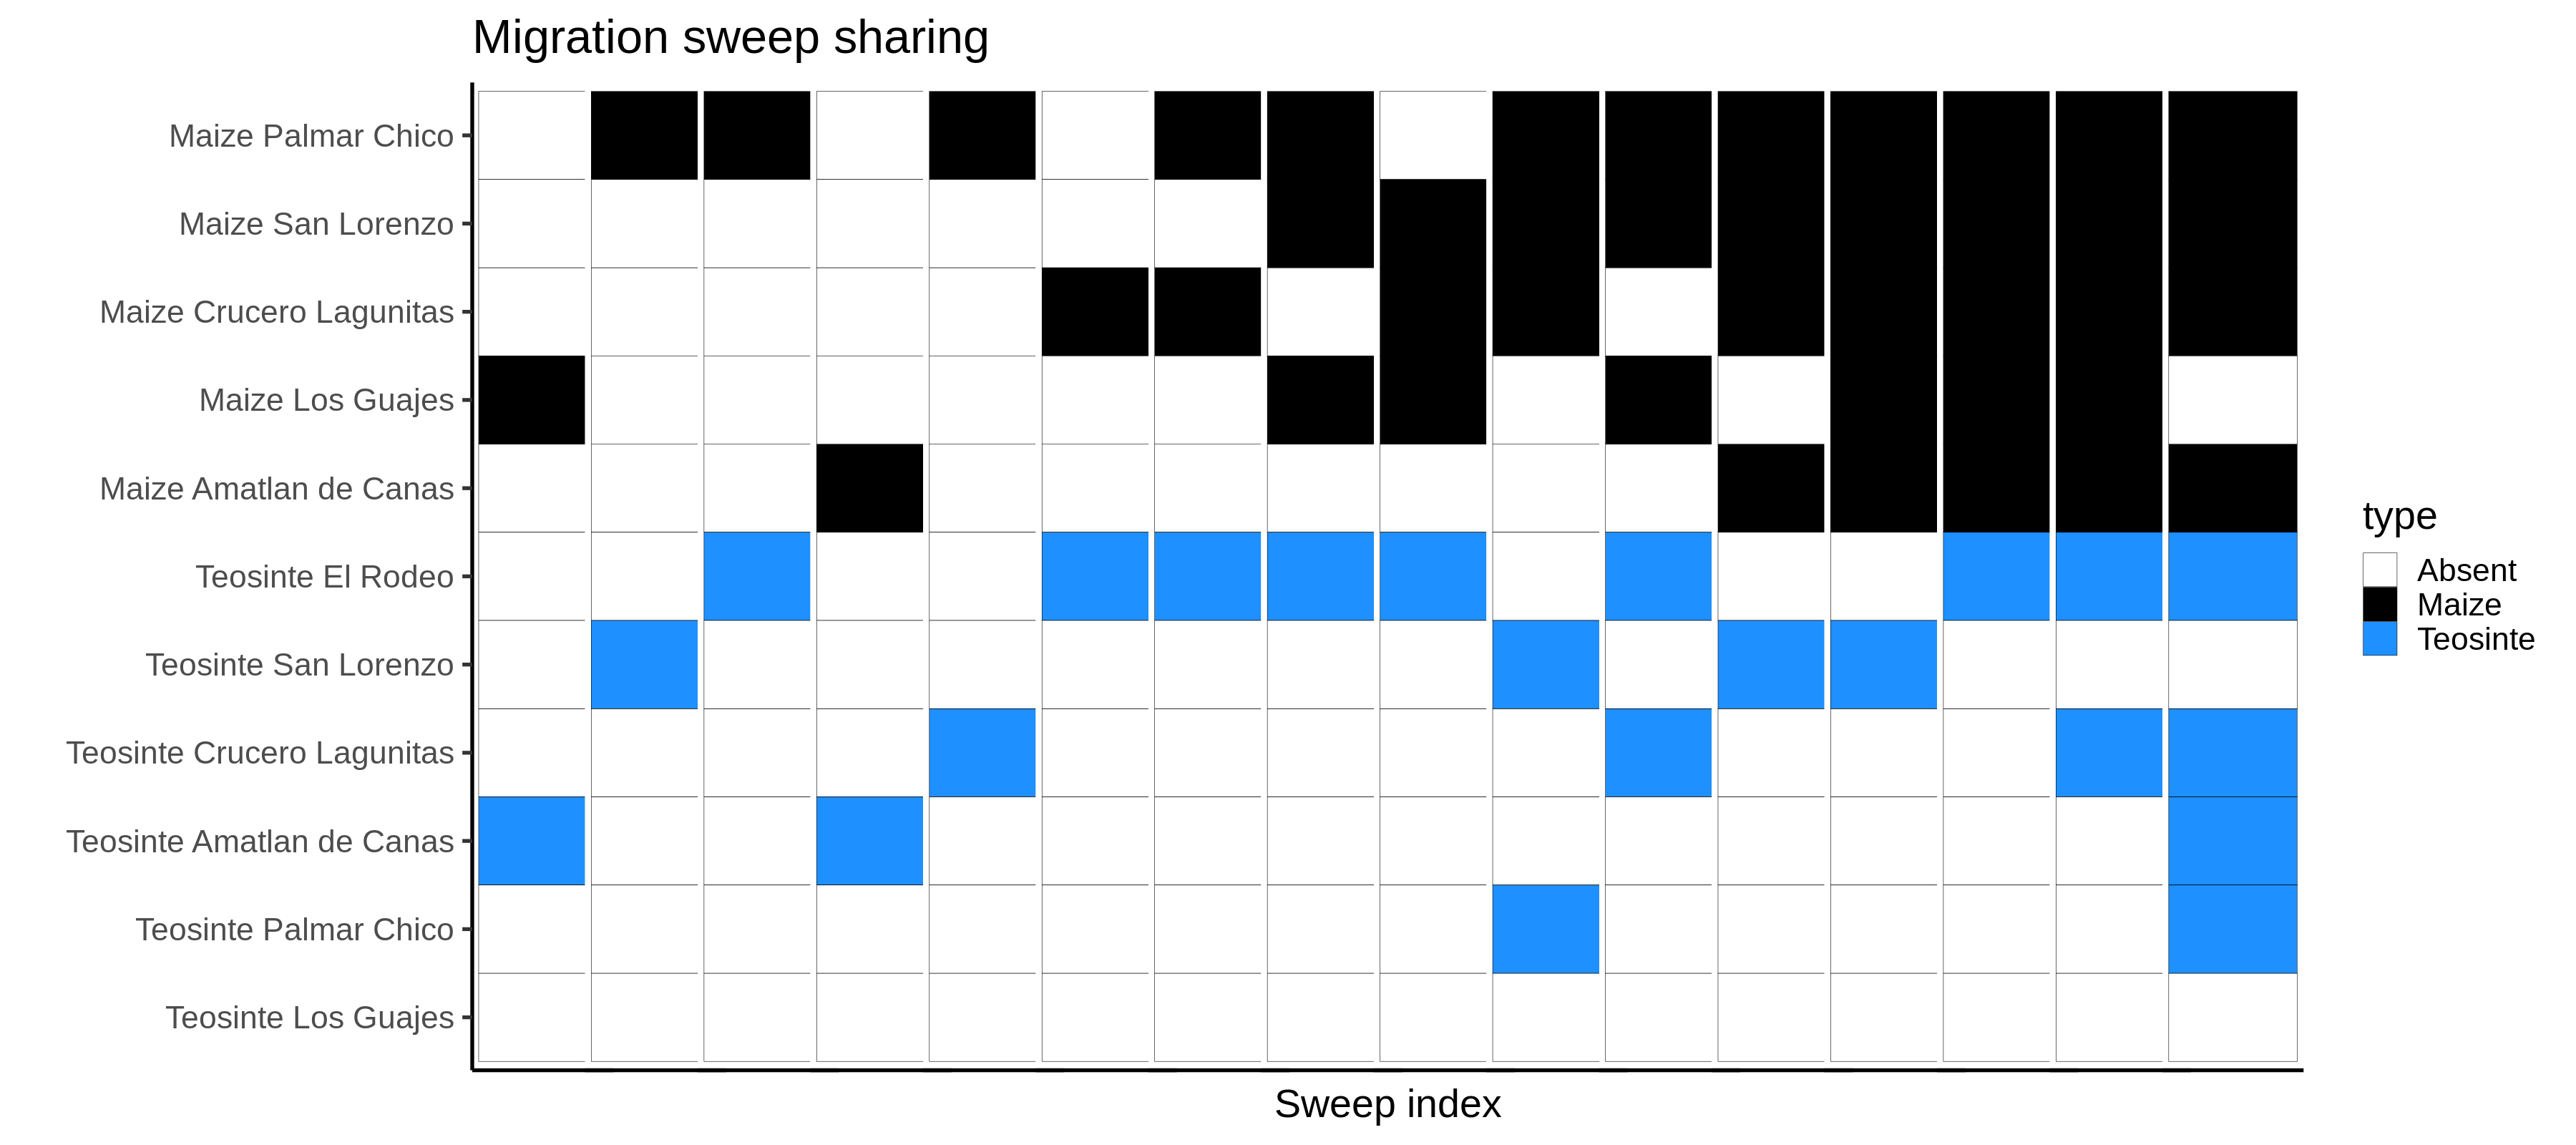

In [18]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200)

msweep_df <- 
top_models_df %>%  
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    arrange(pop_count) %>% 
    pull(populations) %>%
    str_replace_all("_|--", " ") %>% 
    str_replace_all("LR", "Landrace") %>% 
    str_replace_all("Teo", "Teosinte") %>%
    str_remove_all("RANDOM1 ") %>% 
    map_dfr(~{
        count_vec <- str_count(.x, FREQ_POPS)
        names(count_vec) <- FREQ_POPS
        count_vec
    }) %>% 
    mutate(
        sweep_id = 1:n(), 
        sweep_group = round(sweep_id / 1, 0)) %>%
    pivot_longer(-c(sweep_id, sweep_group), names_to = "pop", values_to = "sweep") %>% 
    mutate(pop = str_replace(pop, "Landrace", "Maize"))

pop_order <- 
msweep_df %>%
    mutate(ssp = ifelse(grepl("Teosinte", pop), "Teo", "LR")) %>%
    group_by(ssp, pop) %>% 
    summarise(summ = sum(sweep)) %>% 
    arrange(summ) %>% 
    arrange(desc(ssp), summ) %>% 
    pull(pop)


plt <- 
msweep_df %>% 
    mutate(pop = factor(pop, levels = pop_order)) %>% 
    mutate(
        type = case_when( 
            grepl("Teosinte", pop) & sweep == 1 ~ "Teosinte",
            grepl("Teosinte", pop) & sweep == 0 ~ "Absent",
            grepl("Maize", pop) & sweep == 1 ~ "Maize",
            grepl("Maize", pop) & sweep == 0 ~ "Absent"
        ) 
    ) %>% 
    #ggplot(aes(sweep_id, pop, fill = factor(sweep))) +
    ggplot(aes(sweep_id, pop, fill = type)) +
    geom_tile(color = "black") +
    facet_wrap(~sweep_group, scales = "free_x", nrow = 1) +
    xlab("Sweep index") +
    ylab("") +
    theme(
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.spacing.x = unit(-1, "lines"),  
    ) +
    scale_fill_manual(labels = c("Absent", "Maize", "Teosinte"), values = c("white", "black", "dodgerblue")) +
    ggtitle("Migration sweep sharing")

plt + ggsave("../figures/supplement_sweeps.pdf", width = 18, height = 8)


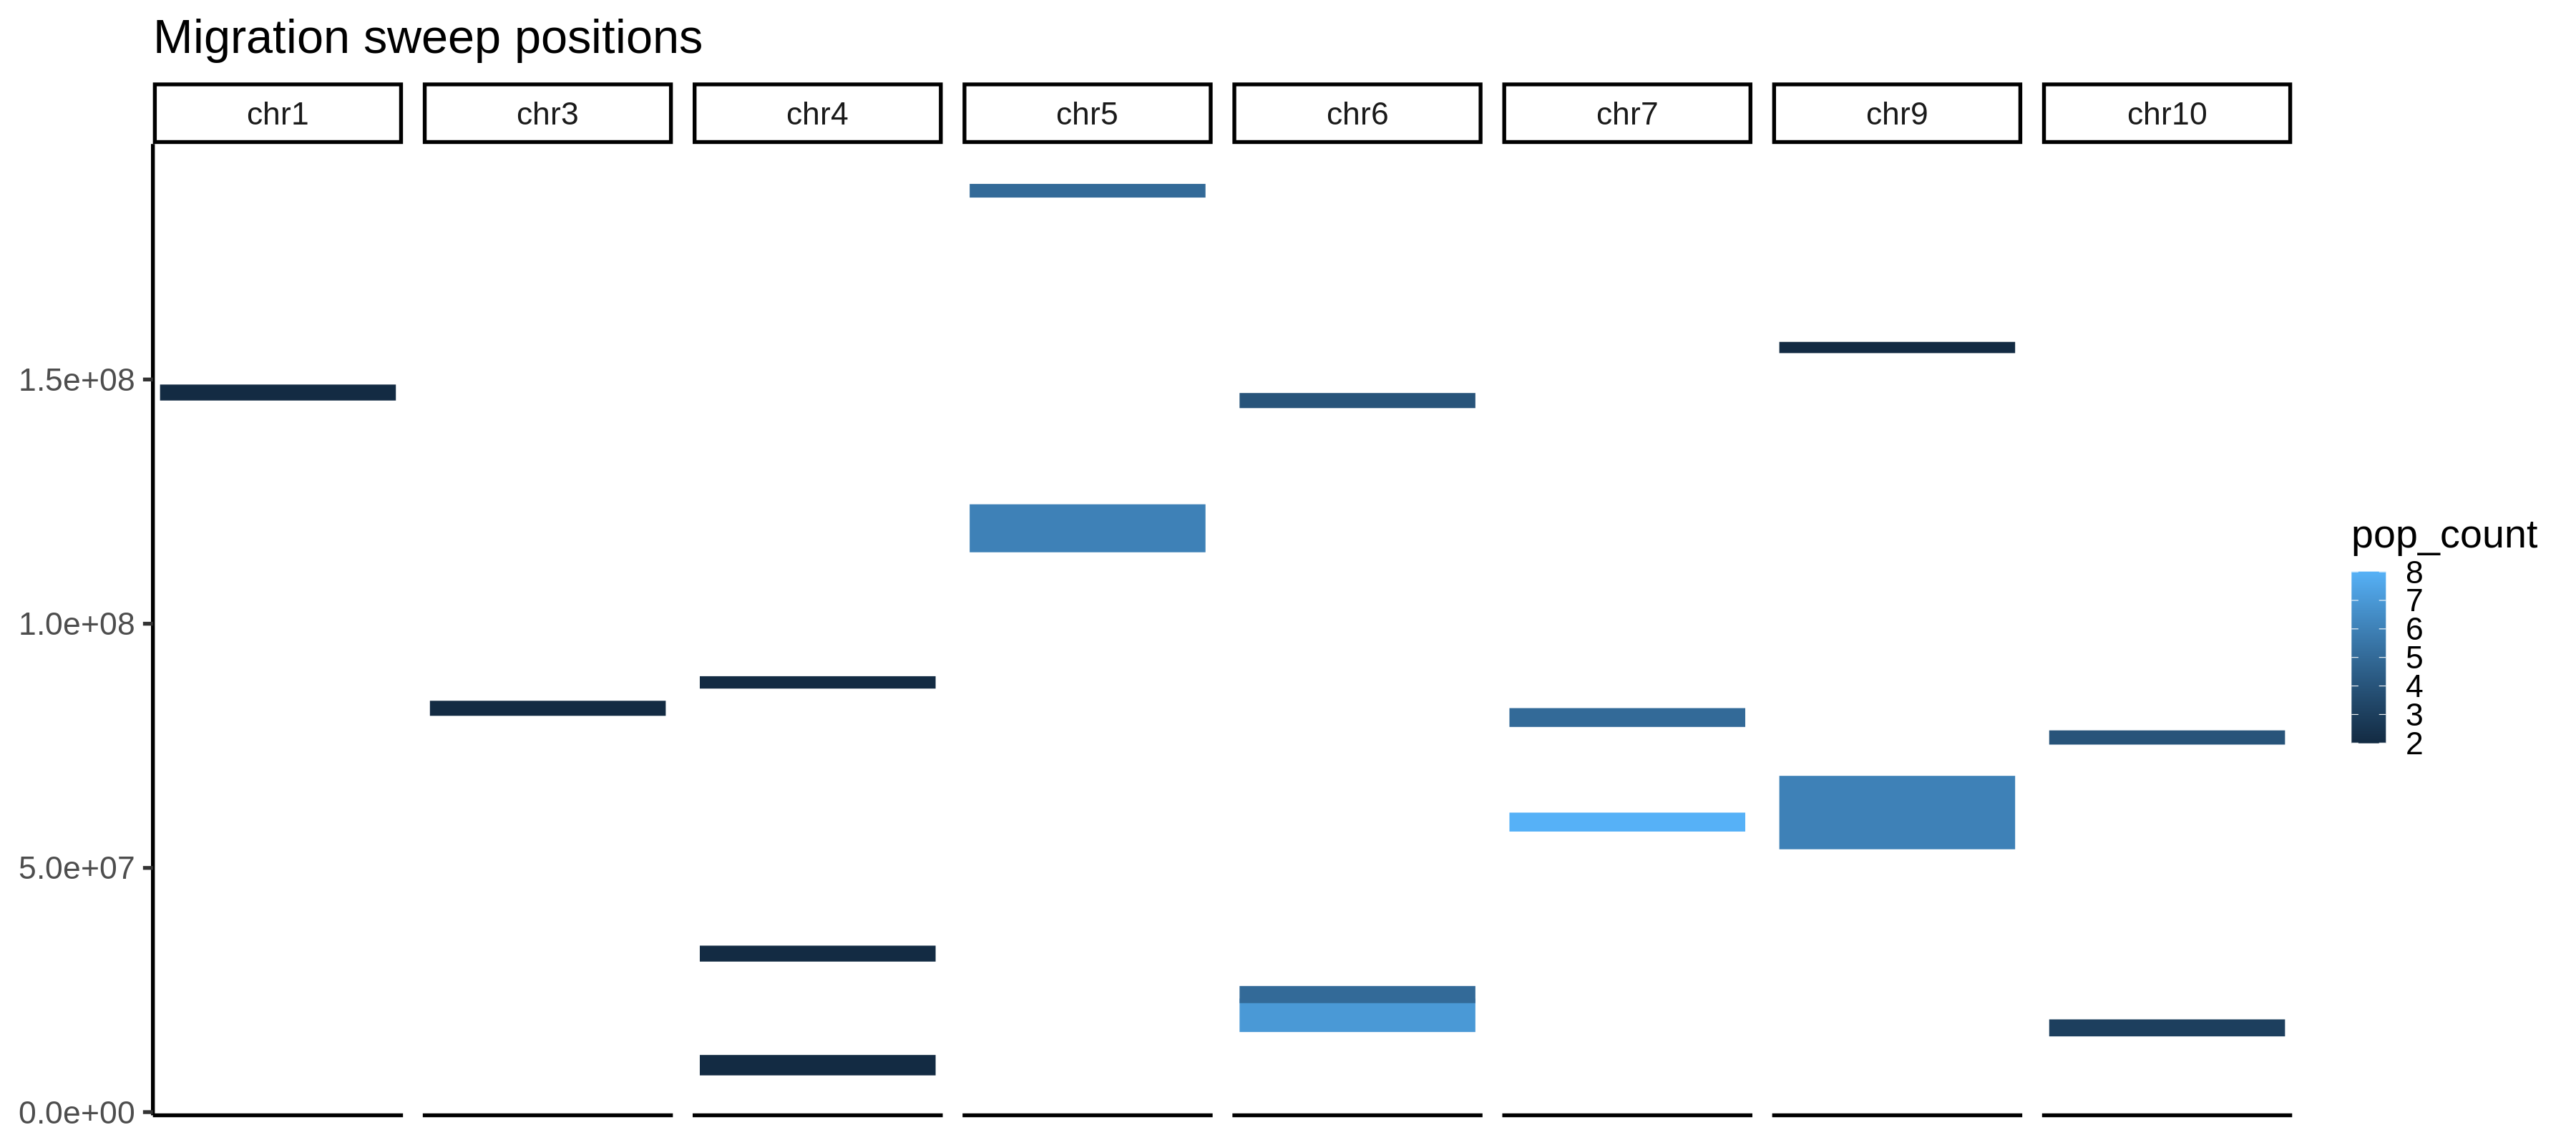

In [19]:
top_models_df %>%
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    mutate(chrom = str_extract(locus, "chr[0-9][0-9]*")) %>%
    mutate(chrom = factor(chrom, levels = paste0("chr", 1:10))) %>% 
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    ggplot() +
    geom_rect(aes(xmin = 0, xmax = 1, ymin = sweep_start_bp, ymax = sweep_end_bp, color = pop_count, fill = pop_count), lwd = 2) +
    facet_grid(~chrom) +
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank()) +
    ggtitle("Migration sweep positions") +
    ggsave("../figures/supplement_sweeps_locs.pdf", width = 14, height = 15)


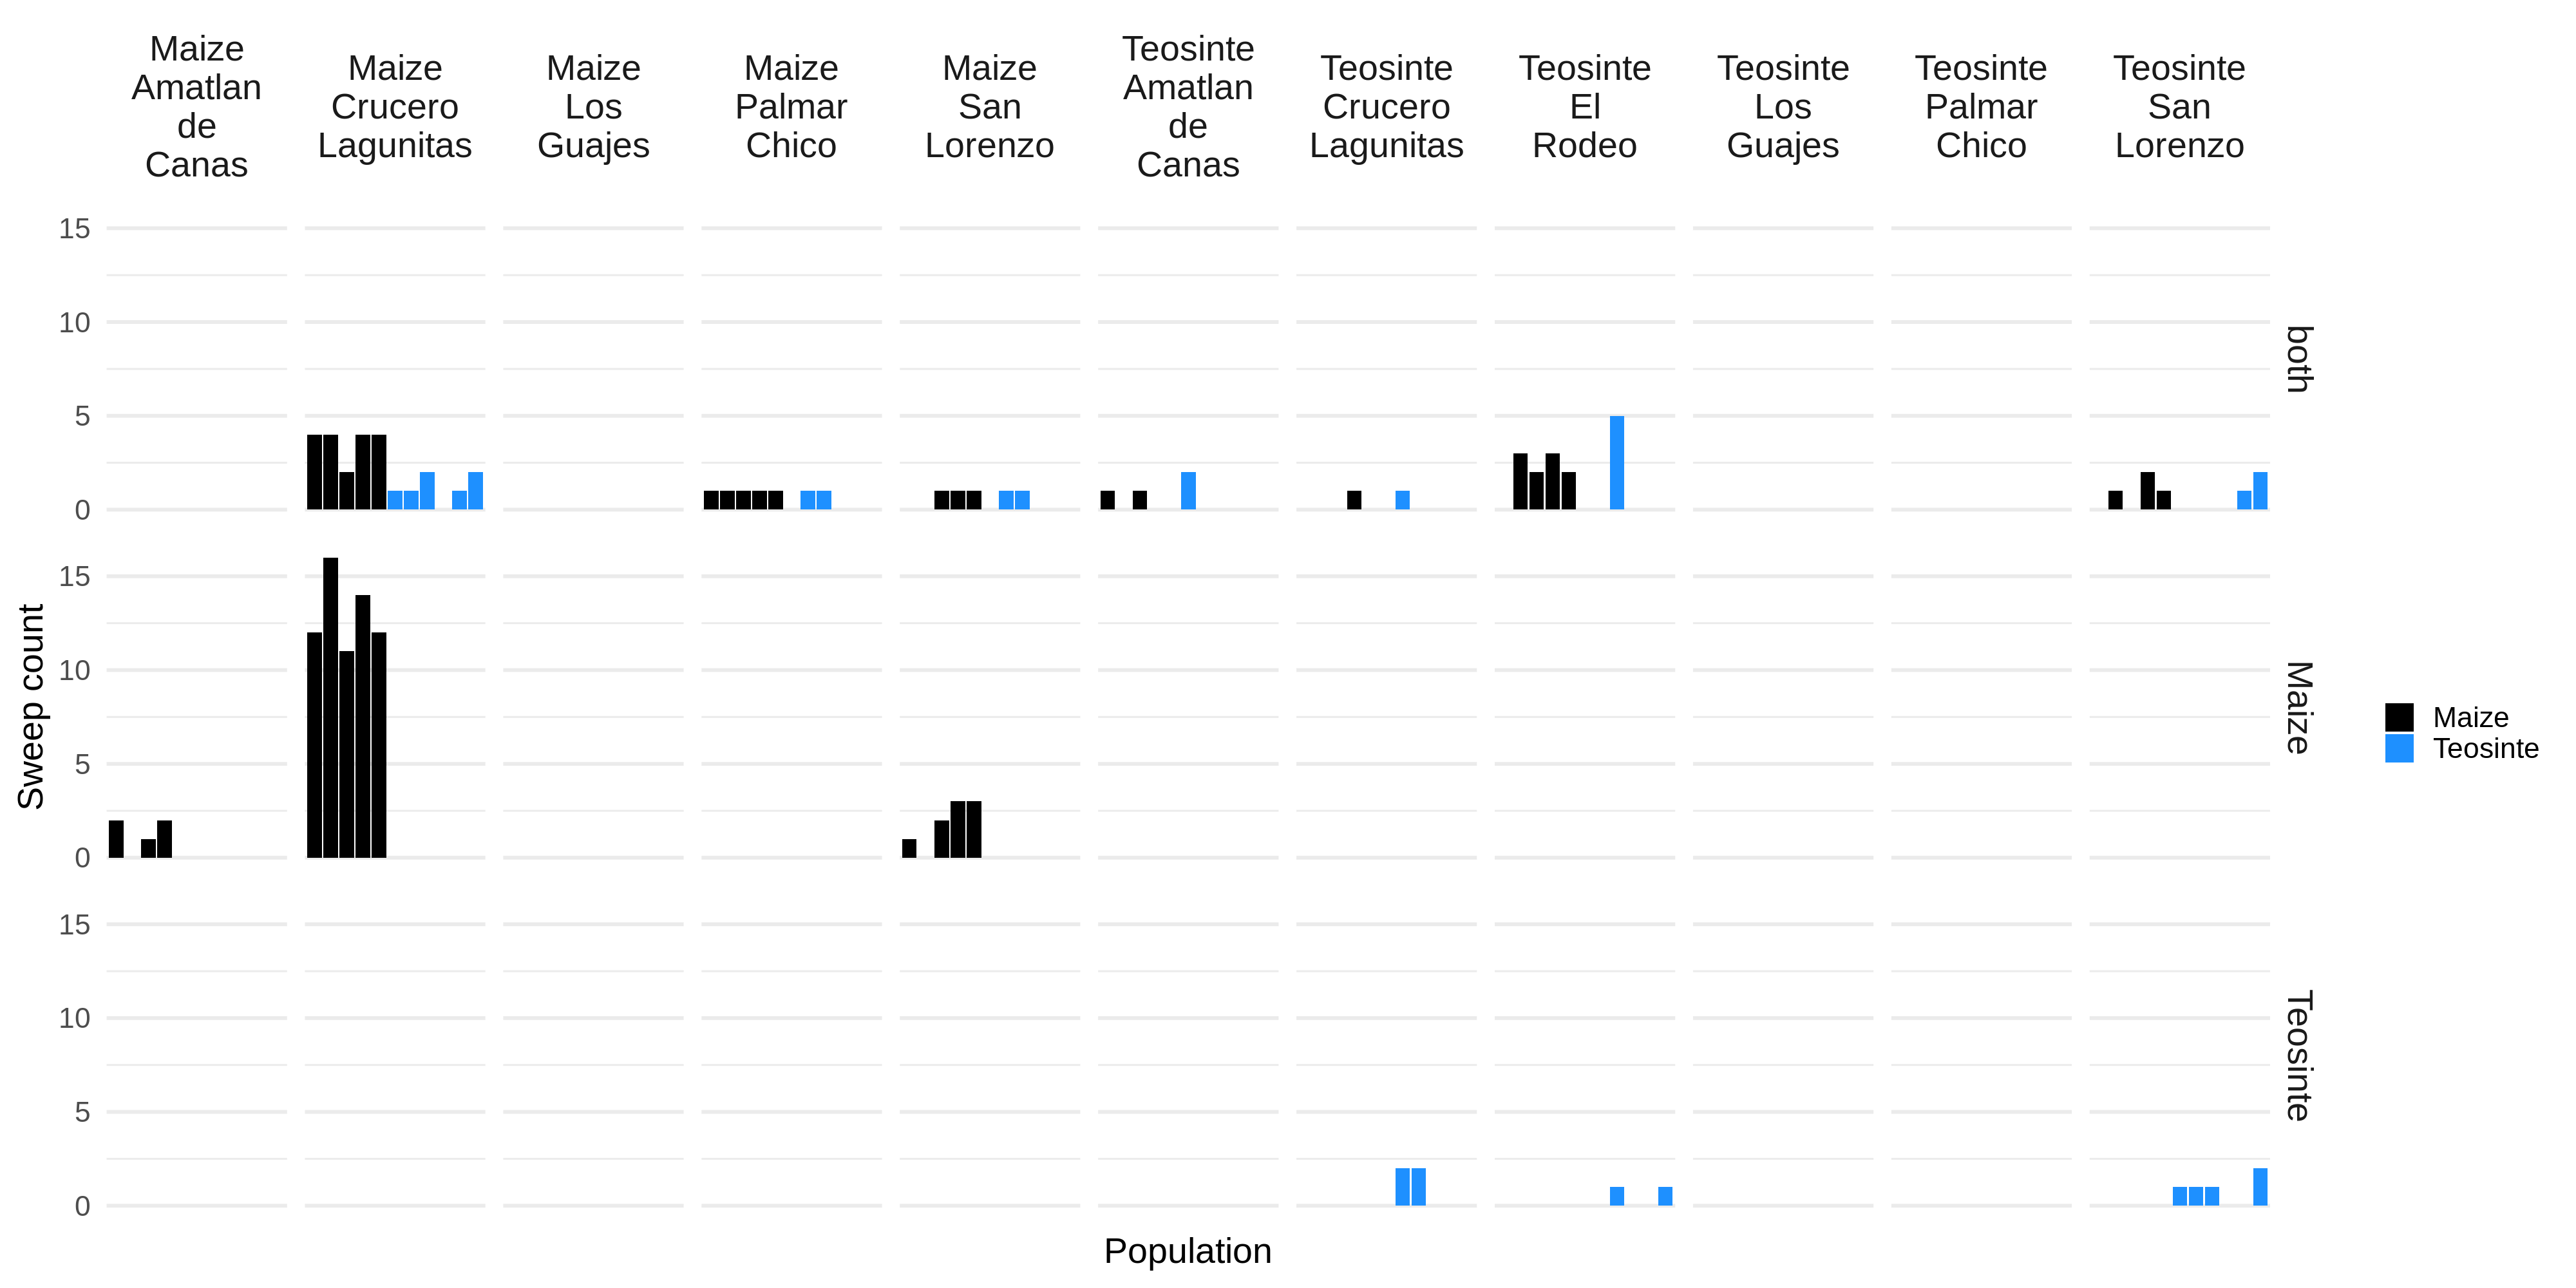

In [20]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 200)

FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

latlong_df <- 
    tibble(
    population = c("Crucero Lagunitas", "Amatlan de Canas", "El Rodeo", "Los Guajes", "San Lorenzo", "Palmar Chico"),
    color = c("gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred"),
    Latitude = c(16.98, 20.82, 16.35, 19.23, 19.94, 18.64),
    Longitude = c(-99.28, -104.41, -97.02, -100.49, -103.99, -100.35),
    altitude = c(590, 880, 982, 985, 982, 1008)
    )

id_vec <- 
str_split(top_models_df$populations, pattern = ";", simplify = T) %>% 
as.matrix(ncol = 1) %>% 
as.vector() %>% 
str_remove_all(" ") %>%
unique()

pops_vec <- 
id_vec %>% 
str_remove_all("v5--") %>%
str_replace_all("--", " ") %>% 
str_replace_all("_", " ")

sourcepop_df <- 
c("both", "Maize", "Teosinte") %>% 
map_df(function(TYPE){
    map_df(FREQ_POPS, function(source_pop){
        expand_grid(pop1 = id_vec) %>%
        filter(str_length(pop1) > 0) %>% 
        pmap_df(function(pop1){
            count <- 
            top_models_df %>% 
            filter(model2 == "migration", type == TYPE,
                   sources == which(FREQ_POPS == source_pop),
                   grepl(pop1, populations)
                  ) %>% 
            nrow()
            tibble(source_pop, pop1, count, type = TYPE)
        })
    })
}) %>% 
    mutate(
        pop1 = str_remove_all(pop1, "v5--"),
        pop1 = str_remove_all(pop1, "RANDOM1"),
        pop1 = str_replace_all(pop1, "--", " "),
        pop1 = str_replace_all(pop1, "_", " "),
        pop1 = str_replace_all(pop1, "  ", " "),
        pop1 = str_replace_all(pop1, "LR", "Maize"),
        pop1 = str_replace_all(pop1, "Teo", "Teosinte")
    ) %>% 
    mutate(ssp = ifelse(grepl("Maize", pop1), "Maize", "Teosinte"),
           source_ssp = ifelse(grepl("Maize", source_pop), "Maize", "Teosinte")) #%>% 
    #filter(source_pop != pop1)

sourcepop_df %>%
    mutate(source_pop = str_replace_all(source_pop, " ", "\n"),
           source_pop = str_replace_all(source_pop, "Landrace", "Maize")
           ) %>% 
    ggplot(aes(pop1, count, fill = ssp)) +
    geom_bar(stat = "identity") +
    facet_grid(type ~ source_pop) +
    theme_minimal(20) +
    theme(axis.text.x = element_blank(), 
         strip.text = element_text(size = 20),
         panel.grid.major.x = element_blank(),
         panel.grid.minor = element_line(size = 0.5), 
         panel.grid.major = element_line(size = 1)
        ) +
    xlab("Population") +
    ylab("Sweep count") +
    scale_fill_manual(values = c("Maize" = "black", "Teosinte" = "dodgerblue")) +
    guides(fill=guide_legend(title="")) +
    ggsave("../figures/supplement_sources.pdf", width = 20, height = 10)



In [21]:
suppressMessages(
best_pos_df <- 
    fs::dir_ls(path = "../data/rdmc/fitted/") %>% 
    map_df(~{
        
        sweep_file <- vroom::vroom(., delim = "\t")

        if(nrow(sweep_file) >= 1){
        sweep_all <- sweep_file %>% 
        group_by(across(-c(selected_sites, cle))) %>% 
        mutate(model_set = cur_group_id(),
              window = 1:n()) %>% 
        ungroup()

        best <- filter(sweep_all, cle == max(cle, na.rm = TRUE))
        print(best$model)[1]
        if(nrow(best) >= 1 & best$cle[1] > best$neut_cle[1]){
            
         next_best_site <- filter(sweep_all, model_set == best$model_set) %>% 
            mutate(delta_cle = max(cle, na.rm = TRUE) - cle) %>% 
            arrange(delta_cle) %>% 
            slice(2)

        if(nrow(next_best_site)>=1){
        tibble(
        delta_cle = best$cle - next_best_site$cle,
        delta_pos = best$window - next_best_site$window,
        best_index = best$window
        )   
        }
        }
        }

})
)



[1] "standing"
[1] "migration"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "migration"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "migration"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing" "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "migration"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "migration"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "standing"
[1] "standing"
[1] "migration"
[1] "standing"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "standing"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "migration"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "standing"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "standing" "standing" "standing"
[1] "migration"
 [1] "standing" "standing" "standing" "standing" "standing" "standing"
 [7] "standing" "standing" "standing" "standing" "standing" "standing"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "independent"
[1] "migration"
[1] "migration"
[1] "standing" "standing"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "standing"
[1] "migration"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "standing"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "independent"


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)


Warning message in max(cle, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


character(0)
[1] "standing"
[1] "standing"
[1] "standing"
[1] "migration"
[1] "migration"
[1] "standing"
[1] "migration"
[1] "standing"
[1] "standing"


0%          25%          50%          75%         100% 
1.006981e-02 9.302199e-01 7.810615e+00 5.108879e+01 1.049237e+03

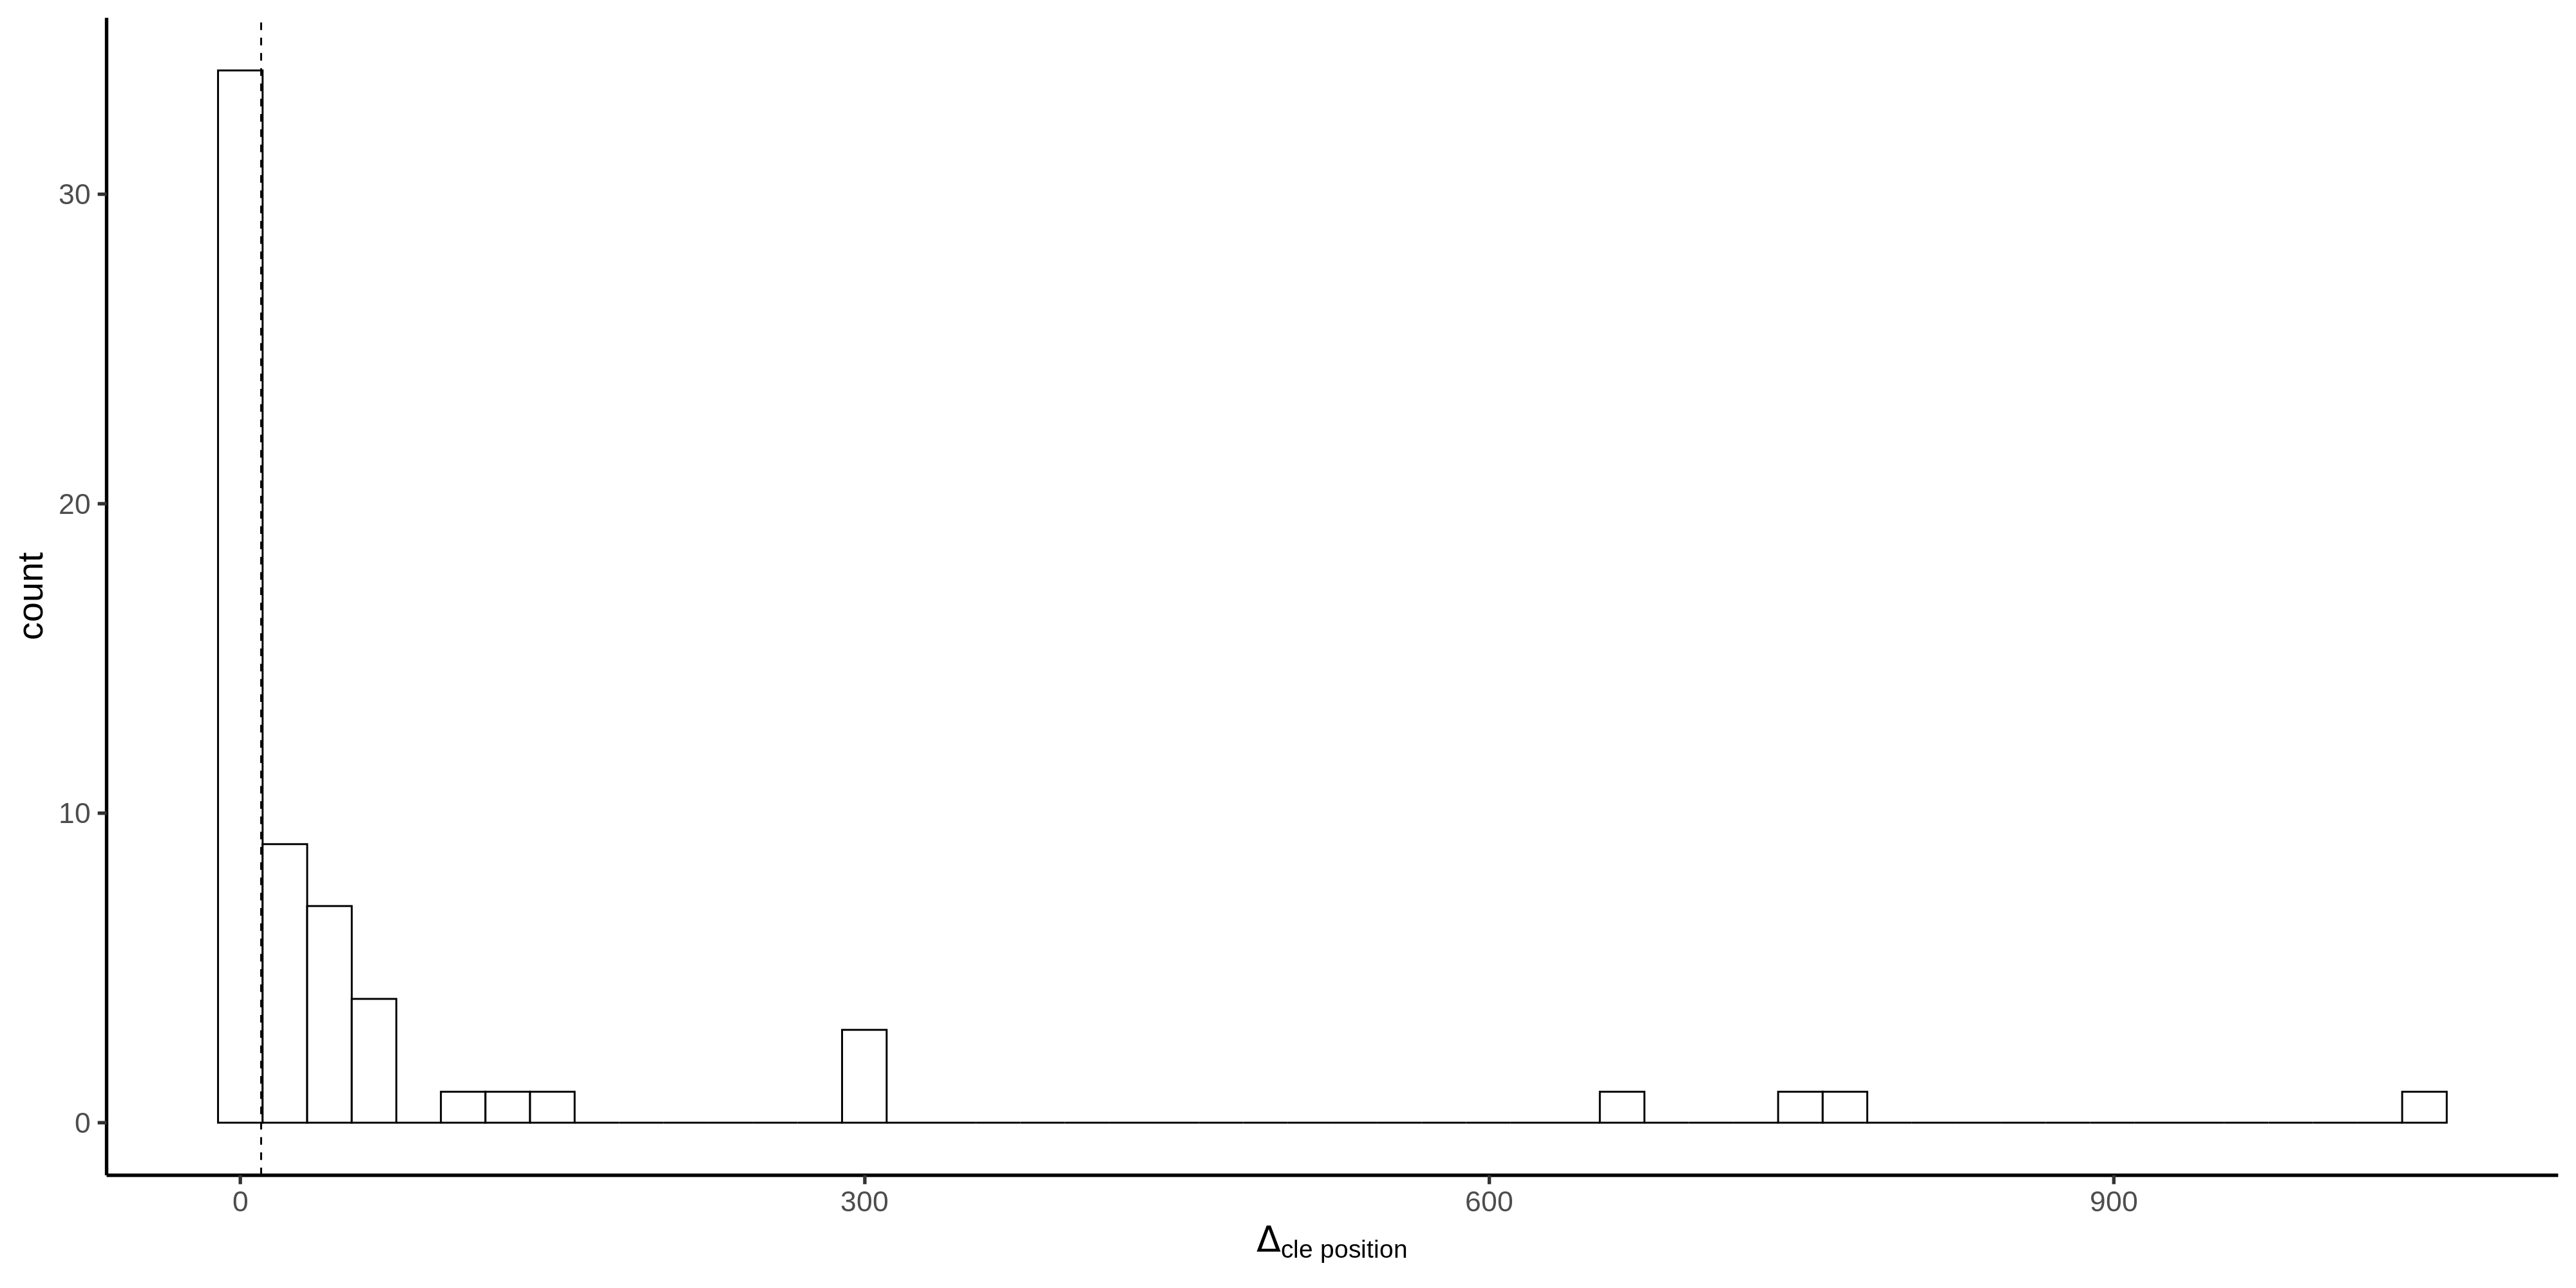

In [135]:
#hist(best_pos_df$delta_cle, nbins = 10) 
#abline(v = mean(best_pos_df$delta_cle, na.rm = TRUE), col = "red", lwd = 3)


best_pos_df_filtered <- best_pos_df %>% filter(delta_cle < Inf)

ggplot(best_pos_df_filtered) + 
geom_histogram(aes(x = delta_cle), fill = "white", colour = "black", bins = 50) +
geom_vline(xintercept = 10, lty = 2) + 
xlab(expression(Delta["cle position"]))

quantile(best_pos_df_filtered$delta_cle, na.rm = TRUE)

In [23]:
median(best_pos_df$delta_cle, na.rm = TRUE)
median(abs(best_pos_df$delta_pos))
median(best_pos_df$delta_pos)

[1] 7.810615

[1] 7

[1] 0